# Medical Image Classification

In [1]:
from tqdm import tqdm
import numpy as np
import os
import PIL
import shutil
import tempfile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import classification_report

import medmnist
from medmnist import INFO, Evaluator

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader, Dataset
from monai.metrics import ROCAUCMetric
import monai.networks.nets as nets
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    EnsureChannelFirst,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    RandGaussianNoise,
    RandAdjustContrast,
    ScaleIntensity, 
    Transform,
    ToTensor,
    EnsureType,
)
from monai.utils import set_determinism

print_config()

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.4.dev2441
Numpy version: 1.26.3
Pytorch version: 2.2.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: cf815ed4e44a5b8ce67e894ab0bc2765279a1a59
MONAI __file__: /mnt/hdd/<username>/.local/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: 0.24.0
scipy version: 1.14.1
Pillow version: 10.2.0
Tensorboard version: 2.18.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.17.1
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.2.3
einops version: 0.8.0
transformers version: 4.46.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the o

## Continue working with OrganMNIST3d 64x64x64

In [2]:
data_flag = 'organmnist3d'
download = True

NUM_EPOCHS = 100
BATCH_SIZE = 32
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download, size=64)
val_dataset = DataClass(split='val', download=download, size=64)
test_dataset = DataClass(split='test', download=download, size=64)

Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz
Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz
Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz


In [3]:
root_dir = '/mnt/hdd/marina/.medmnist/'

In [4]:
train_dataset

Dataset OrganMNIST3D of size 64 (organmnist3d_64)
    Number of datapoints: 971
    Root location: /mnt/hdd/marina/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'liver', '1': 'kidney-right', '2': 'kidney-left', '3': 'femur-right', '4': 'femur-left', '5': 'bladder', '6': 'heart', '7': 'lung-right', '8': 'lung-left', '9': 'spleen', '10': 'pancreas'}
    Number of samples: {'train': 971, 'val': 161, 'test': 610}
    Description: The source of the OrganMNIST3D is the same as that of the Organ{A,C,S}MNIST. Instead of 2D images, we directly use the 3D bounding boxes and process the images into 28×28×28 to perform multi-class classification of 11 body organs. The same 115 and 16 CT scans as the Organ{A,C,S}MNIST from the source training set are used as training and validation set, respectively, and the same 70 CT scans as the Organ{A,C,S}MNIST from the source test set are treated as the test set.
    License: CC BY 4.0

## Define transforms

In [5]:
train_transforms = Compose(
    [
        ScaleIntensity(),
        RandGaussianNoise(prob=0.5, mean=0.0, std=0.05),
        RandAdjustContrast(gamma=(0.7, 1.3), prob=0.5),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        ToTensor(),
        EnsureType(),
    ]
)

val_transforms = Compose([
    ScaleIntensity(),
    ToTensor(),
    EnsureType(),
])

test_transforms = Compose([
    ScaleIntensity(),
    ToTensor(),
    EnsureType(),
])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=n_classes)])

## Extract 2d slices

In [6]:
class Extract2DSlices(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data, label = self.dataset[idx]

        # if self.transform:
        #     data = self.transform(data)

        axial, coronal, sagittal = self.extract_2d_slices(data)

        if self.transform:
            axial = self.transform(axial)
            coronal = self.transform(coronal)
            sagittal = self.transform(sagittal)

        data = {'axial': axial, 'coronal': coronal, 'sagittal': sagittal}
        
        return {'images': (data['axial'], data['coronal'], data['sagittal']), 'label': label}

    @staticmethod
    def extract_2d_slices(data):
        mid_axial = data.shape[1] // 2
        mid_coronal = data.shape[2] // 2
        mid_sagittal = data.shape[3] // 2
        axial = data[:, mid_axial-1:mid_axial+2, :, :][0]
        coronal = data[:, :, mid_coronal-1:mid_coronal+2, :].transpose(0, 2, 3, 1)[0]
        sagittal = data[:, :, :, mid_sagittal-1:mid_sagittal+2].transpose(0, 3, 1, 2)[0]
        return axial, coronal, sagittal

    # @staticmethod
    # def extract_2d_slices(data):
    #     axial = data[:, data.shape[1] // 2, :, :]
    #     coronal = data[:, :, data.shape[2] // 2, :]
    #     sagittal = data[:, :, :, data.shape[3] // 2]
    #     return axial, coronal, sagittal

In [7]:
train_dataset_ = Extract2DSlices(train_dataset, transform=train_transforms)
val_dataset_ = Extract2DSlices(val_dataset, transform=val_transforms)
test_dataset_ = Extract2DSlices(test_dataset, transform=test_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset_, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset_, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset_, batch_size=BATCH_SIZE, shuffle=False)

### Visualization

In [248]:
idx = np.random.choice(train_dataset_.__len__(), size=10, replace=False)

idx

array([  2, 692, 105, 691, 714, 124, 953, 684, 906, 630])

In [257]:
def show_slice(dataset, idx):

    fig, axs = plt.subplots(3,10)

    for i, index in enumerate(idx):
        x1, x2, x3 = dataset[index]['images']
        y = dataset[index]['label']

        ax = axs[0, i]
        ax.imshow(x1[0][1].numpy(), cmap='gray')
        ax.set_title(f'{y}')
        ax.set_xticks([])
        ax.set_yticks([])

        ax = axs[1, i]
        ax.imshow(x2[0][1].numpy(), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

        ax = axs[2, i]
        ax.imshow(x3[0][1].numpy(), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

    plt.axis('off')
    plt.figure(figsize=(7,15))
    plt.show()

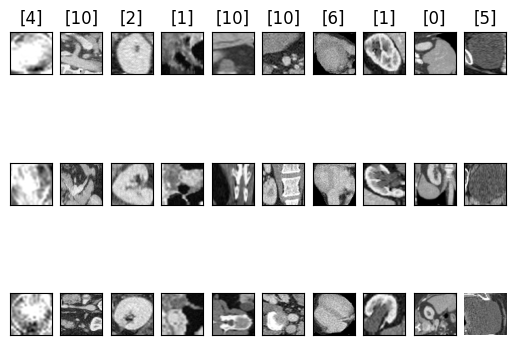

<Figure size 700x1500 with 0 Axes>

In [258]:
show_slice(train_dataset_, idx)

In [27]:
def montage(dataset, length=20, replace=False, save_folder='dataset', flag = 'axial'):
    from medmnist.utils import montage2d

    imgs = []

    n_sel = length * length
    sel = np.random.choice(dataset.__len__(), size=n_sel, replace=replace)
    
    if flag == 'axial':
        slice_ = 0
    elif flag == 'coronal':
        slice_ = 1
    else:
        slice_ = 2
    
    for idx in sel:
        imgs.append((dataset[idx]['images'][slice_]*255).astype(np.uint8))
        
    montage_img = montage2d(np.array(imgs)[:, 0],
                            n_channels=n_channels,
                            sel=range(0, n_sel))
    
    if save_folder is not None:
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)
        montage_img.save(os.path.join(save_folder,
                                        f"{data_flag}{flag}_montage.png"))

    return montage_img

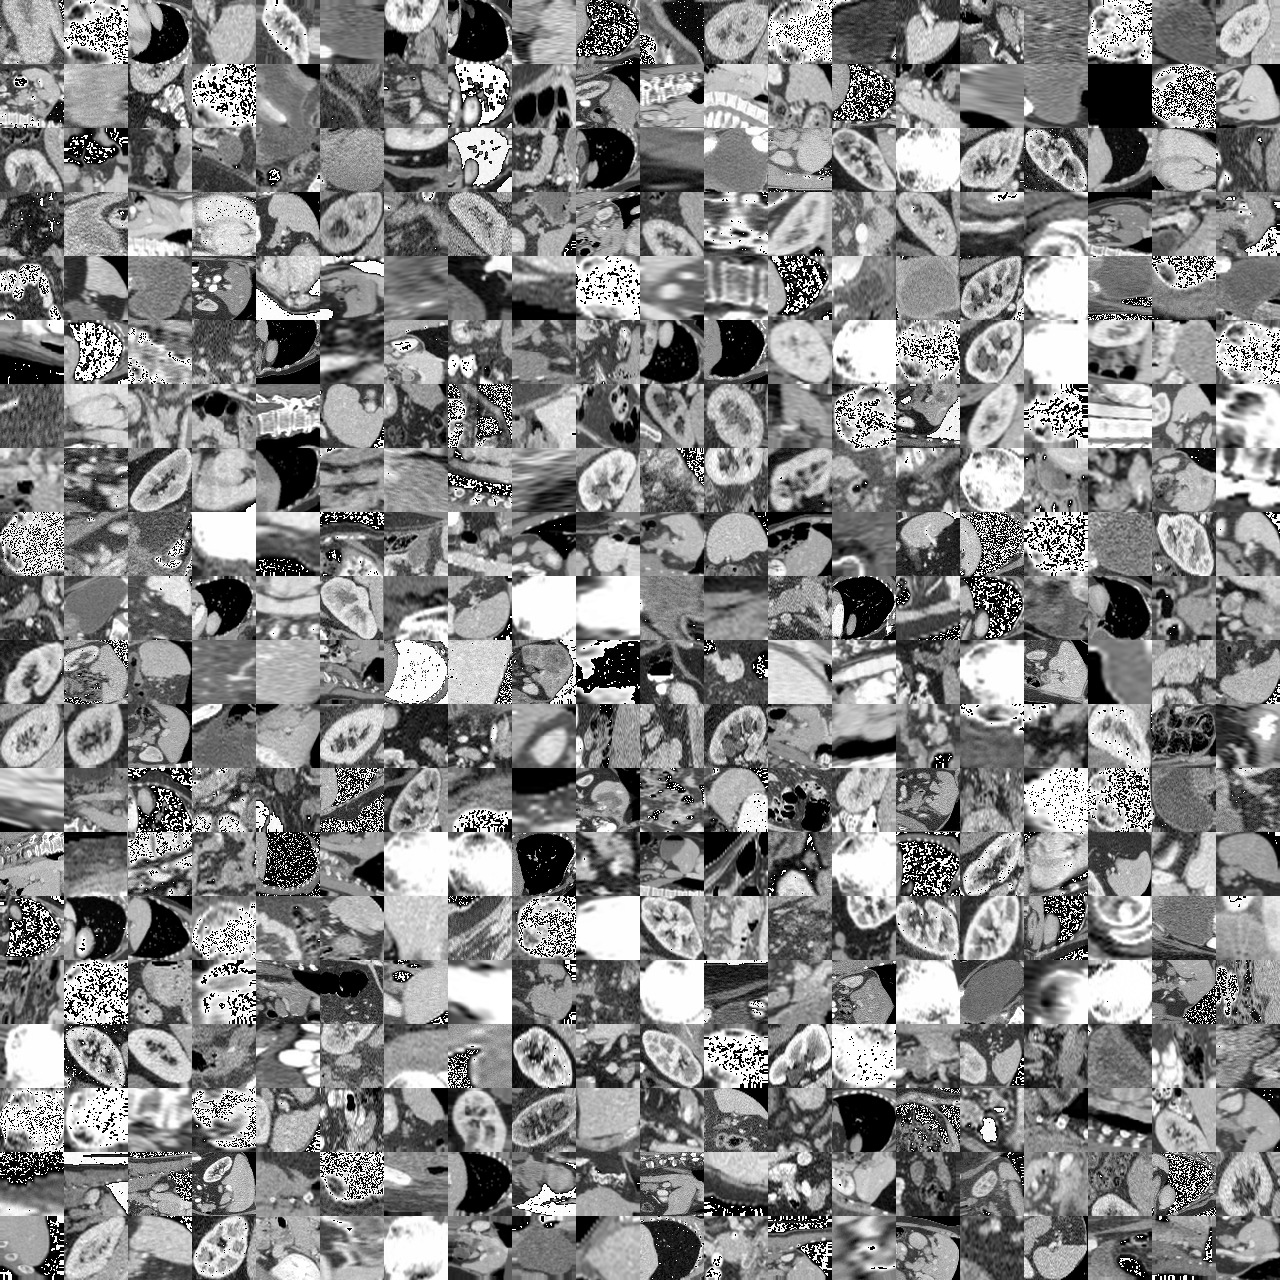

In [28]:
montage(train_dataset_, length=20, replace=False, flag = 'axial')

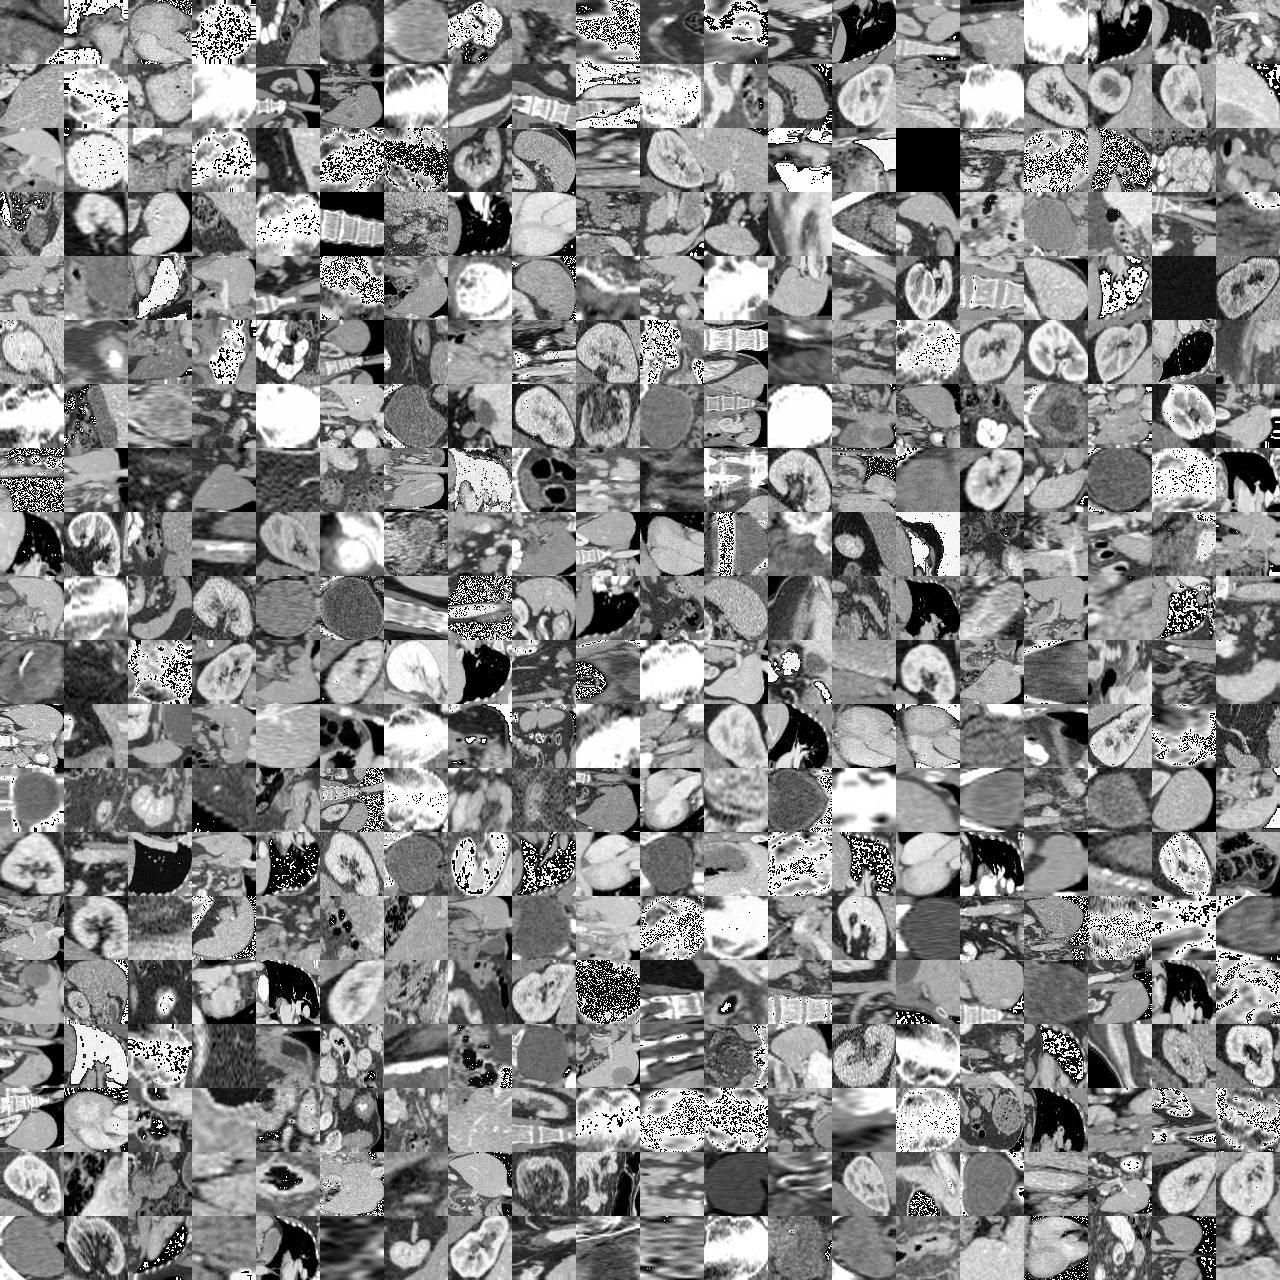

In [29]:
montage(train_dataset_, length=20, replace=False, flag = 'coronal')

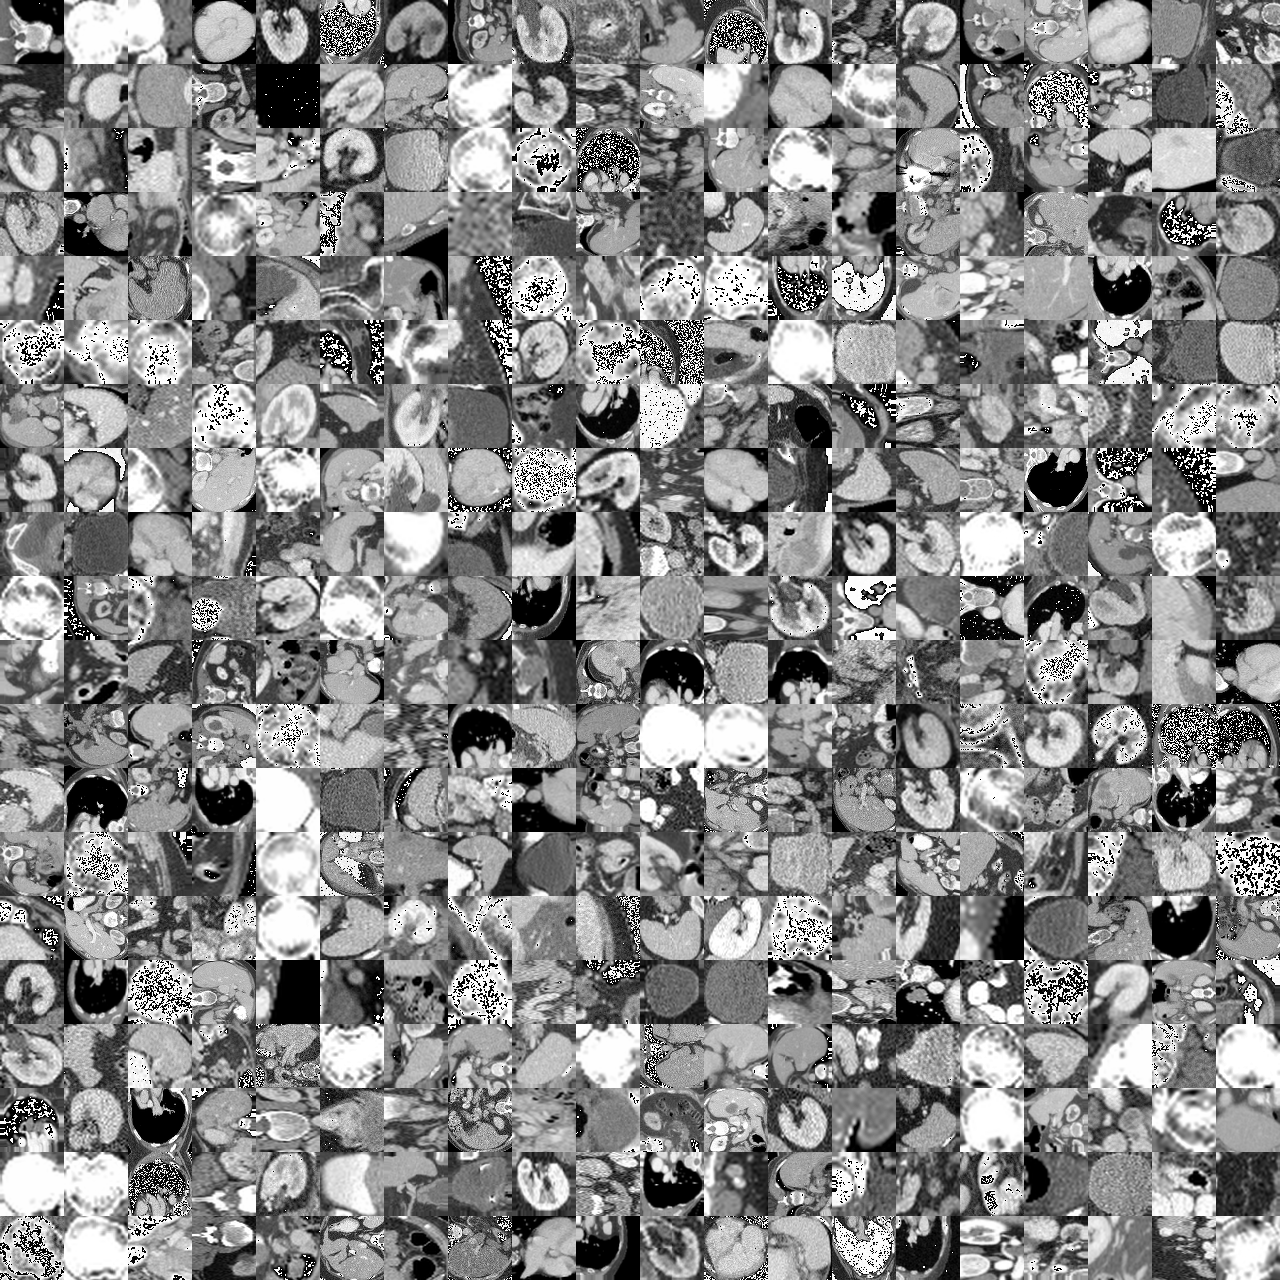

In [30]:
montage(train_dataset_, length=20, replace=False, flag = 'sagittal')

# Axial part

## Pretrained

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True).to(device)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model = model.to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(axial.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_axial.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_axial_pretrained.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

----------
epoch 1/100
epoch 1 average loss: 1.9846
1


Epochs:   1%|          | 1/100 [00:09<15:15,  9.25s/it]

saved new best metric model
current epoch: 1 current AUC: 0.9274 current accuracy: 0.5652 best AUC: 0.9274 at epoch: 1
----------
epoch 2/100
epoch 2 average loss: 1.1232
1


Epochs:   2%|▏         | 2/100 [00:17<13:41,  8.38s/it]

saved new best metric model
current epoch: 2 current AUC: 0.9788 current accuracy: 0.7950 best AUC: 0.9788 at epoch: 2
----------
epoch 3/100
epoch 3 average loss: 0.8245
1


Epochs:   3%|▎         | 3/100 [00:24<13:07,  8.12s/it]

saved new best metric model
current epoch: 3 current AUC: 0.9825 current accuracy: 0.8323 best AUC: 0.9825 at epoch: 3
----------
epoch 4/100
epoch 4 average loss: 0.6120
1


Epochs:   4%|▍         | 4/100 [00:32<12:46,  7.98s/it]

saved new best metric model
current epoch: 4 current AUC: 0.9872 current accuracy: 0.8571 best AUC: 0.9872 at epoch: 4
----------
epoch 5/100
epoch 5 average loss: 0.4865
1


Epochs:   5%|▌         | 5/100 [00:40<12:34,  7.94s/it]

saved new best metric model
current epoch: 5 current AUC: 0.9904 current accuracy: 0.8882 best AUC: 0.9904 at epoch: 5
----------
epoch 6/100
epoch 6 average loss: 0.4176
1


Epochs:   6%|▌         | 6/100 [00:51<13:49,  8.83s/it]

saved new best metric model
current epoch: 6 current AUC: 0.9930 current accuracy: 0.9068 best AUC: 0.9930 at epoch: 6
----------
epoch 7/100
epoch 7 average loss: 0.3403
1


Epochs:   7%|▋         | 7/100 [01:00<13:52,  8.95s/it]

saved new best metric model
current epoch: 7 current AUC: 0.9931 current accuracy: 0.9130 best AUC: 0.9931 at epoch: 7
----------
epoch 8/100
epoch 8 average loss: 0.2974
1


Epochs:   8%|▊         | 8/100 [01:08<13:21,  8.71s/it]

saved new best metric model
current epoch: 8 current AUC: 0.9937 current accuracy: 0.9193 best AUC: 0.9937 at epoch: 8
----------
epoch 9/100
epoch 9 average loss: 0.2350
1


Epochs:   9%|▉         | 9/100 [01:16<12:56,  8.53s/it]

saved new best metric model
current epoch: 9 current AUC: 0.9952 current accuracy: 0.9379 best AUC: 0.9952 at epoch: 9
----------
epoch 10/100
epoch 10 average loss: 0.2170


Epochs:  10%|█         | 10/100 [01:24<12:21,  8.23s/it]

1
current epoch: 10 current AUC: 0.9931 current accuracy: 0.9193 best AUC: 0.9952 at epoch: 9
----------
epoch 11/100
epoch 11 average loss: 0.1833
1


Epochs:  11%|█         | 11/100 [01:34<13:17,  8.96s/it]

saved new best metric model
current epoch: 11 current AUC: 0.9952 current accuracy: 0.9255 best AUC: 0.9952 at epoch: 11
----------
epoch 12/100
epoch 12 average loss: 0.1685


Epochs:  12%|█▏        | 12/100 [01:44<13:37,  9.29s/it]

1
current epoch: 12 current AUC: 0.9948 current accuracy: 0.9255 best AUC: 0.9952 at epoch: 11
----------
epoch 13/100
epoch 13 average loss: 0.1471
1


Epochs:  13%|█▎        | 13/100 [01:52<12:52,  8.88s/it]

saved new best metric model
current epoch: 13 current AUC: 0.9953 current accuracy: 0.9255 best AUC: 0.9953 at epoch: 13
----------
epoch 14/100
epoch 14 average loss: 0.1160


Epochs:  14%|█▍        | 14/100 [02:00<12:05,  8.43s/it]

1
current epoch: 14 current AUC: 0.9939 current accuracy: 0.9255 best AUC: 0.9953 at epoch: 13
----------
epoch 15/100
epoch 15 average loss: 0.0914


Epochs:  15%|█▌        | 15/100 [02:07<11:32,  8.15s/it]

1
current epoch: 15 current AUC: 0.9947 current accuracy: 0.9565 best AUC: 0.9953 at epoch: 13
----------
epoch 16/100
epoch 16 average loss: 0.0943
1


Epochs:  16%|█▌        | 16/100 [02:15<11:19,  8.09s/it]

saved new best metric model
current epoch: 16 current AUC: 0.9964 current accuracy: 0.9317 best AUC: 0.9964 at epoch: 16
----------
epoch 17/100
epoch 17 average loss: 0.0829
1


Epochs:  17%|█▋        | 17/100 [02:24<11:37,  8.40s/it]

saved new best metric model
current epoch: 17 current AUC: 0.9967 current accuracy: 0.9379 best AUC: 0.9967 at epoch: 17
----------
epoch 18/100
epoch 18 average loss: 0.1163
1


Epochs:  18%|█▊        | 18/100 [02:33<11:45,  8.60s/it]

saved new best metric model
current epoch: 18 current AUC: 0.9969 current accuracy: 0.9379 best AUC: 0.9969 at epoch: 18
----------
epoch 19/100
epoch 19 average loss: 0.0739


Epochs:  19%|█▉        | 19/100 [02:42<11:36,  8.59s/it]

1
current epoch: 19 current AUC: 0.9968 current accuracy: 0.9441 best AUC: 0.9969 at epoch: 18
----------
epoch 20/100
epoch 20 average loss: 0.0695


Epochs:  20%|██        | 20/100 [02:51<11:31,  8.64s/it]

1
current epoch: 20 current AUC: 0.9949 current accuracy: 0.9503 best AUC: 0.9969 at epoch: 18
----------
epoch 21/100
epoch 21 average loss: 0.0769
1


Epochs:  21%|██        | 21/100 [02:59<11:08,  8.47s/it]

saved new best metric model
current epoch: 21 current AUC: 0.9976 current accuracy: 0.9441 best AUC: 0.9976 at epoch: 21
----------
epoch 22/100
epoch 22 average loss: 0.0711


Epochs:  22%|██▏       | 22/100 [03:06<10:38,  8.18s/it]

1
current epoch: 22 current AUC: 0.9967 current accuracy: 0.9441 best AUC: 0.9976 at epoch: 21
----------
epoch 23/100
epoch 23 average loss: 0.0664
1


Epochs:  23%|██▎       | 23/100 [03:14<10:31,  8.20s/it]

saved new best metric model
current epoch: 23 current AUC: 0.9979 current accuracy: 0.9379 best AUC: 0.9979 at epoch: 23
----------
epoch 24/100
epoch 24 average loss: 0.0622
1


Epochs:  24%|██▍       | 24/100 [03:22<10:19,  8.16s/it]

saved new best metric model
current epoch: 24 current AUC: 0.9983 current accuracy: 0.9379 best AUC: 0.9983 at epoch: 24
----------
epoch 25/100
epoch 25 average loss: 0.0592


Epochs:  25%|██▌       | 25/100 [03:31<10:26,  8.35s/it]

1
current epoch: 25 current AUC: 0.9968 current accuracy: 0.9627 best AUC: 0.9983 at epoch: 24
----------
epoch 26/100
epoch 26 average loss: 0.0537


Epochs:  26%|██▌       | 26/100 [03:39<09:58,  8.08s/it]

1
current epoch: 26 current AUC: 0.9932 current accuracy: 0.9379 best AUC: 0.9983 at epoch: 24
----------
epoch 27/100
epoch 27 average loss: 0.0477


Epochs:  27%|██▋       | 27/100 [03:49<10:32,  8.67s/it]

1
current epoch: 27 current AUC: 0.9964 current accuracy: 0.9441 best AUC: 0.9983 at epoch: 24
----------
epoch 28/100
epoch 28 average loss: 0.0390


Epochs:  28%|██▊       | 28/100 [03:57<10:14,  8.53s/it]

1
current epoch: 28 current AUC: 0.9979 current accuracy: 0.9627 best AUC: 0.9983 at epoch: 24
----------
epoch 29/100
epoch 29 average loss: 0.0398
1


Epochs:  29%|██▉       | 29/100 [04:06<10:22,  8.76s/it]

saved new best metric model
current epoch: 29 current AUC: 0.9987 current accuracy: 0.9565 best AUC: 0.9987 at epoch: 29
----------
epoch 30/100
epoch 30 average loss: 0.0469


Epochs:  30%|███       | 30/100 [04:14<09:47,  8.40s/it]

1
current epoch: 30 current AUC: 0.9987 current accuracy: 0.9441 best AUC: 0.9987 at epoch: 29
----------
epoch 31/100
epoch 31 average loss: 0.0316


Epochs:  31%|███       | 31/100 [04:21<09:19,  8.11s/it]

1
current epoch: 31 current AUC: 0.9978 current accuracy: 0.9441 best AUC: 0.9987 at epoch: 29
----------
epoch 32/100
epoch 32 average loss: 0.0415


Epochs:  32%|███▏      | 32/100 [04:29<08:57,  7.90s/it]

1
current epoch: 32 current AUC: 0.9962 current accuracy: 0.9565 best AUC: 0.9987 at epoch: 29
----------
epoch 33/100
epoch 33 average loss: 0.0286


Epochs:  33%|███▎      | 33/100 [04:37<09:06,  8.16s/it]

1
current epoch: 33 current AUC: 0.9968 current accuracy: 0.9565 best AUC: 0.9987 at epoch: 29
----------
epoch 34/100
epoch 34 average loss: 0.0313


Epochs:  34%|███▍      | 34/100 [04:45<08:50,  8.03s/it]

1
current epoch: 34 current AUC: 0.9965 current accuracy: 0.9565 best AUC: 0.9987 at epoch: 29
----------
epoch 35/100
epoch 35 average loss: 0.0385


Epochs:  35%|███▌      | 35/100 [04:53<08:30,  7.86s/it]

1
current epoch: 35 current AUC: 0.9964 current accuracy: 0.9565 best AUC: 0.9987 at epoch: 29
----------
epoch 36/100
epoch 36 average loss: 0.0375


Epochs:  36%|███▌      | 36/100 [05:00<08:17,  7.77s/it]

1
current epoch: 36 current AUC: 0.9970 current accuracy: 0.9627 best AUC: 0.9987 at epoch: 29
----------
epoch 37/100
epoch 37 average loss: 0.0387


Epochs:  37%|███▋      | 37/100 [05:09<08:35,  8.18s/it]

1
current epoch: 37 current AUC: 0.9973 current accuracy: 0.9689 best AUC: 0.9987 at epoch: 29
----------
epoch 38/100
epoch 38 average loss: 0.0413


Epochs:  38%|███▊      | 38/100 [05:17<08:14,  7.97s/it]

1
current epoch: 38 current AUC: 0.9970 current accuracy: 0.9503 best AUC: 0.9987 at epoch: 29
----------
epoch 39/100
epoch 39 average loss: 0.0301


Epochs:  39%|███▉      | 39/100 [05:24<07:55,  7.80s/it]

1
current epoch: 39 current AUC: 0.9976 current accuracy: 0.9627 best AUC: 0.9987 at epoch: 29
----------
epoch 40/100
epoch 40 average loss: 0.0494


Epochs:  40%|████      | 40/100 [05:32<07:40,  7.68s/it]

1
current epoch: 40 current AUC: 0.9982 current accuracy: 0.9689 best AUC: 0.9987 at epoch: 29
----------
epoch 41/100
epoch 41 average loss: 0.0223


Epochs:  41%|████      | 41/100 [05:39<07:28,  7.61s/it]

1
current epoch: 41 current AUC: 0.9980 current accuracy: 0.9627 best AUC: 0.9987 at epoch: 29
----------
epoch 42/100
epoch 42 average loss: 0.0213


Epochs:  42%|████▏     | 42/100 [05:46<07:16,  7.53s/it]

1
current epoch: 42 current AUC: 0.9981 current accuracy: 0.9689 best AUC: 0.9987 at epoch: 29
----------
epoch 43/100
epoch 43 average loss: 0.0282


Epochs:  43%|████▎     | 43/100 [05:54<07:07,  7.50s/it]

1
current epoch: 43 current AUC: 0.9980 current accuracy: 0.9752 best AUC: 0.9987 at epoch: 29
----------
epoch 44/100
epoch 44 average loss: 0.0310


Epochs:  44%|████▍     | 44/100 [06:01<06:59,  7.48s/it]

1
current epoch: 44 current AUC: 0.9978 current accuracy: 0.9689 best AUC: 0.9987 at epoch: 29
----------
epoch 45/100
epoch 45 average loss: 0.0218


Epochs:  45%|████▌     | 45/100 [06:09<06:50,  7.47s/it]

1
current epoch: 45 current AUC: 0.9980 current accuracy: 0.9379 best AUC: 0.9987 at epoch: 29
----------
epoch 46/100
epoch 46 average loss: 0.0205


Epochs:  46%|████▌     | 46/100 [06:16<06:42,  7.45s/it]

1
current epoch: 46 current AUC: 0.9977 current accuracy: 0.9441 best AUC: 0.9987 at epoch: 29
----------
epoch 47/100
epoch 47 average loss: 0.0224


Epochs:  47%|████▋     | 47/100 [06:24<06:33,  7.43s/it]

1
current epoch: 47 current AUC: 0.9974 current accuracy: 0.9565 best AUC: 0.9987 at epoch: 29
----------
epoch 48/100
epoch 48 average loss: 0.0164


Epochs:  48%|████▊     | 48/100 [06:31<06:28,  7.47s/it]

1
current epoch: 48 current AUC: 0.9968 current accuracy: 0.9441 best AUC: 0.9987 at epoch: 29
----------
epoch 49/100
epoch 49 average loss: 0.0230


Epochs:  49%|████▉     | 49/100 [06:39<06:22,  7.51s/it]

1
current epoch: 49 current AUC: 0.9967 current accuracy: 0.9503 best AUC: 0.9987 at epoch: 29
----------
epoch 50/100
epoch 50 average loss: 0.0188


Epochs:  50%|█████     | 50/100 [06:46<06:14,  7.50s/it]

1
current epoch: 50 current AUC: 0.9967 current accuracy: 0.9565 best AUC: 0.9987 at epoch: 29
----------
epoch 51/100
epoch 51 average loss: 0.0164


Epochs:  51%|█████     | 51/100 [06:54<06:07,  7.49s/it]

1
current epoch: 51 current AUC: 0.9961 current accuracy: 0.9627 best AUC: 0.9987 at epoch: 29
----------
epoch 52/100
epoch 52 average loss: 0.0147


Epochs:  52%|█████▏    | 52/100 [07:01<05:59,  7.50s/it]

1
current epoch: 52 current AUC: 0.9969 current accuracy: 0.9565 best AUC: 0.9987 at epoch: 29
----------
epoch 53/100
epoch 53 average loss: 0.0128


Epochs:  53%|█████▎    | 53/100 [07:09<05:51,  7.47s/it]

1
current epoch: 53 current AUC: 0.9963 current accuracy: 0.9503 best AUC: 0.9987 at epoch: 29
----------
epoch 54/100
epoch 54 average loss: 0.0191


Epochs:  54%|█████▍    | 54/100 [07:16<05:42,  7.44s/it]

1
current epoch: 54 current AUC: 0.9960 current accuracy: 0.9627 best AUC: 0.9987 at epoch: 29
----------
epoch 55/100
epoch 55 average loss: 0.0205


Epochs:  55%|█████▌    | 55/100 [07:23<05:33,  7.40s/it]

1
current epoch: 55 current AUC: 0.9958 current accuracy: 0.9503 best AUC: 0.9987 at epoch: 29
----------
epoch 56/100
epoch 56 average loss: 0.0186


Epochs:  56%|█████▌    | 56/100 [07:31<05:27,  7.43s/it]

1
current epoch: 56 current AUC: 0.9950 current accuracy: 0.9503 best AUC: 0.9987 at epoch: 29
----------
epoch 57/100
epoch 57 average loss: 0.0108


Epochs:  57%|█████▋    | 57/100 [07:38<05:19,  7.43s/it]

1
current epoch: 57 current AUC: 0.9948 current accuracy: 0.9627 best AUC: 0.9987 at epoch: 29
----------
epoch 58/100
epoch 58 average loss: 0.0127


Epochs:  58%|█████▊    | 58/100 [07:46<05:11,  7.43s/it]

1
current epoch: 58 current AUC: 0.9951 current accuracy: 0.9627 best AUC: 0.9987 at epoch: 29
----------
epoch 59/100
epoch 59 average loss: 0.0233


Epochs:  59%|█████▉    | 59/100 [07:53<05:04,  7.44s/it]

1
current epoch: 59 current AUC: 0.9937 current accuracy: 0.9565 best AUC: 0.9987 at epoch: 29
----------
epoch 60/100
epoch 60 average loss: 0.0198


Epochs:  60%|██████    | 60/100 [08:00<04:57,  7.44s/it]

1
current epoch: 60 current AUC: 0.9956 current accuracy: 0.9503 best AUC: 0.9987 at epoch: 29
----------
epoch 61/100
epoch 61 average loss: 0.0211


Epochs:  61%|██████    | 61/100 [08:08<04:50,  7.46s/it]

1
current epoch: 61 current AUC: 0.9948 current accuracy: 0.9441 best AUC: 0.9987 at epoch: 29
----------
epoch 62/100
epoch 62 average loss: 0.0097


Epochs:  62%|██████▏   | 62/100 [08:15<04:43,  7.47s/it]

1
current epoch: 62 current AUC: 0.9971 current accuracy: 0.9627 best AUC: 0.9987 at epoch: 29
----------
epoch 63/100
epoch 63 average loss: 0.0144


Epochs:  63%|██████▎   | 63/100 [08:23<04:36,  7.47s/it]

1
current epoch: 63 current AUC: 0.9960 current accuracy: 0.9627 best AUC: 0.9987 at epoch: 29
----------
epoch 64/100
epoch 64 average loss: 0.0129


Epochs:  64%|██████▍   | 64/100 [08:32<04:43,  7.86s/it]

1
current epoch: 64 current AUC: 0.9956 current accuracy: 0.9503 best AUC: 0.9987 at epoch: 29
----------
epoch 65/100
epoch 65 average loss: 0.0102


Epochs:  65%|██████▌   | 65/100 [08:41<04:45,  8.14s/it]

1
current epoch: 65 current AUC: 0.9945 current accuracy: 0.9503 best AUC: 0.9987 at epoch: 29
----------
epoch 66/100
epoch 66 average loss: 0.0145


Epochs:  66%|██████▌   | 66/100 [08:50<04:51,  8.57s/it]

1
current epoch: 66 current AUC: 0.9951 current accuracy: 0.9441 best AUC: 0.9987 at epoch: 29
----------
epoch 67/100
epoch 67 average loss: 0.0159


Epochs:  67%|██████▋   | 67/100 [08:58<04:40,  8.49s/it]

1
current epoch: 67 current AUC: 0.9961 current accuracy: 0.9627 best AUC: 0.9987 at epoch: 29
----------
epoch 68/100
epoch 68 average loss: 0.0178


Epochs:  68%|██████▊   | 68/100 [09:08<04:38,  8.70s/it]

1
current epoch: 68 current AUC: 0.9961 current accuracy: 0.9441 best AUC: 0.9987 at epoch: 29
----------
epoch 69/100
epoch 69 average loss: 0.0400


Epochs:  69%|██████▉   | 69/100 [09:15<04:17,  8.32s/it]

1
current epoch: 69 current AUC: 0.9958 current accuracy: 0.9565 best AUC: 0.9987 at epoch: 29
----------
epoch 70/100
epoch 70 average loss: 0.0158


Epochs:  70%|███████   | 70/100 [09:22<04:01,  8.04s/it]

1
current epoch: 70 current AUC: 0.9945 current accuracy: 0.9565 best AUC: 0.9987 at epoch: 29
----------
epoch 71/100
epoch 71 average loss: 0.0244


Epochs:  71%|███████   | 71/100 [09:31<03:54,  8.08s/it]

1
current epoch: 71 current AUC: 0.9965 current accuracy: 0.9503 best AUC: 0.9987 at epoch: 29
----------
epoch 72/100
epoch 72 average loss: 0.0228


Epochs:  72%|███████▏  | 72/100 [09:38<03:43,  7.97s/it]

1
current epoch: 72 current AUC: 0.9967 current accuracy: 0.9503 best AUC: 0.9987 at epoch: 29
----------
epoch 73/100
epoch 73 average loss: 0.0083


Epochs:  73%|███████▎  | 73/100 [09:46<03:32,  7.86s/it]

1
current epoch: 73 current AUC: 0.9977 current accuracy: 0.9627 best AUC: 0.9987 at epoch: 29
----------
epoch 74/100
epoch 74 average loss: 0.0294


Epochs:  74%|███████▍  | 74/100 [09:55<03:32,  8.18s/it]

1
current epoch: 74 current AUC: 0.9966 current accuracy: 0.9627 best AUC: 0.9987 at epoch: 29
----------
epoch 75/100
epoch 75 average loss: 0.0354


Epochs:  75%|███████▌  | 75/100 [10:03<03:20,  8.03s/it]

1
current epoch: 75 current AUC: 0.9981 current accuracy: 0.9565 best AUC: 0.9987 at epoch: 29
----------
epoch 76/100
epoch 76 average loss: 0.0183


Epochs:  76%|███████▌  | 76/100 [10:12<03:24,  8.50s/it]

1
current epoch: 76 current AUC: 0.9979 current accuracy: 0.9565 best AUC: 0.9987 at epoch: 29
----------
epoch 77/100
epoch 77 average loss: 0.0175


Epochs:  77%|███████▋  | 77/100 [10:20<03:11,  8.33s/it]

1
current epoch: 77 current AUC: 0.9978 current accuracy: 0.9503 best AUC: 0.9987 at epoch: 29
----------
epoch 78/100
epoch 78 average loss: 0.0191


Epochs:  78%|███████▊  | 78/100 [10:28<02:57,  8.09s/it]

1
current epoch: 78 current AUC: 0.9979 current accuracy: 0.9503 best AUC: 0.9987 at epoch: 29
----------
epoch 79/100
epoch 79 average loss: 0.0100


Epochs:  79%|███████▉  | 79/100 [10:35<02:46,  7.91s/it]

1
current epoch: 79 current AUC: 0.9974 current accuracy: 0.9565 best AUC: 0.9987 at epoch: 29
----------
epoch 80/100
epoch 80 average loss: 0.0186


Epochs:  80%|████████  | 80/100 [10:42<02:35,  7.77s/it]

1
current epoch: 80 current AUC: 0.9963 current accuracy: 0.9627 best AUC: 0.9987 at epoch: 29
----------
epoch 81/100
epoch 81 average loss: 0.0163


Epochs:  81%|████████  | 81/100 [10:50<02:26,  7.69s/it]

1
current epoch: 81 current AUC: 0.9971 current accuracy: 0.9565 best AUC: 0.9987 at epoch: 29
----------
epoch 82/100
epoch 82 average loss: 0.0244


Epochs:  82%|████████▏ | 82/100 [10:58<02:17,  7.64s/it]

1
current epoch: 82 current AUC: 0.9950 current accuracy: 0.9565 best AUC: 0.9987 at epoch: 29
----------
epoch 83/100
epoch 83 average loss: 0.0133


Epochs:  83%|████████▎ | 83/100 [11:06<02:15,  7.96s/it]

1
current epoch: 83 current AUC: 0.9946 current accuracy: 0.9503 best AUC: 0.9987 at epoch: 29
----------
epoch 84/100
epoch 84 average loss: 0.0104


Epochs:  84%|████████▍ | 84/100 [11:14<02:05,  7.86s/it]

1
current epoch: 84 current AUC: 0.9966 current accuracy: 0.9503 best AUC: 0.9987 at epoch: 29
----------
epoch 85/100
epoch 85 average loss: 0.0204


Epochs:  85%|████████▌ | 85/100 [11:22<02:01,  8.07s/it]

1
current epoch: 85 current AUC: 0.9975 current accuracy: 0.9441 best AUC: 0.9987 at epoch: 29
----------
epoch 86/100
epoch 86 average loss: 0.0228


Epochs:  86%|████████▌ | 86/100 [11:30<01:50,  7.88s/it]

1
current epoch: 86 current AUC: 0.9962 current accuracy: 0.9379 best AUC: 0.9987 at epoch: 29
----------
epoch 87/100
epoch 87 average loss: 0.0127


Epochs:  87%|████████▋ | 87/100 [11:37<01:40,  7.75s/it]

1
current epoch: 87 current AUC: 0.9979 current accuracy: 0.9565 best AUC: 0.9987 at epoch: 29
----------
epoch 88/100
epoch 88 average loss: 0.0122


Epochs:  88%|████████▊ | 88/100 [11:45<01:31,  7.66s/it]

1
current epoch: 88 current AUC: 0.9977 current accuracy: 0.9503 best AUC: 0.9987 at epoch: 29
----------
epoch 89/100
epoch 89 average loss: 0.0092


Epochs:  89%|████████▉ | 89/100 [11:52<01:23,  7.57s/it]

1
current epoch: 89 current AUC: 0.9974 current accuracy: 0.9379 best AUC: 0.9987 at epoch: 29
----------
epoch 90/100
epoch 90 average loss: 0.0090


Epochs:  90%|█████████ | 90/100 [12:00<01:15,  7.59s/it]

1
current epoch: 90 current AUC: 0.9971 current accuracy: 0.9379 best AUC: 0.9987 at epoch: 29
----------
epoch 91/100
epoch 91 average loss: 0.0070


Epochs:  91%|█████████ | 91/100 [12:09<01:11,  7.94s/it]

1
current epoch: 91 current AUC: 0.9957 current accuracy: 0.9441 best AUC: 0.9987 at epoch: 29
----------
epoch 92/100
epoch 92 average loss: 0.0129


Epochs:  92%|█████████▏| 92/100 [12:18<01:08,  8.52s/it]

1
current epoch: 92 current AUC: 0.9986 current accuracy: 0.9503 best AUC: 0.9987 at epoch: 29
----------
epoch 93/100
epoch 93 average loss: 0.0174


Epochs:  93%|█████████▎| 93/100 [12:26<00:57,  8.23s/it]

1
current epoch: 93 current AUC: 0.9967 current accuracy: 0.9441 best AUC: 0.9987 at epoch: 29
----------
epoch 94/100
epoch 94 average loss: 0.0232


Epochs:  94%|█████████▍| 94/100 [12:34<00:48,  8.04s/it]

1
current epoch: 94 current AUC: 0.9959 current accuracy: 0.9379 best AUC: 0.9987 at epoch: 29
----------
epoch 95/100
epoch 95 average loss: 0.0164


Epochs:  95%|█████████▌| 95/100 [12:41<00:39,  7.92s/it]

1
current epoch: 95 current AUC: 0.9934 current accuracy: 0.9255 best AUC: 0.9987 at epoch: 29
----------
epoch 96/100
epoch 96 average loss: 0.0218


Epochs:  96%|█████████▌| 96/100 [12:49<00:31,  7.80s/it]

1
current epoch: 96 current AUC: 0.9971 current accuracy: 0.9441 best AUC: 0.9987 at epoch: 29
----------
epoch 97/100
epoch 97 average loss: 0.0107


Epochs:  97%|█████████▋| 97/100 [12:56<00:23,  7.72s/it]

1
current epoch: 97 current AUC: 0.9964 current accuracy: 0.9565 best AUC: 0.9987 at epoch: 29
----------
epoch 98/100
epoch 98 average loss: 0.0188


Epochs:  98%|█████████▊| 98/100 [13:04<00:15,  7.67s/it]

1
current epoch: 98 current AUC: 0.9980 current accuracy: 0.9627 best AUC: 0.9987 at epoch: 29
----------
epoch 99/100
epoch 99 average loss: 0.0102


Epochs:  99%|█████████▉| 99/100 [13:11<00:07,  7.65s/it]

1
current epoch: 99 current AUC: 0.9970 current accuracy: 0.9441 best AUC: 0.9987 at epoch: 29
----------
epoch 100/100
epoch 100 average loss: 0.0067


Epochs: 100%|██████████| 100/100 [13:19<00:00,  7.99s/it]

1
current epoch: 100 current AUC: 0.9971 current accuracy: 0.9503 best AUC: 0.9987 at epoch: 29
train completed, best_metric: 0.9987 at epoch: 29


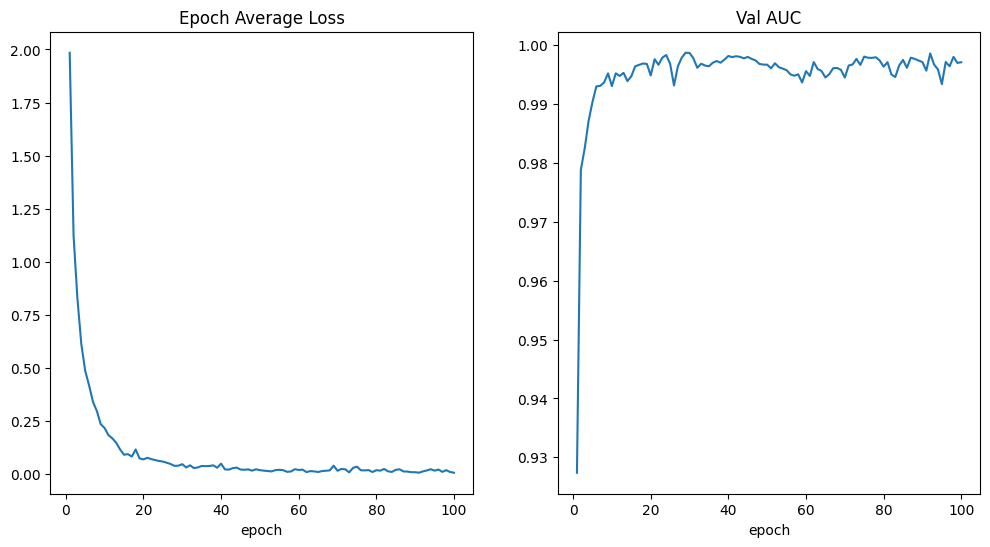

In [14]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluation

In [15]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_axial_pretrained.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [16]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9452    1.0000    0.9718        69
           1     0.7143    0.6618    0.6870        68
           2     0.6780    0.5797    0.6250        69
           3     0.7679    0.6615    0.7107        65
           4     0.6957    0.7385    0.7164        65
           5     0.8857    0.9394    0.9118        66
           6     0.9200    0.8214    0.8679        28
           7     0.9130    1.0000    0.9545        21
           8     1.0000    0.9524    0.9756        21
           9     0.7875    0.9130    0.8456        69
          10     0.9028    0.9420    0.9220        69

    accuracy                         0.8180       610
   macro avg     0.8373    0.8373    0.8353       610
weighted avg     0.8143    0.8180    0.8142       610



## Unpretrained

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=3, num_classes=n_classes).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

In [18]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(axial.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_dataset) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_axial.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_axial.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

----------
epoch 1/100
1/30, train_loss: 2.5024
2/30, train_loss: 2.5442
3/30, train_loss: 2.4555
4/30, train_loss: 2.2617
5/30, train_loss: 2.3208
6/30, train_loss: 2.3525
7/30, train_loss: 2.1950
8/30, train_loss: 2.2700
9/30, train_loss: 2.2246
10/30, train_loss: 2.2405
11/30, train_loss: 2.1685
12/30, train_loss: 1.9180
13/30, train_loss: 1.9275
14/30, train_loss: 1.8695
15/30, train_loss: 2.0318
16/30, train_loss: 1.8701
17/30, train_loss: 1.6471
18/30, train_loss: 2.0728
19/30, train_loss: 2.0863
20/30, train_loss: 1.9716
21/30, train_loss: 2.1494
22/30, train_loss: 1.8430
23/30, train_loss: 1.9183
24/30, train_loss: 1.8043
25/30, train_loss: 1.9574
26/30, train_loss: 1.8458
27/30, train_loss: 1.8239
28/30, train_loss: 1.5331
29/30, train_loss: 1.9948
30/30, train_loss: 1.6852
31/30, train_loss: 1.6773
epoch 1 average loss: 2.0375
1


Epochs:   1%|          | 1/100 [00:08<13:56,  8.45s/it]

saved new best metric model
current epoch: 1 current AUC: 0.5778 current accuracy: 0.0932 best AUC: 0.5778 at epoch: 1
----------
epoch 2/100
1/30, train_loss: 1.5093
2/30, train_loss: 1.7377
3/30, train_loss: 1.6294
4/30, train_loss: 1.6623
5/30, train_loss: 1.7504
6/30, train_loss: 1.5814
7/30, train_loss: 1.6380
8/30, train_loss: 1.6047
9/30, train_loss: 1.6412
10/30, train_loss: 1.7176
11/30, train_loss: 1.5704
12/30, train_loss: 1.5672
13/30, train_loss: 1.4122
14/30, train_loss: 1.6974
15/30, train_loss: 1.2770
16/30, train_loss: 1.5339
17/30, train_loss: 1.3649
18/30, train_loss: 1.3805
19/30, train_loss: 1.5233
20/30, train_loss: 1.6245
21/30, train_loss: 1.5218
22/30, train_loss: 1.6262
23/30, train_loss: 1.5670
24/30, train_loss: 1.4714
25/30, train_loss: 1.5568
26/30, train_loss: 1.4434
27/30, train_loss: 1.2397
28/30, train_loss: 1.3244
29/30, train_loss: 1.3384
30/30, train_loss: 1.4612
31/30, train_loss: 1.3637
epoch 2 average loss: 1.5270
1


Epochs:   2%|▏         | 2/100 [00:17<14:02,  8.59s/it]

saved new best metric model
current epoch: 2 current AUC: 0.9588 current accuracy: 0.5093 best AUC: 0.9588 at epoch: 2
----------
epoch 3/100
1/30, train_loss: 1.3171
2/30, train_loss: 1.3789
3/30, train_loss: 1.5910
4/30, train_loss: 1.5315
5/30, train_loss: 1.2471
6/30, train_loss: 1.2045
7/30, train_loss: 1.0999
8/30, train_loss: 1.3602
9/30, train_loss: 1.3974
10/30, train_loss: 1.1741
11/30, train_loss: 1.2012
12/30, train_loss: 1.4568
13/30, train_loss: 1.4061
14/30, train_loss: 1.3294
15/30, train_loss: 1.4460
16/30, train_loss: 1.1792
17/30, train_loss: 1.1722
18/30, train_loss: 1.3381
19/30, train_loss: 1.1501
20/30, train_loss: 1.4484
21/30, train_loss: 1.4555
22/30, train_loss: 1.1100
23/30, train_loss: 1.5594
24/30, train_loss: 1.2437
25/30, train_loss: 1.1567
26/30, train_loss: 1.1812
27/30, train_loss: 1.2247
28/30, train_loss: 1.0067
29/30, train_loss: 0.8921
30/30, train_loss: 1.4256
31/30, train_loss: 1.4324
epoch 3 average loss: 1.2941
1


Epochs:   3%|▎         | 3/100 [00:27<14:51,  9.19s/it]

saved new best metric model
current epoch: 3 current AUC: 0.9747 current accuracy: 0.6708 best AUC: 0.9747 at epoch: 3
----------
epoch 4/100
1/30, train_loss: 1.0225
2/30, train_loss: 1.1030
3/30, train_loss: 1.2526
4/30, train_loss: 1.1608
5/30, train_loss: 1.0692
6/30, train_loss: 1.1027
7/30, train_loss: 0.9966
8/30, train_loss: 0.9448
9/30, train_loss: 0.9853
10/30, train_loss: 1.0090
11/30, train_loss: 1.0838
12/30, train_loss: 1.0589
13/30, train_loss: 1.0202
14/30, train_loss: 1.0178
15/30, train_loss: 0.8918
16/30, train_loss: 0.9209
17/30, train_loss: 1.1162
18/30, train_loss: 1.0846
19/30, train_loss: 1.0664
20/30, train_loss: 1.2178
21/30, train_loss: 1.2778
22/30, train_loss: 1.0798
23/30, train_loss: 0.8765
24/30, train_loss: 1.2548
25/30, train_loss: 1.1719
26/30, train_loss: 1.0745
27/30, train_loss: 1.2105
28/30, train_loss: 0.9641
29/30, train_loss: 1.0372
30/30, train_loss: 0.9170
31/30, train_loss: 0.8856
epoch 4 average loss: 1.0605
1


Epochs:   4%|▍         | 4/100 [00:36<14:44,  9.21s/it]

saved new best metric model
current epoch: 4 current AUC: 0.9765 current accuracy: 0.7391 best AUC: 0.9765 at epoch: 4
----------
epoch 5/100
1/30, train_loss: 1.0217
2/30, train_loss: 0.9881
3/30, train_loss: 1.1669
4/30, train_loss: 1.2422
5/30, train_loss: 1.0580
6/30, train_loss: 0.9182
7/30, train_loss: 1.0554
8/30, train_loss: 1.0135
9/30, train_loss: 1.0287
10/30, train_loss: 1.0722
11/30, train_loss: 0.9722
12/30, train_loss: 0.7262
13/30, train_loss: 0.8061
14/30, train_loss: 1.0185
15/30, train_loss: 0.8585
16/30, train_loss: 0.7364
17/30, train_loss: 1.0725
18/30, train_loss: 1.0414
19/30, train_loss: 0.8319
20/30, train_loss: 0.6366
21/30, train_loss: 0.7439
22/30, train_loss: 0.7722
23/30, train_loss: 0.7929
24/30, train_loss: 0.8079
25/30, train_loss: 1.1313
26/30, train_loss: 0.6478
27/30, train_loss: 0.9092
28/30, train_loss: 0.9447
29/30, train_loss: 0.7606
30/30, train_loss: 0.8721
31/30, train_loss: 0.7998
epoch 5 average loss: 0.9177
1


Epochs:   5%|▌         | 5/100 [00:45<14:27,  9.13s/it]

saved new best metric model
current epoch: 5 current AUC: 0.9885 current accuracy: 0.7640 best AUC: 0.9885 at epoch: 5
----------
epoch 6/100
1/30, train_loss: 0.9347
2/30, train_loss: 0.8640
3/30, train_loss: 0.8022
4/30, train_loss: 0.7462
5/30, train_loss: 0.7831
6/30, train_loss: 0.8146
7/30, train_loss: 0.8734
8/30, train_loss: 1.2307
9/30, train_loss: 0.9816
10/30, train_loss: 0.8598
11/30, train_loss: 0.6317
12/30, train_loss: 0.8571
13/30, train_loss: 0.7222
14/30, train_loss: 1.5236
15/30, train_loss: 0.6647
16/30, train_loss: 0.6334
17/30, train_loss: 1.0002
18/30, train_loss: 0.6562
19/30, train_loss: 0.7379
20/30, train_loss: 0.9166
21/30, train_loss: 0.7959
22/30, train_loss: 0.6931
23/30, train_loss: 0.7798
24/30, train_loss: 0.6885
25/30, train_loss: 0.8116
26/30, train_loss: 0.7255
27/30, train_loss: 0.6196
28/30, train_loss: 0.8836
29/30, train_loss: 0.7354
30/30, train_loss: 0.6615
31/30, train_loss: 0.5423
epoch 6 average loss: 0.8120
1


Epochs:   6%|▌         | 6/100 [00:54<14:31,  9.27s/it]

saved new best metric model
current epoch: 6 current AUC: 0.9940 current accuracy: 0.8012 best AUC: 0.9940 at epoch: 6
----------
epoch 7/100
1/30, train_loss: 0.6951
2/30, train_loss: 0.8041
3/30, train_loss: 0.6904
4/30, train_loss: 0.4584
5/30, train_loss: 0.8298
6/30, train_loss: 0.5718
7/30, train_loss: 0.6418
8/30, train_loss: 0.7912
9/30, train_loss: 0.9436
10/30, train_loss: 0.7852
11/30, train_loss: 0.6735
12/30, train_loss: 1.0905
13/30, train_loss: 0.7315
14/30, train_loss: 0.8118
15/30, train_loss: 0.6707
16/30, train_loss: 0.9819
17/30, train_loss: 0.5627
18/30, train_loss: 0.6590
19/30, train_loss: 0.7176
20/30, train_loss: 0.6622
21/30, train_loss: 0.5216
22/30, train_loss: 0.5028
23/30, train_loss: 0.8953
24/30, train_loss: 0.5753
25/30, train_loss: 0.5098
26/30, train_loss: 0.6353
27/30, train_loss: 0.6874
28/30, train_loss: 0.7969
29/30, train_loss: 0.7278
30/30, train_loss: 0.6726
31/30, train_loss: 1.2165
epoch 7 average loss: 0.7262


Epochs:   7%|▋         | 7/100 [01:03<14:18,  9.23s/it]

1
current epoch: 7 current AUC: 0.9857 current accuracy: 0.7578 best AUC: 0.9940 at epoch: 6
----------
epoch 8/100
1/30, train_loss: 0.7340
2/30, train_loss: 0.6492
3/30, train_loss: 0.5573
4/30, train_loss: 0.8429
5/30, train_loss: 0.7452
6/30, train_loss: 0.7082
7/30, train_loss: 0.4563
8/30, train_loss: 1.0390
9/30, train_loss: 0.7661
10/30, train_loss: 0.6237
11/30, train_loss: 0.7961
12/30, train_loss: 0.6054
13/30, train_loss: 0.7257
14/30, train_loss: 0.7131
15/30, train_loss: 0.5393
16/30, train_loss: 0.4449
17/30, train_loss: 0.6430
18/30, train_loss: 0.7304
19/30, train_loss: 0.6954
20/30, train_loss: 0.5415
21/30, train_loss: 0.6308
22/30, train_loss: 0.6026
23/30, train_loss: 0.8364
24/30, train_loss: 0.7894
25/30, train_loss: 0.5130
26/30, train_loss: 0.5987
27/30, train_loss: 0.7094
28/30, train_loss: 0.4676
29/30, train_loss: 0.6209
30/30, train_loss: 0.4986
31/30, train_loss: 0.4325
epoch 8 average loss: 0.6534


Epochs:   8%|▊         | 8/100 [01:12<13:43,  8.95s/it]

1
current epoch: 8 current AUC: 0.9907 current accuracy: 0.8261 best AUC: 0.9940 at epoch: 6
----------
epoch 9/100
1/30, train_loss: 0.6059
2/30, train_loss: 0.6141
3/30, train_loss: 0.6010
4/30, train_loss: 0.5247
5/30, train_loss: 0.5272
6/30, train_loss: 0.5560
7/30, train_loss: 0.4211
8/30, train_loss: 0.4831
9/30, train_loss: 0.4759
10/30, train_loss: 0.7089
11/30, train_loss: 0.5715
12/30, train_loss: 0.5563
13/30, train_loss: 0.5363
14/30, train_loss: 0.7029
15/30, train_loss: 0.5172
16/30, train_loss: 0.6656
17/30, train_loss: 0.6037
18/30, train_loss: 0.5517
19/30, train_loss: 0.6725
20/30, train_loss: 0.6513
21/30, train_loss: 0.7251
22/30, train_loss: 0.3906
23/30, train_loss: 0.6866
24/30, train_loss: 0.5155
25/30, train_loss: 0.4955
26/30, train_loss: 0.8062
27/30, train_loss: 0.5312
28/30, train_loss: 0.5863
29/30, train_loss: 0.7408
30/30, train_loss: 0.5864
31/30, train_loss: 0.3645
epoch 9 average loss: 0.5799
1


Epochs:   9%|▉         | 9/100 [01:21<13:33,  8.94s/it]

saved new best metric model
current epoch: 9 current AUC: 0.9965 current accuracy: 0.8447 best AUC: 0.9965 at epoch: 9
----------
epoch 10/100
1/30, train_loss: 0.5652
2/30, train_loss: 0.5342
3/30, train_loss: 0.4744
4/30, train_loss: 0.5595
5/30, train_loss: 0.5045
6/30, train_loss: 0.5369
7/30, train_loss: 0.5289
8/30, train_loss: 0.4953
9/30, train_loss: 0.4426
10/30, train_loss: 0.2909
11/30, train_loss: 0.4615
12/30, train_loss: 0.5172
13/30, train_loss: 0.5598
14/30, train_loss: 0.6136
15/30, train_loss: 0.5795
16/30, train_loss: 0.5346
17/30, train_loss: 0.7933
18/30, train_loss: 0.6935
19/30, train_loss: 0.5354
20/30, train_loss: 0.5385
21/30, train_loss: 0.6146
22/30, train_loss: 0.5547
23/30, train_loss: 0.3364
24/30, train_loss: 0.5587
25/30, train_loss: 0.4996
26/30, train_loss: 0.5040
27/30, train_loss: 0.6347
28/30, train_loss: 0.9316
29/30, train_loss: 0.3314
30/30, train_loss: 0.3452
31/30, train_loss: 0.4533
epoch 10 average loss: 0.5330
1


Epochs:  10%|█         | 10/100 [01:29<13:16,  8.85s/it]

saved new best metric model
current epoch: 10 current AUC: 0.9968 current accuracy: 0.8323 best AUC: 0.9968 at epoch: 10
----------
epoch 11/100
1/30, train_loss: 0.4673
2/30, train_loss: 0.5572
3/30, train_loss: 0.2103
4/30, train_loss: 0.4354
5/30, train_loss: 0.5092
6/30, train_loss: 0.6575
7/30, train_loss: 0.4738
8/30, train_loss: 0.7580
9/30, train_loss: 0.5612
10/30, train_loss: 0.2903
11/30, train_loss: 0.4590
12/30, train_loss: 0.4257
13/30, train_loss: 0.3223
14/30, train_loss: 0.5071
15/30, train_loss: 0.5622
16/30, train_loss: 0.3885
17/30, train_loss: 0.4346
18/30, train_loss: 0.4885
19/30, train_loss: 0.4326
20/30, train_loss: 0.4722
21/30, train_loss: 0.3695
22/30, train_loss: 0.4565
23/30, train_loss: 0.4250
24/30, train_loss: 0.4380
25/30, train_loss: 0.4263
26/30, train_loss: 0.3240
27/30, train_loss: 0.3299
28/30, train_loss: 0.4494
29/30, train_loss: 0.5765
30/30, train_loss: 0.4294
31/30, train_loss: 0.4002
epoch 11 average loss: 0.4528
1


Epochs:  11%|█         | 11/100 [01:39<13:37,  9.18s/it]

saved new best metric model
current epoch: 11 current AUC: 0.9972 current accuracy: 0.9006 best AUC: 0.9972 at epoch: 11
----------
epoch 12/100
1/30, train_loss: 0.5268
2/30, train_loss: 0.7065
3/30, train_loss: 0.5629
4/30, train_loss: 0.4120
5/30, train_loss: 0.5733
6/30, train_loss: 0.3797
7/30, train_loss: 0.2559
8/30, train_loss: 0.4048
9/30, train_loss: 0.6727
10/30, train_loss: 0.4317
11/30, train_loss: 0.2517
12/30, train_loss: 0.2722
13/30, train_loss: 0.3175
14/30, train_loss: 0.6798
15/30, train_loss: 0.4800
16/30, train_loss: 0.3384
17/30, train_loss: 0.4928
18/30, train_loss: 0.2240
19/30, train_loss: 0.4884
20/30, train_loss: 0.3017
21/30, train_loss: 0.3458
22/30, train_loss: 0.6850
23/30, train_loss: 0.4854
24/30, train_loss: 0.3905
25/30, train_loss: 0.4279
26/30, train_loss: 0.2928
27/30, train_loss: 0.5162
28/30, train_loss: 0.6226
29/30, train_loss: 0.3395
30/30, train_loss: 0.5936
31/30, train_loss: 0.8081
epoch 12 average loss: 0.4607
1


Epochs:  12%|█▏        | 12/100 [01:49<13:37,  9.29s/it]

saved new best metric model
current epoch: 12 current AUC: 0.9972 current accuracy: 0.9006 best AUC: 0.9972 at epoch: 12
----------
epoch 13/100
1/30, train_loss: 0.4766
2/30, train_loss: 0.5080
3/30, train_loss: 0.3485
4/30, train_loss: 0.3817
5/30, train_loss: 0.4005
6/30, train_loss: 0.3294
7/30, train_loss: 0.3819
8/30, train_loss: 0.3868
9/30, train_loss: 0.2170
10/30, train_loss: 0.4233
11/30, train_loss: 0.4934
12/30, train_loss: 0.7244
13/30, train_loss: 0.3547
14/30, train_loss: 0.3034
15/30, train_loss: 0.6577
16/30, train_loss: 0.5161
17/30, train_loss: 0.4404
18/30, train_loss: 0.5608
19/30, train_loss: 0.4662
20/30, train_loss: 0.3835
21/30, train_loss: 0.3152
22/30, train_loss: 0.5483
23/30, train_loss: 0.3488
24/30, train_loss: 0.3875
25/30, train_loss: 0.7022
26/30, train_loss: 0.4679
27/30, train_loss: 0.3426
28/30, train_loss: 0.3845
29/30, train_loss: 0.4474
30/30, train_loss: 0.2862
31/30, train_loss: 0.3541
epoch 13 average loss: 0.4303


Epochs:  13%|█▎        | 13/100 [01:58<13:12,  9.11s/it]

1
current epoch: 13 current AUC: 0.9934 current accuracy: 0.8634 best AUC: 0.9972 at epoch: 12
----------
epoch 14/100
1/30, train_loss: 0.6148
2/30, train_loss: 0.2874
3/30, train_loss: 0.3141
4/30, train_loss: 0.2616
5/30, train_loss: 0.2720
6/30, train_loss: 0.3161
7/30, train_loss: 0.4931
8/30, train_loss: 0.2597
9/30, train_loss: 0.3678
10/30, train_loss: 0.3988
11/30, train_loss: 0.4215
12/30, train_loss: 0.2017
13/30, train_loss: 0.4130
14/30, train_loss: 0.4186
15/30, train_loss: 0.5304
16/30, train_loss: 0.2628
17/30, train_loss: 0.4091
18/30, train_loss: 0.3860
19/30, train_loss: 0.3245
20/30, train_loss: 0.4150
21/30, train_loss: 0.3000
22/30, train_loss: 0.4545
23/30, train_loss: 0.2927
24/30, train_loss: 0.4878
25/30, train_loss: 0.3629
26/30, train_loss: 0.5301
27/30, train_loss: 0.1590
28/30, train_loss: 0.4561
29/30, train_loss: 0.4198
30/30, train_loss: 0.2463
31/30, train_loss: 0.7196
epoch 14 average loss: 0.3805
1


Epochs:  14%|█▍        | 14/100 [02:06<12:50,  8.96s/it]

saved new best metric model
current epoch: 14 current AUC: 0.9976 current accuracy: 0.8696 best AUC: 0.9976 at epoch: 14
----------
epoch 15/100
1/30, train_loss: 0.3126
2/30, train_loss: 0.2491
3/30, train_loss: 0.2727
4/30, train_loss: 0.3264
5/30, train_loss: 0.4242
6/30, train_loss: 0.4332
7/30, train_loss: 0.2768
8/30, train_loss: 0.3493
9/30, train_loss: 0.4502
10/30, train_loss: 0.4183
11/30, train_loss: 0.2513
12/30, train_loss: 0.2909
13/30, train_loss: 0.3178
14/30, train_loss: 0.4962
15/30, train_loss: 0.2062
16/30, train_loss: 0.3708
17/30, train_loss: 0.4612
18/30, train_loss: 0.3907
19/30, train_loss: 0.2211
20/30, train_loss: 0.5439
21/30, train_loss: 0.3771
22/30, train_loss: 0.3712
23/30, train_loss: 0.3979
24/30, train_loss: 0.6932
25/30, train_loss: 0.3237
26/30, train_loss: 0.5140
27/30, train_loss: 0.2812
28/30, train_loss: 0.3814
29/30, train_loss: 0.3805
30/30, train_loss: 0.3738
31/30, train_loss: 0.2744
epoch 15 average loss: 0.3687


Epochs:  15%|█▌        | 15/100 [02:14<12:22,  8.74s/it]

1
current epoch: 15 current AUC: 0.9952 current accuracy: 0.8261 best AUC: 0.9976 at epoch: 14
----------
epoch 16/100
1/30, train_loss: 0.2993
2/30, train_loss: 0.2347
3/30, train_loss: 0.2799
4/30, train_loss: 0.2331
5/30, train_loss: 0.1811
6/30, train_loss: 0.3597
7/30, train_loss: 0.2785
8/30, train_loss: 0.4139
9/30, train_loss: 0.4797
10/30, train_loss: 0.2617
11/30, train_loss: 0.5875
12/30, train_loss: 0.2219
13/30, train_loss: 0.2868
14/30, train_loss: 0.1842
15/30, train_loss: 0.2747
16/30, train_loss: 0.3323
17/30, train_loss: 0.2940
18/30, train_loss: 0.4247
19/30, train_loss: 0.2685
20/30, train_loss: 0.2426
21/30, train_loss: 0.4693
22/30, train_loss: 0.3234
23/30, train_loss: 0.3002
24/30, train_loss: 0.5165
25/30, train_loss: 0.5303
26/30, train_loss: 0.5075
27/30, train_loss: 0.3656
28/30, train_loss: 0.3013
29/30, train_loss: 0.2565
30/30, train_loss: 0.2983
31/30, train_loss: 0.2878
epoch 16 average loss: 0.3321
1


Epochs:  16%|█▌        | 16/100 [02:23<12:06,  8.64s/it]

saved new best metric model
current epoch: 16 current AUC: 0.9987 current accuracy: 0.8820 best AUC: 0.9987 at epoch: 16
----------
epoch 17/100
1/30, train_loss: 0.2967
2/30, train_loss: 0.1820
3/30, train_loss: 0.2820
4/30, train_loss: 0.4091
5/30, train_loss: 0.2660
6/30, train_loss: 0.1993
7/30, train_loss: 0.2866
8/30, train_loss: 0.3866
9/30, train_loss: 0.2429
10/30, train_loss: 0.3665
11/30, train_loss: 0.4422
12/30, train_loss: 0.4403
13/30, train_loss: 0.4724
14/30, train_loss: 0.3132
15/30, train_loss: 0.1974
16/30, train_loss: 0.1833
17/30, train_loss: 0.3919
18/30, train_loss: 0.1875
19/30, train_loss: 0.1786
20/30, train_loss: 0.2768
21/30, train_loss: 0.3007
22/30, train_loss: 0.2936
23/30, train_loss: 0.3042
24/30, train_loss: 0.2796
25/30, train_loss: 0.1956
26/30, train_loss: 0.3120
27/30, train_loss: 0.3340
28/30, train_loss: 0.2412
29/30, train_loss: 0.3505
30/30, train_loss: 0.1964
31/30, train_loss: 0.0962
epoch 17 average loss: 0.2873


Epochs:  17%|█▋        | 17/100 [02:31<11:44,  8.48s/it]

1
current epoch: 17 current AUC: 0.9984 current accuracy: 0.9006 best AUC: 0.9987 at epoch: 16
----------
epoch 18/100
1/30, train_loss: 0.1317
2/30, train_loss: 0.2919
3/30, train_loss: 0.1716
4/30, train_loss: 0.3076
5/30, train_loss: 0.4878
6/30, train_loss: 0.2603
7/30, train_loss: 0.1687
8/30, train_loss: 0.1835
9/30, train_loss: 0.1470
10/30, train_loss: 0.2595
11/30, train_loss: 0.2415
12/30, train_loss: 0.1799
13/30, train_loss: 0.2214
14/30, train_loss: 0.1960
15/30, train_loss: 0.2635
16/30, train_loss: 0.2326
17/30, train_loss: 0.2524
18/30, train_loss: 0.2412
19/30, train_loss: 0.2698
20/30, train_loss: 0.2895
21/30, train_loss: 0.4210
22/30, train_loss: 0.2753
23/30, train_loss: 0.1698
24/30, train_loss: 0.4796
25/30, train_loss: 0.1554
26/30, train_loss: 0.3432
27/30, train_loss: 0.3689
28/30, train_loss: 0.3252
29/30, train_loss: 0.1205
30/30, train_loss: 0.2379
31/30, train_loss: 0.2052
epoch 18 average loss: 0.2548


Epochs:  18%|█▊        | 18/100 [02:39<11:24,  8.34s/it]

1
current epoch: 18 current AUC: 0.9945 current accuracy: 0.8696 best AUC: 0.9987 at epoch: 16
----------
epoch 19/100
1/30, train_loss: 0.1302
2/30, train_loss: 0.1751
3/30, train_loss: 0.1290
4/30, train_loss: 0.3105
5/30, train_loss: 0.3363
6/30, train_loss: 0.2176
7/30, train_loss: 0.3732
8/30, train_loss: 0.3686
9/30, train_loss: 0.1602
10/30, train_loss: 0.1853
11/30, train_loss: 0.2199
12/30, train_loss: 0.3138
13/30, train_loss: 0.2388
14/30, train_loss: 0.2972
15/30, train_loss: 0.3163
16/30, train_loss: 0.4238
17/30, train_loss: 0.0625
18/30, train_loss: 0.1587
19/30, train_loss: 0.0853
20/30, train_loss: 0.2311
21/30, train_loss: 0.2336
22/30, train_loss: 0.3931
23/30, train_loss: 0.3683
24/30, train_loss: 0.2424
25/30, train_loss: 0.2863
26/30, train_loss: 0.1201
27/30, train_loss: 0.2641
28/30, train_loss: 0.3675
29/30, train_loss: 0.2546
30/30, train_loss: 0.3561
31/30, train_loss: 0.5271
epoch 19 average loss: 0.2628


Epochs:  19%|█▉        | 19/100 [02:47<11:12,  8.31s/it]

1
current epoch: 19 current AUC: 0.9967 current accuracy: 0.9068 best AUC: 0.9987 at epoch: 16
----------
epoch 20/100
1/30, train_loss: 0.2414
2/30, train_loss: 0.2453
3/30, train_loss: 0.3680
4/30, train_loss: 0.3264
5/30, train_loss: 0.1283
6/30, train_loss: 0.3217
7/30, train_loss: 0.2484
8/30, train_loss: 0.3203
9/30, train_loss: 0.2853
10/30, train_loss: 0.1341
11/30, train_loss: 0.1548
12/30, train_loss: 0.3399
13/30, train_loss: 0.1798
14/30, train_loss: 0.1235
15/30, train_loss: 0.2529
16/30, train_loss: 0.3171
17/30, train_loss: 0.4975
18/30, train_loss: 0.1556
19/30, train_loss: 0.2135
20/30, train_loss: 0.3590
21/30, train_loss: 0.0873
22/30, train_loss: 0.4881
23/30, train_loss: 0.2410
24/30, train_loss: 0.2563
25/30, train_loss: 0.2434
26/30, train_loss: 0.2735
27/30, train_loss: 0.3012
28/30, train_loss: 0.3494
29/30, train_loss: 0.3766
30/30, train_loss: 0.3885
31/30, train_loss: 0.3015
epoch 20 average loss: 0.2748


Epochs:  20%|██        | 20/100 [02:55<10:54,  8.18s/it]

1
current epoch: 20 current AUC: 0.9834 current accuracy: 0.7764 best AUC: 0.9987 at epoch: 16
----------
epoch 21/100
1/30, train_loss: 0.3042
2/30, train_loss: 0.1454
3/30, train_loss: 0.4245
4/30, train_loss: 0.1169
5/30, train_loss: 0.3016
6/30, train_loss: 0.2253
7/30, train_loss: 0.3864
8/30, train_loss: 0.1791
9/30, train_loss: 0.3392
10/30, train_loss: 0.2866
11/30, train_loss: 0.3048
12/30, train_loss: 0.1999
13/30, train_loss: 0.3032
14/30, train_loss: 0.1435
15/30, train_loss: 0.2519
16/30, train_loss: 0.2557
17/30, train_loss: 0.1462
18/30, train_loss: 0.1468
19/30, train_loss: 0.3671
20/30, train_loss: 0.1426
21/30, train_loss: 0.3620
22/30, train_loss: 0.2750
23/30, train_loss: 0.4258
24/30, train_loss: 0.2198
25/30, train_loss: 0.1330
26/30, train_loss: 0.1632
27/30, train_loss: 0.2474
28/30, train_loss: 0.2088
29/30, train_loss: 0.2045
30/30, train_loss: 0.1600
31/30, train_loss: 0.3277
epoch 21 average loss: 0.2483


Epochs:  21%|██        | 21/100 [03:04<10:53,  8.27s/it]

1
current epoch: 21 current AUC: 0.9965 current accuracy: 0.8634 best AUC: 0.9987 at epoch: 16
----------
epoch 22/100
1/30, train_loss: 0.1712
2/30, train_loss: 0.1911
3/30, train_loss: 0.1327
4/30, train_loss: 0.4408
5/30, train_loss: 0.1250
6/30, train_loss: 0.1842
7/30, train_loss: 0.1193
8/30, train_loss: 0.2247
9/30, train_loss: 0.2833
10/30, train_loss: 0.0924
11/30, train_loss: 0.1472
12/30, train_loss: 0.3292
13/30, train_loss: 0.2435
14/30, train_loss: 0.2002
15/30, train_loss: 0.1736
16/30, train_loss: 0.2284
17/30, train_loss: 0.0842
18/30, train_loss: 0.1361
19/30, train_loss: 0.1135
20/30, train_loss: 0.1492
21/30, train_loss: 0.2771
22/30, train_loss: 0.2595
23/30, train_loss: 0.2578
24/30, train_loss: 0.1159
25/30, train_loss: 0.2016
26/30, train_loss: 0.3143
27/30, train_loss: 0.3605
28/30, train_loss: 0.1950
29/30, train_loss: 0.1536
30/30, train_loss: 0.3062
31/30, train_loss: 0.4296
epoch 22 average loss: 0.2142


Epochs:  22%|██▏       | 22/100 [03:13<11:09,  8.58s/it]

1
current epoch: 22 current AUC: 0.9970 current accuracy: 0.8944 best AUC: 0.9987 at epoch: 16
----------
epoch 23/100
1/30, train_loss: 0.2299
2/30, train_loss: 0.1563
3/30, train_loss: 0.4929
4/30, train_loss: 0.2426
5/30, train_loss: 0.2087
6/30, train_loss: 0.1182
7/30, train_loss: 0.2244
8/30, train_loss: 0.1717
9/30, train_loss: 0.2041
10/30, train_loss: 0.1587
11/30, train_loss: 0.1936
12/30, train_loss: 0.2432
13/30, train_loss: 0.0872
14/30, train_loss: 0.2110
15/30, train_loss: 0.1556
16/30, train_loss: 0.1956
17/30, train_loss: 0.1114
18/30, train_loss: 0.1537
19/30, train_loss: 0.0889
20/30, train_loss: 0.1747
21/30, train_loss: 0.2165
22/30, train_loss: 0.1743
23/30, train_loss: 0.2054
24/30, train_loss: 0.1650
25/30, train_loss: 0.2257
26/30, train_loss: 0.2104
27/30, train_loss: 0.1558
28/30, train_loss: 0.3353
29/30, train_loss: 0.2127
30/30, train_loss: 0.1994
31/30, train_loss: 0.2756
epoch 23 average loss: 0.1999


Epochs:  23%|██▎       | 23/100 [03:21<10:54,  8.50s/it]

1
current epoch: 23 current AUC: 0.9967 current accuracy: 0.9317 best AUC: 0.9987 at epoch: 16
----------
epoch 24/100
1/30, train_loss: 0.2289
2/30, train_loss: 0.0907
3/30, train_loss: 0.1184
4/30, train_loss: 0.1962
5/30, train_loss: 0.2241
6/30, train_loss: 0.4542
7/30, train_loss: 0.2333
8/30, train_loss: 0.0853
9/30, train_loss: 0.1445
10/30, train_loss: 0.2304
11/30, train_loss: 0.0977
12/30, train_loss: 0.1488
13/30, train_loss: 0.1612
14/30, train_loss: 0.2652
15/30, train_loss: 0.0566
16/30, train_loss: 0.1378
17/30, train_loss: 0.2326
18/30, train_loss: 0.2320
19/30, train_loss: 0.4108
20/30, train_loss: 0.2714
21/30, train_loss: 0.1642
22/30, train_loss: 0.3575
23/30, train_loss: 0.2136
24/30, train_loss: 0.1149
25/30, train_loss: 0.2213
26/30, train_loss: 0.1349
27/30, train_loss: 0.2040
28/30, train_loss: 0.0971
29/30, train_loss: 0.0809
30/30, train_loss: 0.3216
31/30, train_loss: 0.7665
epoch 24 average loss: 0.2160


Epochs:  24%|██▍       | 24/100 [03:31<11:25,  9.02s/it]

1
current epoch: 24 current AUC: 0.9852 current accuracy: 0.7950 best AUC: 0.9987 at epoch: 16
----------
epoch 25/100
1/30, train_loss: 0.0833
2/30, train_loss: 0.0848
3/30, train_loss: 0.1485
4/30, train_loss: 0.0826
5/30, train_loss: 0.1722
6/30, train_loss: 0.2084
7/30, train_loss: 0.1367
8/30, train_loss: 0.1439
9/30, train_loss: 0.3269
10/30, train_loss: 0.1844
11/30, train_loss: 0.0830
12/30, train_loss: 0.1505
13/30, train_loss: 0.2520
14/30, train_loss: 0.2138
15/30, train_loss: 0.1440
16/30, train_loss: 0.1139
17/30, train_loss: 0.2122
18/30, train_loss: 0.1160
19/30, train_loss: 0.3009
20/30, train_loss: 0.2401
21/30, train_loss: 0.1130
22/30, train_loss: 0.4844
23/30, train_loss: 0.0454
24/30, train_loss: 0.2552
25/30, train_loss: 0.1683
26/30, train_loss: 0.1116
27/30, train_loss: 0.1450
28/30, train_loss: 0.0654
29/30, train_loss: 0.3083
30/30, train_loss: 0.1838
31/30, train_loss: 0.4468
epoch 25 average loss: 0.1847


Epochs:  25%|██▌       | 25/100 [03:40<11:08,  8.92s/it]

1
current epoch: 25 current AUC: 0.9964 current accuracy: 0.8758 best AUC: 0.9987 at epoch: 16
----------
epoch 26/100
1/30, train_loss: 0.1194
2/30, train_loss: 0.1978
3/30, train_loss: 0.1020
4/30, train_loss: 0.1043
5/30, train_loss: 0.1535
6/30, train_loss: 0.2511
7/30, train_loss: 0.2727
8/30, train_loss: 0.2874
9/30, train_loss: 0.2710
10/30, train_loss: 0.1790
11/30, train_loss: 0.1296
12/30, train_loss: 0.1485
13/30, train_loss: 0.1608
14/30, train_loss: 0.1679
15/30, train_loss: 0.0897
16/30, train_loss: 0.2965
17/30, train_loss: 0.1193
18/30, train_loss: 0.1609
19/30, train_loss: 0.0962
20/30, train_loss: 0.1313
21/30, train_loss: 0.2914
22/30, train_loss: 0.1957
23/30, train_loss: 0.2785
24/30, train_loss: 0.2037
25/30, train_loss: 0.1752
26/30, train_loss: 0.0793
27/30, train_loss: 0.2037
28/30, train_loss: 0.1793
29/30, train_loss: 0.2202
30/30, train_loss: 0.1763
31/30, train_loss: 0.3475
epoch 26 average loss: 0.1868


Epochs:  26%|██▌       | 26/100 [03:49<11:09,  9.05s/it]

1
current epoch: 26 current AUC: 0.9982 current accuracy: 0.9193 best AUC: 0.9987 at epoch: 16
----------
epoch 27/100
1/30, train_loss: 0.3808
2/30, train_loss: 0.1142
3/30, train_loss: 0.0967
4/30, train_loss: 0.2043
5/30, train_loss: 0.1425
6/30, train_loss: 0.2246
7/30, train_loss: 0.1352
8/30, train_loss: 0.1425
9/30, train_loss: 0.0753
10/30, train_loss: 0.1212
11/30, train_loss: 0.1628
12/30, train_loss: 0.1863
13/30, train_loss: 0.1929
14/30, train_loss: 0.1245
15/30, train_loss: 0.2778
16/30, train_loss: 0.1939
17/30, train_loss: 0.1754
18/30, train_loss: 0.2945
19/30, train_loss: 0.0345
20/30, train_loss: 0.0511
21/30, train_loss: 0.2014
22/30, train_loss: 0.0941
23/30, train_loss: 0.1354
24/30, train_loss: 0.2230
25/30, train_loss: 0.1421
26/30, train_loss: 0.1719
27/30, train_loss: 0.2171
28/30, train_loss: 0.1704
29/30, train_loss: 0.1259
30/30, train_loss: 0.1416
31/30, train_loss: 0.4455
epoch 27 average loss: 0.1742


Epochs:  27%|██▋       | 27/100 [03:58<10:42,  8.80s/it]

1
current epoch: 27 current AUC: 0.9965 current accuracy: 0.9006 best AUC: 0.9987 at epoch: 16
----------
epoch 28/100
1/30, train_loss: 0.2049
2/30, train_loss: 0.1544
3/30, train_loss: 0.1473
4/30, train_loss: 0.1864
5/30, train_loss: 0.1804
6/30, train_loss: 0.1116
7/30, train_loss: 0.0551
8/30, train_loss: 0.2635
9/30, train_loss: 0.1328
10/30, train_loss: 0.1856
11/30, train_loss: 0.0863
12/30, train_loss: 0.0659
13/30, train_loss: 0.1182
14/30, train_loss: 0.0784
15/30, train_loss: 0.1983
16/30, train_loss: 0.0770
17/30, train_loss: 0.1006
18/30, train_loss: 0.1170
19/30, train_loss: 0.1485
20/30, train_loss: 0.1208
21/30, train_loss: 0.1503
22/30, train_loss: 0.0607
23/30, train_loss: 0.0621
24/30, train_loss: 0.0748
25/30, train_loss: 0.1246
26/30, train_loss: 0.1890
27/30, train_loss: 0.0866
28/30, train_loss: 0.1499
29/30, train_loss: 0.1950
30/30, train_loss: 0.1839
31/30, train_loss: 0.5358
epoch 28 average loss: 0.1466


Epochs:  28%|██▊       | 28/100 [04:06<10:17,  8.58s/it]

1
current epoch: 28 current AUC: 0.9985 current accuracy: 0.9068 best AUC: 0.9987 at epoch: 16
----------
epoch 29/100
1/30, train_loss: 0.0771
2/30, train_loss: 0.0797
3/30, train_loss: 0.2003
4/30, train_loss: 0.0696
5/30, train_loss: 0.2023
6/30, train_loss: 0.2130
7/30, train_loss: 0.0954
8/30, train_loss: 0.0788
9/30, train_loss: 0.1681
10/30, train_loss: 0.2798
11/30, train_loss: 0.2001
12/30, train_loss: 0.1494
13/30, train_loss: 0.1263
14/30, train_loss: 0.2519
15/30, train_loss: 0.0416
16/30, train_loss: 0.1204
17/30, train_loss: 0.1388
18/30, train_loss: 0.0774
19/30, train_loss: 0.1184
20/30, train_loss: 0.3491
21/30, train_loss: 0.1686
22/30, train_loss: 0.3510
23/30, train_loss: 0.0679
24/30, train_loss: 0.3330
25/30, train_loss: 0.1624
26/30, train_loss: 0.0735
27/30, train_loss: 0.1375
28/30, train_loss: 0.0708
29/30, train_loss: 0.1490
30/30, train_loss: 0.1511
31/30, train_loss: 0.1419
epoch 29 average loss: 0.1563


Epochs:  29%|██▉       | 29/100 [04:14<09:59,  8.44s/it]

1
current epoch: 29 current AUC: 0.9947 current accuracy: 0.8571 best AUC: 0.9987 at epoch: 16
----------
epoch 30/100
1/30, train_loss: 0.1461
2/30, train_loss: 0.0804
3/30, train_loss: 0.2309
4/30, train_loss: 0.1941
5/30, train_loss: 0.0825
6/30, train_loss: 0.0952
7/30, train_loss: 0.1130
8/30, train_loss: 0.2267
9/30, train_loss: 0.1862
10/30, train_loss: 0.1518
11/30, train_loss: 0.1784
12/30, train_loss: 0.0927
13/30, train_loss: 0.0434
14/30, train_loss: 0.1300
15/30, train_loss: 0.1685
16/30, train_loss: 0.2679
17/30, train_loss: 0.0701
18/30, train_loss: 0.2362
19/30, train_loss: 0.4023
20/30, train_loss: 0.1345
21/30, train_loss: 0.1737
22/30, train_loss: 0.1942
23/30, train_loss: 0.1460
24/30, train_loss: 0.0518
25/30, train_loss: 0.0595
26/30, train_loss: 0.0947
27/30, train_loss: 0.0794
28/30, train_loss: 0.1489
29/30, train_loss: 0.0941
30/30, train_loss: 0.1071
31/30, train_loss: 0.1752
epoch 30 average loss: 0.1470
1


Epochs:  30%|███       | 30/100 [04:23<10:15,  8.79s/it]

saved new best metric model
current epoch: 30 current AUC: 0.9987 current accuracy: 0.9130 best AUC: 0.9987 at epoch: 30
----------
epoch 31/100
1/30, train_loss: 0.1615
2/30, train_loss: 0.0734
3/30, train_loss: 0.1552
4/30, train_loss: 0.2752
5/30, train_loss: 0.2454
6/30, train_loss: 0.0650
7/30, train_loss: 0.0261
8/30, train_loss: 0.1902
9/30, train_loss: 0.1361
10/30, train_loss: 0.1536
11/30, train_loss: 0.0636
12/30, train_loss: 0.1407
13/30, train_loss: 0.0854
14/30, train_loss: 0.1023
15/30, train_loss: 0.1637
16/30, train_loss: 0.0861
17/30, train_loss: 0.0320
18/30, train_loss: 0.0869
19/30, train_loss: 0.1662
20/30, train_loss: 0.0569
21/30, train_loss: 0.0645
22/30, train_loss: 0.0352
23/30, train_loss: 0.1162
24/30, train_loss: 0.0718
25/30, train_loss: 0.1348
26/30, train_loss: 0.0904
27/30, train_loss: 0.1463
28/30, train_loss: 0.1072
29/30, train_loss: 0.0539
30/30, train_loss: 0.1381
31/30, train_loss: 0.1708
epoch 31 average loss: 0.1160


Epochs:  31%|███       | 31/100 [04:32<10:08,  8.82s/it]

1
current epoch: 31 current AUC: 0.9978 current accuracy: 0.9193 best AUC: 0.9987 at epoch: 30
----------
epoch 32/100
1/30, train_loss: 0.1180
2/30, train_loss: 0.1972
3/30, train_loss: 0.0476
4/30, train_loss: 0.0744
5/30, train_loss: 0.1300
6/30, train_loss: 0.1274
7/30, train_loss: 0.1424
8/30, train_loss: 0.1280
9/30, train_loss: 0.1189
10/30, train_loss: 0.0653
11/30, train_loss: 0.0743
12/30, train_loss: 0.0839
13/30, train_loss: 0.0794
14/30, train_loss: 0.1671
15/30, train_loss: 0.0602
16/30, train_loss: 0.1660
17/30, train_loss: 0.2168
18/30, train_loss: 0.0819
19/30, train_loss: 0.0907
20/30, train_loss: 0.0895
21/30, train_loss: 0.1821
22/30, train_loss: 0.2352
23/30, train_loss: 0.1069
24/30, train_loss: 0.0653
25/30, train_loss: 0.1708
26/30, train_loss: 0.0416
27/30, train_loss: 0.0976
28/30, train_loss: 0.2462
29/30, train_loss: 0.0871
30/30, train_loss: 0.2176
31/30, train_loss: 0.6492
epoch 32 average loss: 0.1406
1


Epochs:  32%|███▏      | 32/100 [04:42<10:08,  8.94s/it]

saved new best metric model
current epoch: 32 current AUC: 0.9994 current accuracy: 0.9255 best AUC: 0.9994 at epoch: 32
----------
epoch 33/100
1/30, train_loss: 0.0891
2/30, train_loss: 0.1079
3/30, train_loss: 0.1792
4/30, train_loss: 0.1344
5/30, train_loss: 0.2535
6/30, train_loss: 0.3174
7/30, train_loss: 0.1047
8/30, train_loss: 0.0459
9/30, train_loss: 0.2657
10/30, train_loss: 0.1402
11/30, train_loss: 0.0426
12/30, train_loss: 0.1250
13/30, train_loss: 0.3438
14/30, train_loss: 0.3929
15/30, train_loss: 0.1730
16/30, train_loss: 0.0964
17/30, train_loss: 0.0806
18/30, train_loss: 0.0521
19/30, train_loss: 0.0874
20/30, train_loss: 0.0327
21/30, train_loss: 0.0871
22/30, train_loss: 0.1157
23/30, train_loss: 0.1435
24/30, train_loss: 0.0647
25/30, train_loss: 0.2165
26/30, train_loss: 0.1299
27/30, train_loss: 0.1416
28/30, train_loss: 0.1878
29/30, train_loss: 0.0715
30/30, train_loss: 0.0895
31/30, train_loss: 0.0721
epoch 33 average loss: 0.1414


Epochs:  33%|███▎      | 33/100 [04:51<10:11,  9.13s/it]

1
current epoch: 33 current AUC: 0.9986 current accuracy: 0.9255 best AUC: 0.9994 at epoch: 32
----------
epoch 34/100
1/30, train_loss: 0.1171
2/30, train_loss: 0.1001
3/30, train_loss: 0.1484
4/30, train_loss: 0.1113
5/30, train_loss: 0.0945
6/30, train_loss: 0.1931
7/30, train_loss: 0.0801
8/30, train_loss: 0.0952
9/30, train_loss: 0.1071
10/30, train_loss: 0.1189
11/30, train_loss: 0.1301
12/30, train_loss: 0.1804
13/30, train_loss: 0.0891
14/30, train_loss: 0.1314
15/30, train_loss: 0.1242
16/30, train_loss: 0.0660
17/30, train_loss: 0.1012
18/30, train_loss: 0.1248
19/30, train_loss: 0.1069
20/30, train_loss: 0.0662
21/30, train_loss: 0.1029
22/30, train_loss: 0.0399
23/30, train_loss: 0.0791
24/30, train_loss: 0.1585
25/30, train_loss: 0.1602
26/30, train_loss: 0.1558
27/30, train_loss: 0.1953
28/30, train_loss: 0.1508
29/30, train_loss: 0.1181
30/30, train_loss: 0.1059
31/30, train_loss: 0.2545
epoch 34 average loss: 0.1228


Epochs:  34%|███▍      | 34/100 [05:01<10:24,  9.46s/it]

1
current epoch: 34 current AUC: 0.9981 current accuracy: 0.9379 best AUC: 0.9994 at epoch: 32
----------
epoch 35/100
1/30, train_loss: 0.0773
2/30, train_loss: 0.0672
3/30, train_loss: 0.0500
4/30, train_loss: 0.1749
5/30, train_loss: 0.0957
6/30, train_loss: 0.0885
7/30, train_loss: 0.0574
8/30, train_loss: 0.1478
9/30, train_loss: 0.3045
10/30, train_loss: 0.2389
11/30, train_loss: 0.2161
12/30, train_loss: 0.0356
13/30, train_loss: 0.1975
14/30, train_loss: 0.1505
15/30, train_loss: 0.0518
16/30, train_loss: 0.2327
17/30, train_loss: 0.0809
18/30, train_loss: 0.0614
19/30, train_loss: 0.1601
20/30, train_loss: 0.1032
21/30, train_loss: 0.1130
22/30, train_loss: 0.3203
23/30, train_loss: 0.0947
24/30, train_loss: 0.0835
25/30, train_loss: 0.0801
26/30, train_loss: 0.1555
27/30, train_loss: 0.0664
28/30, train_loss: 0.0776
29/30, train_loss: 0.0930
30/30, train_loss: 0.1326
31/30, train_loss: 0.2842
epoch 35 average loss: 0.1320


Epochs:  35%|███▌      | 35/100 [05:12<10:39,  9.84s/it]

1
current epoch: 35 current AUC: 0.9967 current accuracy: 0.9006 best AUC: 0.9994 at epoch: 32
----------
epoch 36/100
1/30, train_loss: 0.0746
2/30, train_loss: 0.0927
3/30, train_loss: 0.0299
4/30, train_loss: 0.1443
5/30, train_loss: 0.0611
6/30, train_loss: 0.0570
7/30, train_loss: 0.1143
8/30, train_loss: 0.0950
9/30, train_loss: 0.1497
10/30, train_loss: 0.1191
11/30, train_loss: 0.0512
12/30, train_loss: 0.0682
13/30, train_loss: 0.2242
14/30, train_loss: 0.0494
15/30, train_loss: 0.0247
16/30, train_loss: 0.0447
17/30, train_loss: 0.0800
18/30, train_loss: 0.1388
19/30, train_loss: 0.0474
20/30, train_loss: 0.1168
21/30, train_loss: 0.1372
22/30, train_loss: 0.0616
23/30, train_loss: 0.0473
24/30, train_loss: 0.1061
25/30, train_loss: 0.1925
26/30, train_loss: 0.1030
27/30, train_loss: 0.1034
28/30, train_loss: 0.3829
29/30, train_loss: 0.1920
30/30, train_loss: 0.0740
31/30, train_loss: 0.1025
epoch 36 average loss: 0.1060


Epochs:  36%|███▌      | 36/100 [05:20<09:57,  9.33s/it]

1
current epoch: 36 current AUC: 0.9979 current accuracy: 0.9503 best AUC: 0.9994 at epoch: 32
----------
epoch 37/100
1/30, train_loss: 0.1484
2/30, train_loss: 0.1614
3/30, train_loss: 0.0704
4/30, train_loss: 0.0778
5/30, train_loss: 0.1059
6/30, train_loss: 0.0604
7/30, train_loss: 0.1544
8/30, train_loss: 0.1663
9/30, train_loss: 0.1533
10/30, train_loss: 0.1627
11/30, train_loss: 0.0374
12/30, train_loss: 0.0572
13/30, train_loss: 0.0782
14/30, train_loss: 0.0812
15/30, train_loss: 0.1646
16/30, train_loss: 0.0900
17/30, train_loss: 0.0645
18/30, train_loss: 0.1288
19/30, train_loss: 0.1421
20/30, train_loss: 0.0733
21/30, train_loss: 0.0846
22/30, train_loss: 0.0256
23/30, train_loss: 0.0444
24/30, train_loss: 0.0836
25/30, train_loss: 0.1130
26/30, train_loss: 0.0499
27/30, train_loss: 0.0781
28/30, train_loss: 0.1161
29/30, train_loss: 0.0822
30/30, train_loss: 0.1625
31/30, train_loss: 0.1559
epoch 37 average loss: 0.1024


Epochs:  37%|███▋      | 37/100 [05:28<09:21,  8.91s/it]

1
current epoch: 37 current AUC: 0.9989 current accuracy: 0.9503 best AUC: 0.9994 at epoch: 32
----------
epoch 38/100
1/30, train_loss: 0.0908
2/30, train_loss: 0.0676
3/30, train_loss: 0.1213
4/30, train_loss: 0.1534
5/30, train_loss: 0.1044
6/30, train_loss: 0.0901
7/30, train_loss: 0.1526
8/30, train_loss: 0.0898
9/30, train_loss: 0.1471
10/30, train_loss: 0.2082
11/30, train_loss: 0.0837
12/30, train_loss: 0.1215
13/30, train_loss: 0.0148
14/30, train_loss: 0.0696
15/30, train_loss: 0.0773
16/30, train_loss: 0.1404
17/30, train_loss: 0.0429
18/30, train_loss: 0.1420
19/30, train_loss: 0.0117
20/30, train_loss: 0.1860
21/30, train_loss: 0.1828
22/30, train_loss: 0.0307
23/30, train_loss: 0.0874
24/30, train_loss: 0.1495
25/30, train_loss: 0.1508
26/30, train_loss: 0.0762
27/30, train_loss: 0.1292
28/30, train_loss: 0.0624
29/30, train_loss: 0.1241
30/30, train_loss: 0.1072
31/30, train_loss: 0.0317
epoch 38 average loss: 0.1047


Epochs:  38%|███▊      | 38/100 [05:36<08:55,  8.64s/it]

1
current epoch: 38 current AUC: 0.9943 current accuracy: 0.8323 best AUC: 0.9994 at epoch: 32
----------
epoch 39/100
1/30, train_loss: 0.1567
2/30, train_loss: 0.0929
3/30, train_loss: 0.0335
4/30, train_loss: 0.0858
5/30, train_loss: 0.0338
6/30, train_loss: 0.1564
7/30, train_loss: 0.0181
8/30, train_loss: 0.0929
9/30, train_loss: 0.1076
10/30, train_loss: 0.1007
11/30, train_loss: 0.1447
12/30, train_loss: 0.0373
13/30, train_loss: 0.0532
14/30, train_loss: 0.1382
15/30, train_loss: 0.0266
16/30, train_loss: 0.0442
17/30, train_loss: 0.1133
18/30, train_loss: 0.1884
19/30, train_loss: 0.0350
20/30, train_loss: 0.1254
21/30, train_loss: 0.0384
22/30, train_loss: 0.0948
23/30, train_loss: 0.1226
24/30, train_loss: 0.0415
25/30, train_loss: 0.0520
26/30, train_loss: 0.0673
27/30, train_loss: 0.2005
28/30, train_loss: 0.2605
29/30, train_loss: 0.0321
30/30, train_loss: 0.0162
31/30, train_loss: 0.0723
epoch 39 average loss: 0.0898


Epochs:  39%|███▉      | 39/100 [05:44<08:35,  8.45s/it]

1
current epoch: 39 current AUC: 0.9989 current accuracy: 0.9441 best AUC: 0.9994 at epoch: 32
----------
epoch 40/100
1/30, train_loss: 0.2761
2/30, train_loss: 0.0551
3/30, train_loss: 0.0405
4/30, train_loss: 0.1977
5/30, train_loss: 0.1096
6/30, train_loss: 0.0506
7/30, train_loss: 0.0476
8/30, train_loss: 0.2251
9/30, train_loss: 0.0890
10/30, train_loss: 0.1099
11/30, train_loss: 0.0388
12/30, train_loss: 0.0417
13/30, train_loss: 0.0255
14/30, train_loss: 0.0540
15/30, train_loss: 0.1227
16/30, train_loss: 0.0391
17/30, train_loss: 0.0395
18/30, train_loss: 0.1027
19/30, train_loss: 0.0487
20/30, train_loss: 0.2203
21/30, train_loss: 0.0883
22/30, train_loss: 0.0659
23/30, train_loss: 0.1287
24/30, train_loss: 0.0461
25/30, train_loss: 0.1228
26/30, train_loss: 0.0394
27/30, train_loss: 0.0512
28/30, train_loss: 0.0855
29/30, train_loss: 0.0193
30/30, train_loss: 0.0935
31/30, train_loss: 0.0314
epoch 40 average loss: 0.0873


Epochs:  40%|████      | 40/100 [05:53<08:39,  8.66s/it]

1
current epoch: 40 current AUC: 0.9983 current accuracy: 0.9006 best AUC: 0.9994 at epoch: 32
----------
epoch 41/100
1/30, train_loss: 0.0685
2/30, train_loss: 0.0264
3/30, train_loss: 0.0774
4/30, train_loss: 0.1491
5/30, train_loss: 0.0249
6/30, train_loss: 0.1352
7/30, train_loss: 0.0854
8/30, train_loss: 0.0979
9/30, train_loss: 0.1481
10/30, train_loss: 0.1998
11/30, train_loss: 0.0785
12/30, train_loss: 0.0701
13/30, train_loss: 0.0590
14/30, train_loss: 0.0308
15/30, train_loss: 0.0740
16/30, train_loss: 0.0450
17/30, train_loss: 0.0362
18/30, train_loss: 0.1120
19/30, train_loss: 0.0516
20/30, train_loss: 0.0601
21/30, train_loss: 0.0483
22/30, train_loss: 0.0306
23/30, train_loss: 0.0624
24/30, train_loss: 0.0247
25/30, train_loss: 0.0200
26/30, train_loss: 0.0233
27/30, train_loss: 0.0810
28/30, train_loss: 0.1872
29/30, train_loss: 0.0959
30/30, train_loss: 0.0938
31/30, train_loss: 0.0371
epoch 41 average loss: 0.0753


Epochs:  41%|████      | 41/100 [06:01<08:20,  8.48s/it]

1
current epoch: 41 current AUC: 0.9976 current accuracy: 0.9379 best AUC: 0.9994 at epoch: 32
----------
epoch 42/100
1/30, train_loss: 0.0196
2/30, train_loss: 0.0065
3/30, train_loss: 0.1107
4/30, train_loss: 0.0655
5/30, train_loss: 0.0493
6/30, train_loss: 0.0920
7/30, train_loss: 0.0189
8/30, train_loss: 0.1056
9/30, train_loss: 0.0574
10/30, train_loss: 0.1266
11/30, train_loss: 0.0500
12/30, train_loss: 0.1693
13/30, train_loss: 0.0333
14/30, train_loss: 0.1128
15/30, train_loss: 0.0253
16/30, train_loss: 0.0429
17/30, train_loss: 0.0560
18/30, train_loss: 0.0320
19/30, train_loss: 0.0357
20/30, train_loss: 0.1261
21/30, train_loss: 0.0898
22/30, train_loss: 0.0159
23/30, train_loss: 0.1760
24/30, train_loss: 0.0451
25/30, train_loss: 0.1049
26/30, train_loss: 0.1687
27/30, train_loss: 0.0453
28/30, train_loss: 0.0468
29/30, train_loss: 0.0296
30/30, train_loss: 0.1224
31/30, train_loss: 0.0096
epoch 42 average loss: 0.0706


Epochs:  42%|████▏     | 42/100 [06:10<08:06,  8.38s/it]

1
current epoch: 42 current AUC: 0.9973 current accuracy: 0.8696 best AUC: 0.9994 at epoch: 32
----------
epoch 43/100
1/30, train_loss: 0.0140
2/30, train_loss: 0.0277
3/30, train_loss: 0.0553
4/30, train_loss: 0.0330
5/30, train_loss: 0.0265
6/30, train_loss: 0.0321
7/30, train_loss: 0.0425
8/30, train_loss: 0.0513
9/30, train_loss: 0.1775
10/30, train_loss: 0.0234
11/30, train_loss: 0.0565
12/30, train_loss: 0.0197
13/30, train_loss: 0.0451
14/30, train_loss: 0.1098
15/30, train_loss: 0.1736
16/30, train_loss: 0.0920
17/30, train_loss: 0.1210
18/30, train_loss: 0.5905
19/30, train_loss: 0.0177
20/30, train_loss: 0.0368
21/30, train_loss: 0.1063
22/30, train_loss: 0.0754
23/30, train_loss: 0.0583
24/30, train_loss: 0.0743
25/30, train_loss: 0.0426
26/30, train_loss: 0.1015
27/30, train_loss: 0.0943
28/30, train_loss: 0.0633
29/30, train_loss: 0.2226
30/30, train_loss: 0.1296
31/30, train_loss: 0.1876
epoch 43 average loss: 0.0936


Epochs:  43%|████▎     | 43/100 [06:18<08:07,  8.56s/it]

1
current epoch: 43 current AUC: 0.9983 current accuracy: 0.9255 best AUC: 0.9994 at epoch: 32
----------
epoch 44/100
1/30, train_loss: 0.0603
2/30, train_loss: 0.0962
3/30, train_loss: 0.1416
4/30, train_loss: 0.0787
5/30, train_loss: 0.0760
6/30, train_loss: 0.1307
7/30, train_loss: 0.1523
8/30, train_loss: 0.1591
9/30, train_loss: 0.0666
10/30, train_loss: 0.0843
11/30, train_loss: 0.1286
12/30, train_loss: 0.0521
13/30, train_loss: 0.0257
14/30, train_loss: 0.0575
15/30, train_loss: 0.0487
16/30, train_loss: 0.0432
17/30, train_loss: 0.0399
18/30, train_loss: 0.0978
19/30, train_loss: 0.0164
20/30, train_loss: 0.1280
21/30, train_loss: 0.0773
22/30, train_loss: 0.1058
23/30, train_loss: 0.0249
24/30, train_loss: 0.0394
25/30, train_loss: 0.0146
26/30, train_loss: 0.0950
27/30, train_loss: 0.0277
28/30, train_loss: 0.0977
29/30, train_loss: 0.0671
30/30, train_loss: 0.0788
31/30, train_loss: 0.0390
epoch 44 average loss: 0.0758


Epochs:  44%|████▍     | 44/100 [06:28<08:11,  8.77s/it]

1
current epoch: 44 current AUC: 0.9986 current accuracy: 0.9255 best AUC: 0.9994 at epoch: 32
----------
epoch 45/100
1/30, train_loss: 0.0212
2/30, train_loss: 0.0874
3/30, train_loss: 0.1385
4/30, train_loss: 0.0309
5/30, train_loss: 0.0208
6/30, train_loss: 0.1492
7/30, train_loss: 0.1042
8/30, train_loss: 0.3292
9/30, train_loss: 0.0545
10/30, train_loss: 0.0240
11/30, train_loss: 0.0616
12/30, train_loss: 0.3045
13/30, train_loss: 0.0483
14/30, train_loss: 0.0378
15/30, train_loss: 0.1103
16/30, train_loss: 0.1152
17/30, train_loss: 0.1026
18/30, train_loss: 0.1099
19/30, train_loss: 0.0975
20/30, train_loss: 0.1208
21/30, train_loss: 0.0830
22/30, train_loss: 0.1623
23/30, train_loss: 0.0368
24/30, train_loss: 0.0095
25/30, train_loss: 0.0476
26/30, train_loss: 0.0259
27/30, train_loss: 0.0329
28/30, train_loss: 0.1141
29/30, train_loss: 0.1683
30/30, train_loss: 0.0630
31/30, train_loss: 0.1465
epoch 45 average loss: 0.0954


Epochs:  45%|████▌     | 45/100 [06:36<07:49,  8.53s/it]

1
current epoch: 45 current AUC: 0.9964 current accuracy: 0.9193 best AUC: 0.9994 at epoch: 32
----------
epoch 46/100
1/30, train_loss: 0.0292
2/30, train_loss: 0.0430
3/30, train_loss: 0.1296
4/30, train_loss: 0.0568
5/30, train_loss: 0.1197
6/30, train_loss: 0.0539
7/30, train_loss: 0.1330
8/30, train_loss: 0.0979
9/30, train_loss: 0.0463
10/30, train_loss: 0.0319
11/30, train_loss: 0.0685
12/30, train_loss: 0.0369
13/30, train_loss: 0.0336
14/30, train_loss: 0.0556
15/30, train_loss: 0.0959
16/30, train_loss: 0.0776
17/30, train_loss: 0.1285
18/30, train_loss: 0.0614
19/30, train_loss: 0.0591
20/30, train_loss: 0.0399
21/30, train_loss: 0.0364
22/30, train_loss: 0.1372
23/30, train_loss: 0.2006
24/30, train_loss: 0.1041
25/30, train_loss: 0.0804
26/30, train_loss: 0.0531
27/30, train_loss: 0.0700
28/30, train_loss: 0.0579
29/30, train_loss: 0.0475
30/30, train_loss: 0.0136
31/30, train_loss: 0.1209
epoch 46 average loss: 0.0748


Epochs:  46%|████▌     | 46/100 [06:46<08:01,  8.91s/it]

1
current epoch: 46 current AUC: 0.9985 current accuracy: 0.9068 best AUC: 0.9994 at epoch: 32
----------
epoch 47/100
1/30, train_loss: 0.0246
2/30, train_loss: 0.1452
3/30, train_loss: 0.0411
4/30, train_loss: 0.0286
5/30, train_loss: 0.0107
6/30, train_loss: 0.0507
7/30, train_loss: 0.0756
8/30, train_loss: 0.0516
9/30, train_loss: 0.0210
10/30, train_loss: 0.0494
11/30, train_loss: 0.0236
12/30, train_loss: 0.1324
13/30, train_loss: 0.0336
14/30, train_loss: 0.1270
15/30, train_loss: 0.0511
16/30, train_loss: 0.1381
17/30, train_loss: 0.0210
18/30, train_loss: 0.0352
19/30, train_loss: 0.1033
20/30, train_loss: 0.0923
21/30, train_loss: 0.1895
22/30, train_loss: 0.1690
23/30, train_loss: 0.0547
24/30, train_loss: 0.0170
25/30, train_loss: 0.1529
26/30, train_loss: 0.0281
27/30, train_loss: 0.0431
28/30, train_loss: 0.0495
29/30, train_loss: 0.0285
30/30, train_loss: 0.0379
31/30, train_loss: 0.3645
epoch 47 average loss: 0.0771


Epochs:  47%|████▋     | 47/100 [06:54<07:44,  8.76s/it]

1
current epoch: 47 current AUC: 0.9974 current accuracy: 0.9503 best AUC: 0.9994 at epoch: 32
----------
epoch 48/100
1/30, train_loss: 0.0433
2/30, train_loss: 0.2044
3/30, train_loss: 0.0291
4/30, train_loss: 0.0066
5/30, train_loss: 0.0281
6/30, train_loss: 0.0113
7/30, train_loss: 0.0498
8/30, train_loss: 0.0409
9/30, train_loss: 0.0185
10/30, train_loss: 0.1992
11/30, train_loss: 0.0494
12/30, train_loss: 0.0280
13/30, train_loss: 0.1246
14/30, train_loss: 0.0593
15/30, train_loss: 0.0460
16/30, train_loss: 0.0171
17/30, train_loss: 0.1650
18/30, train_loss: 0.1714
19/30, train_loss: 0.1989
20/30, train_loss: 0.1643
21/30, train_loss: 0.0258
22/30, train_loss: 0.0676
23/30, train_loss: 0.0513
24/30, train_loss: 0.0438
25/30, train_loss: 0.1082
26/30, train_loss: 0.2316
27/30, train_loss: 0.0705
28/30, train_loss: 0.2074
29/30, train_loss: 0.1187
30/30, train_loss: 0.0701
31/30, train_loss: 0.1069
epoch 48 average loss: 0.0889


Epochs:  48%|████▊     | 48/100 [07:04<07:56,  9.17s/it]

1
current epoch: 48 current AUC: 0.9962 current accuracy: 0.8944 best AUC: 0.9994 at epoch: 32
----------
epoch 49/100
1/30, train_loss: 0.0296
2/30, train_loss: 0.0170
3/30, train_loss: 0.0524
4/30, train_loss: 0.0665
5/30, train_loss: 0.0415
6/30, train_loss: 0.0287
7/30, train_loss: 0.0419
8/30, train_loss: 0.0392
9/30, train_loss: 0.0401
10/30, train_loss: 0.0255
11/30, train_loss: 0.0296
12/30, train_loss: 0.0347
13/30, train_loss: 0.0644
14/30, train_loss: 0.0511
15/30, train_loss: 0.0258
16/30, train_loss: 0.0253
17/30, train_loss: 0.1091
18/30, train_loss: 0.0434
19/30, train_loss: 0.0128
20/30, train_loss: 0.1053
21/30, train_loss: 0.0676
22/30, train_loss: 0.0282
23/30, train_loss: 0.0562
24/30, train_loss: 0.0119
25/30, train_loss: 0.0995
26/30, train_loss: 0.1016
27/30, train_loss: 0.0576
28/30, train_loss: 0.1347
29/30, train_loss: 0.0347
30/30, train_loss: 0.0622
31/30, train_loss: 0.1333
epoch 49 average loss: 0.0539


Epochs:  49%|████▉     | 49/100 [07:12<07:30,  8.84s/it]

1
current epoch: 49 current AUC: 0.9984 current accuracy: 0.9068 best AUC: 0.9994 at epoch: 32
----------
epoch 50/100
1/30, train_loss: 0.0425
2/30, train_loss: 0.0652
3/30, train_loss: 0.0820
4/30, train_loss: 0.1097
5/30, train_loss: 0.0908
6/30, train_loss: 0.0233
7/30, train_loss: 0.1865
8/30, train_loss: 0.0279
9/30, train_loss: 0.1354
10/30, train_loss: 0.0560
11/30, train_loss: 0.0571
12/30, train_loss: 0.1999
13/30, train_loss: 0.0348
14/30, train_loss: 0.0349
15/30, train_loss: 0.0458
16/30, train_loss: 0.0246
17/30, train_loss: 0.0418
18/30, train_loss: 0.0426
19/30, train_loss: 0.1396
20/30, train_loss: 0.0814
21/30, train_loss: 0.0241
22/30, train_loss: 0.0851
23/30, train_loss: 0.0675
24/30, train_loss: 0.0234
25/30, train_loss: 0.0909
26/30, train_loss: 0.0579
27/30, train_loss: 0.0510
28/30, train_loss: 0.1006
29/30, train_loss: 0.0703
30/30, train_loss: 0.1046
31/30, train_loss: 0.0826
epoch 50 average loss: 0.0735


Epochs:  50%|█████     | 50/100 [07:21<07:26,  8.94s/it]

1
current epoch: 50 current AUC: 0.9954 current accuracy: 0.9068 best AUC: 0.9994 at epoch: 32
----------
epoch 51/100
1/30, train_loss: 0.0490
2/30, train_loss: 0.0356
3/30, train_loss: 0.0211
4/30, train_loss: 0.0151
5/30, train_loss: 0.0641
6/30, train_loss: 0.1630
7/30, train_loss: 0.0618
8/30, train_loss: 0.0417
9/30, train_loss: 0.0302
10/30, train_loss: 0.0346
11/30, train_loss: 0.0581
12/30, train_loss: 0.0818
13/30, train_loss: 0.0676
14/30, train_loss: 0.1004
15/30, train_loss: 0.0738
16/30, train_loss: 0.1398
17/30, train_loss: 0.0187
18/30, train_loss: 0.0515
19/30, train_loss: 0.0439
20/30, train_loss: 0.0737
21/30, train_loss: 0.0439
22/30, train_loss: 0.0505
23/30, train_loss: 0.0944
24/30, train_loss: 0.1079
25/30, train_loss: 0.0711
26/30, train_loss: 0.0715
27/30, train_loss: 0.0341
28/30, train_loss: 0.0623
29/30, train_loss: 0.0599
30/30, train_loss: 0.0562
31/30, train_loss: 0.0140
epoch 51 average loss: 0.0610


Epochs:  51%|█████     | 51/100 [07:30<07:20,  8.99s/it]

1
current epoch: 51 current AUC: 0.9978 current accuracy: 0.9068 best AUC: 0.9994 at epoch: 32
----------
epoch 52/100
1/30, train_loss: 0.0890
2/30, train_loss: 0.0349
3/30, train_loss: 0.0128
4/30, train_loss: 0.0814
5/30, train_loss: 0.0258
6/30, train_loss: 0.0197
7/30, train_loss: 0.0156
8/30, train_loss: 0.1253
9/30, train_loss: 0.0291
10/30, train_loss: 0.0191
11/30, train_loss: 0.0382
12/30, train_loss: 0.0629
13/30, train_loss: 0.0351
14/30, train_loss: 0.0252
15/30, train_loss: 0.0389
16/30, train_loss: 0.0171
17/30, train_loss: 0.0420
18/30, train_loss: 0.0785
19/30, train_loss: 0.0106
20/30, train_loss: 0.1007
21/30, train_loss: 0.0430
22/30, train_loss: 0.0180
23/30, train_loss: 0.4639
24/30, train_loss: 0.0858
25/30, train_loss: 0.1743
26/30, train_loss: 0.0493
27/30, train_loss: 0.0520
28/30, train_loss: 0.1319
29/30, train_loss: 0.0605
30/30, train_loss: 0.0467
31/30, train_loss: 0.0089
epoch 52 average loss: 0.0657


Epochs:  52%|█████▏    | 52/100 [07:40<07:19,  9.16s/it]

1
current epoch: 52 current AUC: 0.9979 current accuracy: 0.9130 best AUC: 0.9994 at epoch: 32
----------
epoch 53/100
1/30, train_loss: 0.0289
2/30, train_loss: 0.0145
3/30, train_loss: 0.0115
4/30, train_loss: 0.0666
5/30, train_loss: 0.0523
6/30, train_loss: 0.0892
7/30, train_loss: 0.0224
8/30, train_loss: 0.0825
9/30, train_loss: 0.0489
10/30, train_loss: 0.1765
11/30, train_loss: 0.0749
12/30, train_loss: 0.1063
13/30, train_loss: 0.1153
14/30, train_loss: 0.0225
15/30, train_loss: 0.0630
16/30, train_loss: 0.1084
17/30, train_loss: 0.0303
18/30, train_loss: 0.0620
19/30, train_loss: 0.0552
20/30, train_loss: 0.0993
21/30, train_loss: 0.0147
22/30, train_loss: 0.0303
23/30, train_loss: 0.1325
24/30, train_loss: 0.0303
25/30, train_loss: 0.0846
26/30, train_loss: 0.0832
27/30, train_loss: 0.0470
28/30, train_loss: 0.0802
29/30, train_loss: 0.0600
30/30, train_loss: 0.0275
31/30, train_loss: 0.0754
epoch 53 average loss: 0.0644


Epochs:  53%|█████▎    | 53/100 [07:49<07:05,  9.06s/it]

1
current epoch: 53 current AUC: 0.9987 current accuracy: 0.9441 best AUC: 0.9994 at epoch: 32
----------
epoch 54/100
1/30, train_loss: 0.0618
2/30, train_loss: 0.0439
3/30, train_loss: 0.0543
4/30, train_loss: 0.0218
5/30, train_loss: 0.1027
6/30, train_loss: 0.1294
7/30, train_loss: 0.0234
8/30, train_loss: 0.0364
9/30, train_loss: 0.0117
10/30, train_loss: 0.0716
11/30, train_loss: 0.0208
12/30, train_loss: 0.0572
13/30, train_loss: 0.0192
14/30, train_loss: 0.0509
15/30, train_loss: 0.0883
16/30, train_loss: 0.0225
17/30, train_loss: 0.0904
18/30, train_loss: 0.0713
19/30, train_loss: 0.0343
20/30, train_loss: 0.1025
21/30, train_loss: 0.0662
22/30, train_loss: 0.0491
23/30, train_loss: 0.0578
24/30, train_loss: 0.0643
25/30, train_loss: 0.0986
26/30, train_loss: 0.1745
27/30, train_loss: 0.0235
28/30, train_loss: 0.0509
29/30, train_loss: 0.0594
30/30, train_loss: 0.0253
31/30, train_loss: 0.0631
epoch 54 average loss: 0.0596


Epochs:  54%|█████▍    | 54/100 [07:57<06:50,  8.91s/it]

1
current epoch: 54 current AUC: 0.9971 current accuracy: 0.8509 best AUC: 0.9994 at epoch: 32
----------
epoch 55/100
1/30, train_loss: 0.0162
2/30, train_loss: 0.0643
3/30, train_loss: 0.0351
4/30, train_loss: 0.0761
5/30, train_loss: 0.1186
6/30, train_loss: 0.0358
7/30, train_loss: 0.0667
8/30, train_loss: 0.0432
9/30, train_loss: 0.0148
10/30, train_loss: 0.0247
11/30, train_loss: 0.1123
12/30, train_loss: 0.0253
13/30, train_loss: 0.1171
14/30, train_loss: 0.0347
15/30, train_loss: 0.0717
16/30, train_loss: 0.0313
17/30, train_loss: 0.1331
18/30, train_loss: 0.0273
19/30, train_loss: 0.0367
20/30, train_loss: 0.0331
21/30, train_loss: 0.1050
22/30, train_loss: 0.0607
23/30, train_loss: 0.0288
24/30, train_loss: 0.0119
25/30, train_loss: 0.0883
26/30, train_loss: 0.0209
27/30, train_loss: 0.0222
28/30, train_loss: 0.0159
29/30, train_loss: 0.0481
30/30, train_loss: 0.2497
31/30, train_loss: 0.0182
epoch 55 average loss: 0.0577


Epochs:  55%|█████▌    | 55/100 [08:05<06:28,  8.62s/it]

1
current epoch: 55 current AUC: 0.9994 current accuracy: 0.9379 best AUC: 0.9994 at epoch: 32
----------
epoch 56/100
1/30, train_loss: 0.0213
2/30, train_loss: 0.0263
3/30, train_loss: 0.1154
4/30, train_loss: 0.0264
5/30, train_loss: 0.0614
6/30, train_loss: 0.0321
7/30, train_loss: 0.1234
8/30, train_loss: 0.0061
9/30, train_loss: 0.0588
10/30, train_loss: 0.0409
11/30, train_loss: 0.0370
12/30, train_loss: 0.0243
13/30, train_loss: 0.0153
14/30, train_loss: 0.0331
15/30, train_loss: 0.0137
16/30, train_loss: 0.0614
17/30, train_loss: 0.0335
18/30, train_loss: 0.0481
19/30, train_loss: 0.0410
20/30, train_loss: 0.0500
21/30, train_loss: 0.1108
22/30, train_loss: 0.0596
23/30, train_loss: 0.0179
24/30, train_loss: 0.0316
25/30, train_loss: 0.0991
26/30, train_loss: 0.0194
27/30, train_loss: 0.0344
28/30, train_loss: 0.0087
29/30, train_loss: 0.0839
30/30, train_loss: 0.0102
31/30, train_loss: 0.0491
epoch 56 average loss: 0.0450


Epochs:  56%|█████▌    | 56/100 [08:14<06:14,  8.50s/it]

1
current epoch: 56 current AUC: 0.9977 current accuracy: 0.9193 best AUC: 0.9994 at epoch: 32
----------
epoch 57/100
1/30, train_loss: 0.0398
2/30, train_loss: 0.0851
3/30, train_loss: 0.0795
4/30, train_loss: 0.0396
5/30, train_loss: 0.0352
6/30, train_loss: 0.0120
7/30, train_loss: 0.0277
8/30, train_loss: 0.0465
9/30, train_loss: 0.0400
10/30, train_loss: 0.0618
11/30, train_loss: 0.0445
12/30, train_loss: 0.1626
13/30, train_loss: 0.0690
14/30, train_loss: 0.0487
15/30, train_loss: 0.0091
16/30, train_loss: 0.0280
17/30, train_loss: 0.0156
18/30, train_loss: 0.0390
19/30, train_loss: 0.0228
20/30, train_loss: 0.0703
21/30, train_loss: 0.0081
22/30, train_loss: 0.0112
23/30, train_loss: 0.0147
24/30, train_loss: 0.0217
25/30, train_loss: 0.0240
26/30, train_loss: 0.0118
27/30, train_loss: 0.2604
28/30, train_loss: 0.0385
29/30, train_loss: 0.1135
30/30, train_loss: 0.0188
31/30, train_loss: 0.0639
epoch 57 average loss: 0.0504


Epochs:  57%|█████▋    | 57/100 [08:22<06:08,  8.56s/it]

1
current epoch: 57 current AUC: 0.9991 current accuracy: 0.9565 best AUC: 0.9994 at epoch: 32
----------
epoch 58/100
1/30, train_loss: 0.0859
2/30, train_loss: 0.1033
3/30, train_loss: 0.0271
4/30, train_loss: 0.1330
5/30, train_loss: 0.2715
6/30, train_loss: 0.0138
7/30, train_loss: 0.0243
8/30, train_loss: 0.0176
9/30, train_loss: 0.0671
10/30, train_loss: 0.0057
11/30, train_loss: 0.0396
12/30, train_loss: 0.0367
13/30, train_loss: 0.0910
14/30, train_loss: 0.0313
15/30, train_loss: 0.0663
16/30, train_loss: 0.0402
17/30, train_loss: 0.0365
18/30, train_loss: 0.0336
19/30, train_loss: 0.0078
20/30, train_loss: 0.0420
21/30, train_loss: 0.0748
22/30, train_loss: 0.0336
23/30, train_loss: 0.0131
24/30, train_loss: 0.0107
25/30, train_loss: 0.0453
26/30, train_loss: 0.0128
27/30, train_loss: 0.0395
28/30, train_loss: 0.0066
29/30, train_loss: 0.0405
30/30, train_loss: 0.0110
31/30, train_loss: 0.0881
epoch 58 average loss: 0.0500


Epochs:  58%|█████▊    | 58/100 [08:33<06:22,  9.10s/it]

1
current epoch: 58 current AUC: 0.9991 current accuracy: 0.9441 best AUC: 0.9994 at epoch: 32
----------
epoch 59/100
1/30, train_loss: 0.0646
2/30, train_loss: 0.0234
3/30, train_loss: 0.0941
4/30, train_loss: 0.1913
5/30, train_loss: 0.0138
6/30, train_loss: 0.0684
7/30, train_loss: 0.0343
8/30, train_loss: 0.0558
9/30, train_loss: 0.0084
10/30, train_loss: 0.1701
11/30, train_loss: 0.1059
12/30, train_loss: 0.0220
13/30, train_loss: 0.0310
14/30, train_loss: 0.0593
15/30, train_loss: 0.1006
16/30, train_loss: 0.0257
17/30, train_loss: 0.0313
18/30, train_loss: 0.0304
19/30, train_loss: 0.0134
20/30, train_loss: 0.0210
21/30, train_loss: 0.1105
22/30, train_loss: 0.1735
23/30, train_loss: 0.0332
24/30, train_loss: 0.1159
25/30, train_loss: 0.0297
26/30, train_loss: 0.0167
27/30, train_loss: 0.0219
28/30, train_loss: 0.0198
29/30, train_loss: 0.0464
30/30, train_loss: 0.2041
31/30, train_loss: 0.0638
epoch 59 average loss: 0.0645


Epochs:  59%|█████▉    | 59/100 [08:41<06:06,  8.93s/it]

1
current epoch: 59 current AUC: 0.9990 current accuracy: 0.9379 best AUC: 0.9994 at epoch: 32
----------
epoch 60/100
1/30, train_loss: 0.0284
2/30, train_loss: 0.0572
3/30, train_loss: 0.0264
4/30, train_loss: 0.0978
5/30, train_loss: 0.0366
6/30, train_loss: 0.0377
7/30, train_loss: 0.0437
8/30, train_loss: 0.0316
9/30, train_loss: 0.0155
10/30, train_loss: 0.0110
11/30, train_loss: 0.0297
12/30, train_loss: 0.0728
13/30, train_loss: 0.0261
14/30, train_loss: 0.0163
15/30, train_loss: 0.0311
16/30, train_loss: 0.0449
17/30, train_loss: 0.0987
18/30, train_loss: 0.0263
19/30, train_loss: 0.1608
20/30, train_loss: 0.0975
21/30, train_loss: 0.0249
22/30, train_loss: 0.0254
23/30, train_loss: 0.0802
24/30, train_loss: 0.0198
25/30, train_loss: 0.0114
26/30, train_loss: 0.0258
27/30, train_loss: 0.1256
28/30, train_loss: 0.0199
29/30, train_loss: 0.0157
30/30, train_loss: 0.0172
31/30, train_loss: 0.2436
epoch 60 average loss: 0.0516


Epochs:  60%|██████    | 60/100 [08:49<05:47,  8.69s/it]

1
current epoch: 60 current AUC: 0.9983 current accuracy: 0.9379 best AUC: 0.9994 at epoch: 32
----------
epoch 61/100
1/30, train_loss: 0.0442
2/30, train_loss: 0.0285
3/30, train_loss: 0.0655
4/30, train_loss: 0.0168
5/30, train_loss: 0.0197
6/30, train_loss: 0.0050
7/30, train_loss: 0.0271
8/30, train_loss: 0.0188
9/30, train_loss: 0.0277
10/30, train_loss: 0.0183
11/30, train_loss: 0.0469
12/30, train_loss: 0.0724
13/30, train_loss: 0.0186
14/30, train_loss: 0.0229
15/30, train_loss: 0.0689
16/30, train_loss: 0.0104
17/30, train_loss: 0.0122
18/30, train_loss: 0.0065
19/30, train_loss: 0.0415
20/30, train_loss: 0.0344
21/30, train_loss: 0.0536
22/30, train_loss: 0.0202
23/30, train_loss: 0.0510
24/30, train_loss: 0.0424
25/30, train_loss: 0.0424
26/30, train_loss: 0.1283
27/30, train_loss: 0.0306
28/30, train_loss: 0.1305
29/30, train_loss: 0.0405
30/30, train_loss: 0.0790
31/30, train_loss: 0.0325
epoch 61 average loss: 0.0405


Epochs:  61%|██████    | 61/100 [08:58<05:41,  8.75s/it]

1
current epoch: 61 current AUC: 0.9989 current accuracy: 0.9441 best AUC: 0.9994 at epoch: 32
----------
epoch 62/100
1/30, train_loss: 0.0462
2/30, train_loss: 0.0580
3/30, train_loss: 0.2217
4/30, train_loss: 0.0591
5/30, train_loss: 0.0406
6/30, train_loss: 0.0405
7/30, train_loss: 0.0113
8/30, train_loss: 0.0856
9/30, train_loss: 0.0092
10/30, train_loss: 0.1766
11/30, train_loss: 0.0745
12/30, train_loss: 0.0093
13/30, train_loss: 0.1473
14/30, train_loss: 0.0252
15/30, train_loss: 0.0112
16/30, train_loss: 0.0275
17/30, train_loss: 0.0281
18/30, train_loss: 0.0324
19/30, train_loss: 0.0394
20/30, train_loss: 0.0979
21/30, train_loss: 0.0979
22/30, train_loss: 0.0151
23/30, train_loss: 0.0430
24/30, train_loss: 0.0230
25/30, train_loss: 0.0582
26/30, train_loss: 0.0220
27/30, train_loss: 0.0482
28/30, train_loss: 0.0178
29/30, train_loss: 0.0555
30/30, train_loss: 0.0533
31/30, train_loss: 0.0461
epoch 62 average loss: 0.0555


Epochs:  62%|██████▏   | 62/100 [09:06<05:26,  8.59s/it]

1
current epoch: 62 current AUC: 0.9978 current accuracy: 0.9255 best AUC: 0.9994 at epoch: 32
----------
epoch 63/100
1/30, train_loss: 0.0831
2/30, train_loss: 0.0299
3/30, train_loss: 0.0791
4/30, train_loss: 0.0958
5/30, train_loss: 0.0720
6/30, train_loss: 0.1645
7/30, train_loss: 0.0612
8/30, train_loss: 0.0689
9/30, train_loss: 0.0800
10/30, train_loss: 0.0309
11/30, train_loss: 0.0770
12/30, train_loss: 0.0081
13/30, train_loss: 0.0275
14/30, train_loss: 0.0256
15/30, train_loss: 0.0126
16/30, train_loss: 0.0651
17/30, train_loss: 0.1726
18/30, train_loss: 0.1746
19/30, train_loss: 0.0364
20/30, train_loss: 0.0334
21/30, train_loss: 0.1102
22/30, train_loss: 0.0433
23/30, train_loss: 0.0402
24/30, train_loss: 0.0265
25/30, train_loss: 0.2547
26/30, train_loss: 0.0375
27/30, train_loss: 0.1959
28/30, train_loss: 0.0562
29/30, train_loss: 0.1396
30/30, train_loss: 0.0271
31/30, train_loss: 0.0461
epoch 63 average loss: 0.0766


Epochs:  63%|██████▎   | 63/100 [09:14<05:11,  8.42s/it]

1
current epoch: 63 current AUC: 0.9965 current accuracy: 0.9130 best AUC: 0.9994 at epoch: 32
----------
epoch 64/100
1/30, train_loss: 0.0728
2/30, train_loss: 0.0088
3/30, train_loss: 0.0508
4/30, train_loss: 0.1817
5/30, train_loss: 0.0526
6/30, train_loss: 0.0121
7/30, train_loss: 0.0517
8/30, train_loss: 0.0590
9/30, train_loss: 0.0213
10/30, train_loss: 0.0163
11/30, train_loss: 0.0810
12/30, train_loss: 0.0784
13/30, train_loss: 0.0392
14/30, train_loss: 0.0656
15/30, train_loss: 0.0411
16/30, train_loss: 0.1319
17/30, train_loss: 0.0287
18/30, train_loss: 0.0382
19/30, train_loss: 0.0308
20/30, train_loss: 0.0249
21/30, train_loss: 0.0459
22/30, train_loss: 0.0318
23/30, train_loss: 0.1027
24/30, train_loss: 0.1460
25/30, train_loss: 0.0563
26/30, train_loss: 0.0185
27/30, train_loss: 0.0362
28/30, train_loss: 0.0179
29/30, train_loss: 0.0476
30/30, train_loss: 0.0210
31/30, train_loss: 0.0504
epoch 64 average loss: 0.0536


Epochs:  64%|██████▍   | 64/100 [09:22<04:58,  8.29s/it]

1
current epoch: 64 current AUC: 0.9948 current accuracy: 0.8199 best AUC: 0.9994 at epoch: 32
----------
epoch 65/100
1/30, train_loss: 0.0677
2/30, train_loss: 0.0511
3/30, train_loss: 0.0122
4/30, train_loss: 0.0267
5/30, train_loss: 0.0143
6/30, train_loss: 0.0483
7/30, train_loss: 0.1065
8/30, train_loss: 0.0454
9/30, train_loss: 0.0433
10/30, train_loss: 0.0915
11/30, train_loss: 0.0170
12/30, train_loss: 0.0085
13/30, train_loss: 0.0368
14/30, train_loss: 0.0046
15/30, train_loss: 0.1363
16/30, train_loss: 0.0767
17/30, train_loss: 0.0387
18/30, train_loss: 0.0206
19/30, train_loss: 0.0285
20/30, train_loss: 0.0329
21/30, train_loss: 0.0142
22/30, train_loss: 0.0153
23/30, train_loss: 0.0966
24/30, train_loss: 0.0665
25/30, train_loss: 0.0253
26/30, train_loss: 0.0055
27/30, train_loss: 0.0190
28/30, train_loss: 0.0169
29/30, train_loss: 0.0211
30/30, train_loss: 0.0909
31/30, train_loss: 0.2546
epoch 65 average loss: 0.0495


Epochs:  65%|██████▌   | 65/100 [09:32<05:02,  8.63s/it]

1
current epoch: 65 current AUC: 0.9976 current accuracy: 0.9441 best AUC: 0.9994 at epoch: 32
----------
epoch 66/100
1/30, train_loss: 0.0306
2/30, train_loss: 0.0162
3/30, train_loss: 0.1037
4/30, train_loss: 0.0596
5/30, train_loss: 0.0710
6/30, train_loss: 0.0330
7/30, train_loss: 0.2048
8/30, train_loss: 0.2307
9/30, train_loss: 0.0140
10/30, train_loss: 0.0278
11/30, train_loss: 0.0093
12/30, train_loss: 0.0296
13/30, train_loss: 0.0472
14/30, train_loss: 0.1738
15/30, train_loss: 0.1375
16/30, train_loss: 0.0292
17/30, train_loss: 0.0727
18/30, train_loss: 0.0392
19/30, train_loss: 0.0063
20/30, train_loss: 0.0429
21/30, train_loss: 0.0321
22/30, train_loss: 0.0289
23/30, train_loss: 0.0762
24/30, train_loss: 0.1953
25/30, train_loss: 0.0466
26/30, train_loss: 0.0335
27/30, train_loss: 0.0782
28/30, train_loss: 0.0253
29/30, train_loss: 0.0243
30/30, train_loss: 0.1838
31/30, train_loss: 0.1211
epoch 66 average loss: 0.0717


Epochs:  66%|██████▌   | 66/100 [09:40<04:47,  8.46s/it]

1
current epoch: 66 current AUC: 0.9975 current accuracy: 0.9130 best AUC: 0.9994 at epoch: 32
----------
epoch 67/100
1/30, train_loss: 0.1472
2/30, train_loss: 0.2046
3/30, train_loss: 0.0732
4/30, train_loss: 0.1395
5/30, train_loss: 0.0097
6/30, train_loss: 0.0293
7/30, train_loss: 0.0326
8/30, train_loss: 0.0236
9/30, train_loss: 0.1155
10/30, train_loss: 0.0471
11/30, train_loss: 0.0890
12/30, train_loss: 0.0211
13/30, train_loss: 0.0885
14/30, train_loss: 0.0325
15/30, train_loss: 0.2310
16/30, train_loss: 0.0753
17/30, train_loss: 0.0498
18/30, train_loss: 0.0289
19/30, train_loss: 0.0183
20/30, train_loss: 0.0681
21/30, train_loss: 0.1089
22/30, train_loss: 0.0922
23/30, train_loss: 0.0670
24/30, train_loss: 0.0401
25/30, train_loss: 0.0534
26/30, train_loss: 0.0574
27/30, train_loss: 0.0342
28/30, train_loss: 0.0556
29/30, train_loss: 0.0657
30/30, train_loss: 0.0459
31/30, train_loss: 0.0076
epoch 67 average loss: 0.0694


Epochs:  67%|██████▋   | 67/100 [09:48<04:34,  8.32s/it]

1
current epoch: 67 current AUC: 0.9960 current accuracy: 0.8820 best AUC: 0.9994 at epoch: 32
----------
epoch 68/100
1/30, train_loss: 0.0635
2/30, train_loss: 0.0663
3/30, train_loss: 0.1601
4/30, train_loss: 0.0656
5/30, train_loss: 0.0105
6/30, train_loss: 0.0240
7/30, train_loss: 0.0755
8/30, train_loss: 0.0372
9/30, train_loss: 0.0214
10/30, train_loss: 0.0123
11/30, train_loss: 0.0156
12/30, train_loss: 0.0316
13/30, train_loss: 0.0236
14/30, train_loss: 0.0109
15/30, train_loss: 0.0264
16/30, train_loss: 0.1212
17/30, train_loss: 0.0398
18/30, train_loss: 0.0232
19/30, train_loss: 0.1257
20/30, train_loss: 0.0191
21/30, train_loss: 0.1605
22/30, train_loss: 0.0793
23/30, train_loss: 0.0789
24/30, train_loss: 0.0378
25/30, train_loss: 0.0845
26/30, train_loss: 0.0076
27/30, train_loss: 0.2495
28/30, train_loss: 0.0201
29/30, train_loss: 0.0510
30/30, train_loss: 0.0189
31/30, train_loss: 0.1466
epoch 68 average loss: 0.0615


Epochs:  68%|██████▊   | 68/100 [09:58<04:47,  9.00s/it]

1
current epoch: 68 current AUC: 0.9978 current accuracy: 0.9006 best AUC: 0.9994 at epoch: 32
----------
epoch 69/100
1/30, train_loss: 0.0199
2/30, train_loss: 0.0211
3/30, train_loss: 0.0307
4/30, train_loss: 0.0121
5/30, train_loss: 0.0131
6/30, train_loss: 0.0194
7/30, train_loss: 0.0161
8/30, train_loss: 0.0434
9/30, train_loss: 0.0492
10/30, train_loss: 0.0495
11/30, train_loss: 0.0171
12/30, train_loss: 0.0101
13/30, train_loss: 0.1721
14/30, train_loss: 0.0193
15/30, train_loss: 0.0137
16/30, train_loss: 0.1879
17/30, train_loss: 0.0481
18/30, train_loss: 0.0637
19/30, train_loss: 0.0153
20/30, train_loss: 0.0347
21/30, train_loss: 0.0316
22/30, train_loss: 0.0133
23/30, train_loss: 0.0353
24/30, train_loss: 0.0361
25/30, train_loss: 0.0115
26/30, train_loss: 0.0356
27/30, train_loss: 0.0254
28/30, train_loss: 0.0421
29/30, train_loss: 0.0256
30/30, train_loss: 0.0343
31/30, train_loss: 0.1116
epoch 69 average loss: 0.0406


Epochs:  69%|██████▉   | 69/100 [10:07<04:31,  8.76s/it]

1
current epoch: 69 current AUC: 0.9980 current accuracy: 0.9379 best AUC: 0.9994 at epoch: 32
----------
epoch 70/100
1/30, train_loss: 0.0447
2/30, train_loss: 0.0203
3/30, train_loss: 0.0463
4/30, train_loss: 0.0536
5/30, train_loss: 0.0263
6/30, train_loss: 0.1138
7/30, train_loss: 0.0154
8/30, train_loss: 0.0446
9/30, train_loss: 0.0077
10/30, train_loss: 0.0165
11/30, train_loss: 0.0264
12/30, train_loss: 0.0114
13/30, train_loss: 0.0150
14/30, train_loss: 0.1426
15/30, train_loss: 0.0087
16/30, train_loss: 0.0987
17/30, train_loss: 0.0256
18/30, train_loss: 0.0484
19/30, train_loss: 0.0217
20/30, train_loss: 0.0208
21/30, train_loss: 0.0958
22/30, train_loss: 0.0093
23/30, train_loss: 0.0098
24/30, train_loss: 0.0149
25/30, train_loss: 0.0105
26/30, train_loss: 0.0065
27/30, train_loss: 0.1291
28/30, train_loss: 0.1498
29/30, train_loss: 0.0083
30/30, train_loss: 0.1076
31/30, train_loss: 0.0397
epoch 70 average loss: 0.0448


Epochs:  70%|███████   | 70/100 [10:15<04:16,  8.56s/it]

1
current epoch: 70 current AUC: 0.9992 current accuracy: 0.9503 best AUC: 0.9994 at epoch: 32
----------
epoch 71/100
1/30, train_loss: 0.0186
2/30, train_loss: 0.1200
3/30, train_loss: 0.0337
4/30, train_loss: 0.0417
5/30, train_loss: 0.1351
6/30, train_loss: 0.0152
7/30, train_loss: 0.0155
8/30, train_loss: 0.0165
9/30, train_loss: 0.1173
10/30, train_loss: 0.0213
11/30, train_loss: 0.0428
12/30, train_loss: 0.0763
13/30, train_loss: 0.0399
14/30, train_loss: 0.0138
15/30, train_loss: 0.0384
16/30, train_loss: 0.0349
17/30, train_loss: 0.0283
18/30, train_loss: 0.0845
19/30, train_loss: 0.0589
20/30, train_loss: 0.0074
21/30, train_loss: 0.0061
22/30, train_loss: 0.0280
23/30, train_loss: 0.0280
24/30, train_loss: 0.0136
25/30, train_loss: 0.0262
26/30, train_loss: 0.0336
27/30, train_loss: 0.2381
28/30, train_loss: 0.0368
29/30, train_loss: 0.0264
30/30, train_loss: 0.0313
31/30, train_loss: 0.0288
epoch 71 average loss: 0.0470


Epochs:  71%|███████   | 71/100 [10:23<04:03,  8.40s/it]

1
current epoch: 71 current AUC: 0.9989 current accuracy: 0.9130 best AUC: 0.9994 at epoch: 32
----------
epoch 72/100
1/30, train_loss: 0.0070
2/30, train_loss: 0.0032
3/30, train_loss: 0.0179
4/30, train_loss: 0.1023
5/30, train_loss: 0.0272
6/30, train_loss: 0.0089
7/30, train_loss: 0.0461
8/30, train_loss: 0.1142
9/30, train_loss: 0.0142
10/30, train_loss: 0.0197
11/30, train_loss: 0.0501
12/30, train_loss: 0.0605
13/30, train_loss: 0.0145
14/30, train_loss: 0.0141
15/30, train_loss: 0.0395
16/30, train_loss: 0.0269
17/30, train_loss: 0.0168
18/30, train_loss: 0.0179
19/30, train_loss: 0.0616
20/30, train_loss: 0.0383
21/30, train_loss: 0.0240
22/30, train_loss: 0.0360
23/30, train_loss: 0.0329
24/30, train_loss: 0.0229
25/30, train_loss: 0.0055
26/30, train_loss: 0.0269
27/30, train_loss: 0.0171
28/30, train_loss: 0.0166
29/30, train_loss: 0.0198
30/30, train_loss: 0.0150
31/30, train_loss: 0.0647
epoch 72 average loss: 0.0317


Epochs:  72%|███████▏  | 72/100 [10:31<03:51,  8.27s/it]

1
current epoch: 72 current AUC: 0.9988 current accuracy: 0.9193 best AUC: 0.9994 at epoch: 32
----------
epoch 73/100
1/30, train_loss: 0.0189
2/30, train_loss: 0.0103
3/30, train_loss: 0.0508
4/30, train_loss: 0.0161
5/30, train_loss: 0.0042
6/30, train_loss: 0.0102
7/30, train_loss: 0.0250
8/30, train_loss: 0.0172
9/30, train_loss: 0.0036
10/30, train_loss: 0.0206
11/30, train_loss: 0.1591
12/30, train_loss: 0.0585
13/30, train_loss: 0.0079
14/30, train_loss: 0.0100
15/30, train_loss: 0.0173
16/30, train_loss: 0.0447
17/30, train_loss: 0.1700
18/30, train_loss: 0.0171
19/30, train_loss: 0.0445
20/30, train_loss: 0.1228
21/30, train_loss: 0.0467
22/30, train_loss: 0.0901
23/30, train_loss: 0.0312
24/30, train_loss: 0.0117
25/30, train_loss: 0.1021
26/30, train_loss: 0.0305
27/30, train_loss: 0.1671
28/30, train_loss: 0.0979
29/30, train_loss: 0.1693
30/30, train_loss: 0.1366
31/30, train_loss: 0.0227
epoch 73 average loss: 0.0560


Epochs:  73%|███████▎  | 73/100 [10:39<03:40,  8.17s/it]

1
current epoch: 73 current AUC: 0.9985 current accuracy: 0.9255 best AUC: 0.9994 at epoch: 32
----------
epoch 74/100
1/30, train_loss: 0.0210
2/30, train_loss: 0.0360
3/30, train_loss: 0.0365
4/30, train_loss: 0.0252
5/30, train_loss: 0.0666
6/30, train_loss: 0.0456
7/30, train_loss: 0.0426
8/30, train_loss: 0.0183
9/30, train_loss: 0.0395
10/30, train_loss: 0.0248
11/30, train_loss: 0.0137
12/30, train_loss: 0.0136
13/30, train_loss: 0.0197
14/30, train_loss: 0.0364
15/30, train_loss: 0.0778
16/30, train_loss: 0.0400
17/30, train_loss: 0.0076
18/30, train_loss: 0.0237
19/30, train_loss: 0.1323
20/30, train_loss: 0.0130
21/30, train_loss: 0.0256
22/30, train_loss: 0.0063
23/30, train_loss: 0.0080
24/30, train_loss: 0.0214
25/30, train_loss: 0.0153
26/30, train_loss: 0.0263
27/30, train_loss: 0.0085
28/30, train_loss: 0.0152
29/30, train_loss: 0.0126
30/30, train_loss: 0.0172
31/30, train_loss: 0.1020
epoch 74 average loss: 0.0320


Epochs:  74%|███████▍  | 74/100 [10:46<03:29,  8.06s/it]

1
current epoch: 74 current AUC: 0.9992 current accuracy: 0.9379 best AUC: 0.9994 at epoch: 32
----------
epoch 75/100
1/30, train_loss: 0.0300
2/30, train_loss: 0.0437
3/30, train_loss: 0.0363
4/30, train_loss: 0.0093
5/30, train_loss: 0.0376
6/30, train_loss: 0.0304
7/30, train_loss: 0.0081
8/30, train_loss: 0.0773
9/30, train_loss: 0.0495
10/30, train_loss: 0.0437
11/30, train_loss: 0.0184
12/30, train_loss: 0.0085
13/30, train_loss: 0.0189
14/30, train_loss: 0.0538
15/30, train_loss: 0.0146
16/30, train_loss: 0.0247
17/30, train_loss: 0.0522
18/30, train_loss: 0.0725
19/30, train_loss: 0.0084
20/30, train_loss: 0.0269
21/30, train_loss: 0.1553
22/30, train_loss: 0.0197
23/30, train_loss: 0.0113
24/30, train_loss: 0.0072
25/30, train_loss: 0.0744
26/30, train_loss: 0.0261
27/30, train_loss: 0.0043
28/30, train_loss: 0.0178
29/30, train_loss: 0.0441
30/30, train_loss: 0.0098
31/30, train_loss: 0.3068
epoch 75 average loss: 0.0433


Epochs:  75%|███████▌  | 75/100 [10:55<03:23,  8.12s/it]

1
current epoch: 75 current AUC: 0.9968 current accuracy: 0.9255 best AUC: 0.9994 at epoch: 32
----------
epoch 76/100
1/30, train_loss: 0.0170
2/30, train_loss: 0.0320
3/30, train_loss: 0.0851
4/30, train_loss: 0.0285
5/30, train_loss: 0.0153
6/30, train_loss: 0.0435
7/30, train_loss: 0.0622
8/30, train_loss: 0.0588
9/30, train_loss: 0.0511
10/30, train_loss: 0.0240
11/30, train_loss: 0.0256
12/30, train_loss: 0.0477
13/30, train_loss: 0.1074
14/30, train_loss: 0.0483
15/30, train_loss: 0.1631
16/30, train_loss: 0.0200
17/30, train_loss: 0.0130
18/30, train_loss: 0.0305
19/30, train_loss: 0.0030
20/30, train_loss: 0.1153
21/30, train_loss: 0.0464
22/30, train_loss: 0.0547
23/30, train_loss: 0.0302
24/30, train_loss: 0.0825
25/30, train_loss: 0.0116
26/30, train_loss: 0.0423
27/30, train_loss: 0.0097
28/30, train_loss: 0.0208
29/30, train_loss: 0.0558
30/30, train_loss: 0.0144
31/30, train_loss: 0.1607
epoch 76 average loss: 0.0490


Epochs:  76%|███████▌  | 76/100 [11:03<03:15,  8.13s/it]

1
current epoch: 76 current AUC: 0.9986 current accuracy: 0.9317 best AUC: 0.9994 at epoch: 32
----------
epoch 77/100
1/30, train_loss: 0.0075
2/30, train_loss: 0.0092
3/30, train_loss: 0.0222
4/30, train_loss: 0.0888
5/30, train_loss: 0.0164
6/30, train_loss: 0.0400
7/30, train_loss: 0.0319
8/30, train_loss: 0.1326
9/30, train_loss: 0.0754
10/30, train_loss: 0.1187
11/30, train_loss: 0.0933
12/30, train_loss: 0.0394
13/30, train_loss: 0.0493
14/30, train_loss: 0.0127
15/30, train_loss: 0.0054
16/30, train_loss: 0.0641
17/30, train_loss: 0.0167
18/30, train_loss: 0.0092
19/30, train_loss: 0.0222
20/30, train_loss: 0.2068
21/30, train_loss: 0.0791
22/30, train_loss: 0.0132
23/30, train_loss: 0.0154
24/30, train_loss: 0.0328
25/30, train_loss: 0.0155
26/30, train_loss: 0.1007
27/30, train_loss: 0.0758
28/30, train_loss: 0.1267
29/30, train_loss: 0.1191
30/30, train_loss: 0.1154
31/30, train_loss: 0.0265
epoch 77 average loss: 0.0575


Epochs:  77%|███████▋  | 77/100 [11:11<03:05,  8.06s/it]

1
current epoch: 77 current AUC: 0.9985 current accuracy: 0.9441 best AUC: 0.9994 at epoch: 32
----------
epoch 78/100
1/30, train_loss: 0.1119
2/30, train_loss: 0.0108
3/30, train_loss: 0.0254
4/30, train_loss: 0.1054
5/30, train_loss: 0.0138
6/30, train_loss: 0.0209
7/30, train_loss: 0.0702
8/30, train_loss: 0.0213
9/30, train_loss: 0.0275
10/30, train_loss: 0.0506
11/30, train_loss: 0.0052
12/30, train_loss: 0.0501
13/30, train_loss: 0.0464
14/30, train_loss: 0.0166
15/30, train_loss: 0.0722
16/30, train_loss: 0.0186
17/30, train_loss: 0.0060
18/30, train_loss: 0.0034
19/30, train_loss: 0.0127
20/30, train_loss: 0.0240
21/30, train_loss: 0.0066
22/30, train_loss: 0.0535
23/30, train_loss: 0.0076
24/30, train_loss: 0.0151
25/30, train_loss: 0.0485
26/30, train_loss: 0.0552
27/30, train_loss: 0.0399
28/30, train_loss: 0.1434
29/30, train_loss: 0.0998
30/30, train_loss: 0.0783
31/30, train_loss: 0.0181
epoch 78 average loss: 0.0413


Epochs:  78%|███████▊  | 78/100 [11:19<02:56,  8.03s/it]

1
current epoch: 78 current AUC: 0.9975 current accuracy: 0.9006 best AUC: 0.9994 at epoch: 32
----------
epoch 79/100
1/30, train_loss: 0.0050
2/30, train_loss: 0.0569
3/30, train_loss: 0.1236
4/30, train_loss: 0.1067
5/30, train_loss: 0.0147
6/30, train_loss: 0.0135
7/30, train_loss: 0.0071
8/30, train_loss: 0.0298
9/30, train_loss: 0.0212
10/30, train_loss: 0.0229
11/30, train_loss: 0.0711
12/30, train_loss: 0.0292
13/30, train_loss: 0.0251
14/30, train_loss: 0.0299
15/30, train_loss: 0.0403
16/30, train_loss: 0.0112
17/30, train_loss: 0.1139
18/30, train_loss: 0.0497
19/30, train_loss: 0.0089
20/30, train_loss: 0.0387
21/30, train_loss: 0.0117
22/30, train_loss: 0.0945
23/30, train_loss: 0.0299
24/30, train_loss: 0.0357
25/30, train_loss: 0.0307
26/30, train_loss: 0.0507
27/30, train_loss: 0.0977
28/30, train_loss: 0.0663
29/30, train_loss: 0.0691
30/30, train_loss: 0.0120
31/30, train_loss: 0.1201
epoch 79 average loss: 0.0464


Epochs:  79%|███████▉  | 79/100 [11:27<02:47,  7.98s/it]

1
current epoch: 79 current AUC: 0.9967 current accuracy: 0.9317 best AUC: 0.9994 at epoch: 32
----------
epoch 80/100
1/30, train_loss: 0.0269
2/30, train_loss: 0.0048
3/30, train_loss: 0.0090
4/30, train_loss: 0.0075
5/30, train_loss: 0.0535
6/30, train_loss: 0.0526
7/30, train_loss: 0.0043
8/30, train_loss: 0.0238
9/30, train_loss: 0.0069
10/30, train_loss: 0.0081
11/30, train_loss: 0.0201
12/30, train_loss: 0.0706
13/30, train_loss: 0.0235
14/30, train_loss: 0.0222
15/30, train_loss: 0.0151
16/30, train_loss: 0.0477
17/30, train_loss: 0.0097
18/30, train_loss: 0.0214
19/30, train_loss: 0.0913
20/30, train_loss: 0.0156
21/30, train_loss: 0.1538
22/30, train_loss: 0.0962
23/30, train_loss: 0.0425
24/30, train_loss: 0.0129
25/30, train_loss: 0.0200
26/30, train_loss: 0.0832
27/30, train_loss: 0.0128
28/30, train_loss: 0.0117
29/30, train_loss: 0.0113
30/30, train_loss: 0.0134
31/30, train_loss: 0.0377
epoch 80 average loss: 0.0332


Epochs:  80%|████████  | 80/100 [11:35<02:39,  7.99s/it]

1
current epoch: 80 current AUC: 0.9981 current accuracy: 0.9441 best AUC: 0.9994 at epoch: 32
----------
epoch 81/100
1/30, train_loss: 0.0362
2/30, train_loss: 0.0163
3/30, train_loss: 0.0102
4/30, train_loss: 0.0233
5/30, train_loss: 0.0103
6/30, train_loss: 0.0158
7/30, train_loss: 0.1103
8/30, train_loss: 0.0639
9/30, train_loss: 0.0777
10/30, train_loss: 0.0396
11/30, train_loss: 0.0207
12/30, train_loss: 0.0565
13/30, train_loss: 0.0050
14/30, train_loss: 0.0169
15/30, train_loss: 0.0097
16/30, train_loss: 0.0484
17/30, train_loss: 0.0181
18/30, train_loss: 0.0359
19/30, train_loss: 0.1086
20/30, train_loss: 0.1336
21/30, train_loss: 0.0400
22/30, train_loss: 0.0242
23/30, train_loss: 0.0247
24/30, train_loss: 0.0125
25/30, train_loss: 0.0103
26/30, train_loss: 0.0696
27/30, train_loss: 0.0560
28/30, train_loss: 0.0078
29/30, train_loss: 0.0298
30/30, train_loss: 0.0109
31/30, train_loss: 0.1080
epoch 81 average loss: 0.0403


Epochs:  81%|████████  | 81/100 [11:43<02:31,  8.00s/it]

1
current epoch: 81 current AUC: 0.9933 current accuracy: 0.8385 best AUC: 0.9994 at epoch: 32
----------
epoch 82/100
1/30, train_loss: 0.0158
2/30, train_loss: 0.0387
3/30, train_loss: 0.0602
4/30, train_loss: 0.0258
5/30, train_loss: 0.0356
6/30, train_loss: 0.0369
7/30, train_loss: 0.1357
8/30, train_loss: 0.0072
9/30, train_loss: 0.0140
10/30, train_loss: 0.0354
11/30, train_loss: 0.0077
12/30, train_loss: 0.0259
13/30, train_loss: 0.0094
14/30, train_loss: 0.0295
15/30, train_loss: 0.0121
16/30, train_loss: 0.0115
17/30, train_loss: 0.0808
18/30, train_loss: 0.0689
19/30, train_loss: 0.0299
20/30, train_loss: 0.0196
21/30, train_loss: 0.0287
22/30, train_loss: 0.1228
23/30, train_loss: 0.0152
24/30, train_loss: 0.0037
25/30, train_loss: 0.0062
26/30, train_loss: 0.0520
27/30, train_loss: 0.0073
28/30, train_loss: 0.0453
29/30, train_loss: 0.0498
30/30, train_loss: 0.0217
31/30, train_loss: 0.0161
epoch 82 average loss: 0.0345


Epochs:  82%|████████▏ | 82/100 [11:51<02:23,  7.99s/it]

1
current epoch: 82 current AUC: 0.9978 current accuracy: 0.9006 best AUC: 0.9994 at epoch: 32
----------
epoch 83/100
1/30, train_loss: 0.0432
2/30, train_loss: 0.0072
3/30, train_loss: 0.0254
4/30, train_loss: 0.0338
5/30, train_loss: 0.0100
6/30, train_loss: 0.0255
7/30, train_loss: 0.1003
8/30, train_loss: 0.0056
9/30, train_loss: 0.0093
10/30, train_loss: 0.1143
11/30, train_loss: 0.0635
12/30, train_loss: 0.0167
13/30, train_loss: 0.0069
14/30, train_loss: 0.0887
15/30, train_loss: 0.1911
16/30, train_loss: 0.0181
17/30, train_loss: 0.0309
18/30, train_loss: 0.0196
19/30, train_loss: 0.0711
20/30, train_loss: 0.0418
21/30, train_loss: 0.0265
22/30, train_loss: 0.0148
23/30, train_loss: 0.0690
24/30, train_loss: 0.0102
25/30, train_loss: 0.0306
26/30, train_loss: 0.0235
27/30, train_loss: 0.0131
28/30, train_loss: 0.0850
29/30, train_loss: 0.0171
30/30, train_loss: 0.0891
31/30, train_loss: 0.2691
epoch 83 average loss: 0.0507


Epochs:  83%|████████▎ | 83/100 [11:58<02:15,  7.96s/it]

1
current epoch: 83 current AUC: 0.9981 current accuracy: 0.9379 best AUC: 0.9994 at epoch: 32
----------
epoch 84/100
1/30, train_loss: 0.0130
2/30, train_loss: 0.0054
3/30, train_loss: 0.0061
4/30, train_loss: 0.0644
5/30, train_loss: 0.1183
6/30, train_loss: 0.0329
7/30, train_loss: 0.0539
8/30, train_loss: 0.1016
9/30, train_loss: 0.1458
10/30, train_loss: 0.0232
11/30, train_loss: 0.0671
12/30, train_loss: 0.0561
13/30, train_loss: 0.0144
14/30, train_loss: 0.0371
15/30, train_loss: 0.0172
16/30, train_loss: 0.0535
17/30, train_loss: 0.1875
18/30, train_loss: 0.0534
19/30, train_loss: 0.0509
20/30, train_loss: 0.0057
21/30, train_loss: 0.0283
22/30, train_loss: 0.0847
23/30, train_loss: 0.0043
24/30, train_loss: 0.0096
25/30, train_loss: 0.0357
26/30, train_loss: 0.0268
27/30, train_loss: 0.0061
28/30, train_loss: 0.0663
29/30, train_loss: 0.0079
30/30, train_loss: 0.0024
31/30, train_loss: 0.0200
epoch 84 average loss: 0.0451


Epochs:  84%|████████▍ | 84/100 [12:07<02:07,  8.00s/it]

1
current epoch: 84 current AUC: 0.9966 current accuracy: 0.9068 best AUC: 0.9994 at epoch: 32
----------
epoch 85/100
1/30, train_loss: 0.0366
2/30, train_loss: 0.0058
3/30, train_loss: 0.0200
4/30, train_loss: 0.0305
5/30, train_loss: 0.0048
6/30, train_loss: 0.0689
7/30, train_loss: 0.0311
8/30, train_loss: 0.2708
9/30, train_loss: 0.2080
10/30, train_loss: 0.0083
11/30, train_loss: 0.0224
12/30, train_loss: 0.0137
13/30, train_loss: 0.0030
14/30, train_loss: 0.0593
15/30, train_loss: 0.0623
16/30, train_loss: 0.0336
17/30, train_loss: 0.0283
18/30, train_loss: 0.0052
19/30, train_loss: 0.0061
20/30, train_loss: 0.0032
21/30, train_loss: 0.0071
22/30, train_loss: 0.0459
23/30, train_loss: 0.0289
24/30, train_loss: 0.0673
25/30, train_loss: 0.0318
26/30, train_loss: 0.0186
27/30, train_loss: 0.0374
28/30, train_loss: 0.0306
29/30, train_loss: 0.0444
30/30, train_loss: 0.0249
31/30, train_loss: 0.1487
epoch 85 average loss: 0.0454


Epochs:  85%|████████▌ | 85/100 [12:14<01:59,  7.96s/it]

1
current epoch: 85 current AUC: 0.9981 current accuracy: 0.9317 best AUC: 0.9994 at epoch: 32
----------
epoch 86/100
1/30, train_loss: 0.0668
2/30, train_loss: 0.1287
3/30, train_loss: 0.0034
4/30, train_loss: 0.0618
5/30, train_loss: 0.0596
6/30, train_loss: 0.1059
7/30, train_loss: 0.0236
8/30, train_loss: 0.0074
9/30, train_loss: 0.1217
10/30, train_loss: 0.0994
11/30, train_loss: 0.1102
12/30, train_loss: 0.2213
13/30, train_loss: 0.0639
14/30, train_loss: 0.0579
15/30, train_loss: 0.0110
16/30, train_loss: 0.0609
17/30, train_loss: 0.0179
18/30, train_loss: 0.0170
19/30, train_loss: 0.0314
20/30, train_loss: 0.0298
21/30, train_loss: 0.0047
22/30, train_loss: 0.0158
23/30, train_loss: 0.2373
24/30, train_loss: 0.0620
25/30, train_loss: 0.0656
26/30, train_loss: 0.1608
27/30, train_loss: 0.0509
28/30, train_loss: 0.0269
29/30, train_loss: 0.0195
30/30, train_loss: 0.0091
31/30, train_loss: 0.0169
epoch 86 average loss: 0.0635


Epochs:  86%|████████▌ | 86/100 [12:22<01:51,  7.95s/it]

1
current epoch: 86 current AUC: 0.9981 current accuracy: 0.9441 best AUC: 0.9994 at epoch: 32
----------
epoch 87/100
1/30, train_loss: 0.0231
2/30, train_loss: 0.0765
3/30, train_loss: 0.0161
4/30, train_loss: 0.0678
5/30, train_loss: 0.0401
6/30, train_loss: 0.2444
7/30, train_loss: 0.0160
8/30, train_loss: 0.0725
9/30, train_loss: 0.0175
10/30, train_loss: 0.0327
11/30, train_loss: 0.0134
12/30, train_loss: 0.0256
13/30, train_loss: 0.1607
14/30, train_loss: 0.0657
15/30, train_loss: 0.2198
16/30, train_loss: 0.0143
17/30, train_loss: 0.0646
18/30, train_loss: 0.0221
19/30, train_loss: 0.0046
20/30, train_loss: 0.0175
21/30, train_loss: 0.0822
22/30, train_loss: 0.0118
23/30, train_loss: 0.0190
24/30, train_loss: 0.0090
25/30, train_loss: 0.0226
26/30, train_loss: 0.1018
27/30, train_loss: 0.1119
28/30, train_loss: 0.0938
29/30, train_loss: 0.0077
30/30, train_loss: 0.0156
31/30, train_loss: 0.1025
epoch 87 average loss: 0.0578


Epochs:  87%|████████▋ | 87/100 [12:30<01:43,  7.96s/it]

1
current epoch: 87 current AUC: 0.9979 current accuracy: 0.9193 best AUC: 0.9994 at epoch: 32
----------
epoch 88/100
1/30, train_loss: 0.0130
2/30, train_loss: 0.0111
3/30, train_loss: 0.0414
4/30, train_loss: 0.0558
5/30, train_loss: 0.0399
6/30, train_loss: 0.0079
7/30, train_loss: 0.0326
8/30, train_loss: 0.0123
9/30, train_loss: 0.0052
10/30, train_loss: 0.0282
11/30, train_loss: 0.0821
12/30, train_loss: 0.0151
13/30, train_loss: 0.0121
14/30, train_loss: 0.0154
15/30, train_loss: 0.0800
16/30, train_loss: 0.0120
17/30, train_loss: 0.0052
18/30, train_loss: 0.0237
19/30, train_loss: 0.0151
20/30, train_loss: 0.0374
21/30, train_loss: 0.0682
22/30, train_loss: 0.0798
23/30, train_loss: 0.0905
24/30, train_loss: 0.0232
25/30, train_loss: 0.0262
26/30, train_loss: 0.0289
27/30, train_loss: 0.0389
28/30, train_loss: 0.0697
29/30, train_loss: 0.0901
30/30, train_loss: 0.0764
31/30, train_loss: 0.0216
epoch 88 average loss: 0.0374


Epochs:  88%|████████▊ | 88/100 [12:38<01:35,  7.93s/it]

1
current epoch: 88 current AUC: 0.9986 current accuracy: 0.9193 best AUC: 0.9994 at epoch: 32
----------
epoch 89/100
1/30, train_loss: 0.0641
2/30, train_loss: 0.0284
3/30, train_loss: 0.0224
4/30, train_loss: 0.0104
5/30, train_loss: 0.0421
6/30, train_loss: 0.0390
7/30, train_loss: 0.0099
8/30, train_loss: 0.0346
9/30, train_loss: 0.0215
10/30, train_loss: 0.0231
11/30, train_loss: 0.0051
12/30, train_loss: 0.0231
13/30, train_loss: 0.0220
14/30, train_loss: 0.0326
15/30, train_loss: 0.0821
16/30, train_loss: 0.0033
17/30, train_loss: 0.0318
18/30, train_loss: 0.0076
19/30, train_loss: 0.0189
20/30, train_loss: 0.0083
21/30, train_loss: 0.0089
22/30, train_loss: 0.0192
23/30, train_loss: 0.2231
24/30, train_loss: 0.0222
25/30, train_loss: 0.0084
26/30, train_loss: 0.0082
27/30, train_loss: 0.0179
28/30, train_loss: 0.0188
29/30, train_loss: 0.0264
30/30, train_loss: 0.0769
31/30, train_loss: 0.1375
epoch 89 average loss: 0.0354


Epochs:  89%|████████▉ | 89/100 [12:46<01:27,  7.91s/it]

1
current epoch: 89 current AUC: 0.9908 current accuracy: 0.8634 best AUC: 0.9994 at epoch: 32
----------
epoch 90/100
1/30, train_loss: 0.1751
2/30, train_loss: 0.0376
3/30, train_loss: 0.1174
4/30, train_loss: 0.0187
5/30, train_loss: 0.0122
6/30, train_loss: 0.0464
7/30, train_loss: 0.0159
8/30, train_loss: 0.0068
9/30, train_loss: 0.0204
10/30, train_loss: 0.0139
11/30, train_loss: 0.0343
12/30, train_loss: 0.0274
13/30, train_loss: 0.0741
14/30, train_loss: 0.0043
15/30, train_loss: 0.0316
16/30, train_loss: 0.0197
17/30, train_loss: 0.0425
18/30, train_loss: 0.0397
19/30, train_loss: 0.0305
20/30, train_loss: 0.0138
21/30, train_loss: 0.0105
22/30, train_loss: 0.0575
23/30, train_loss: 0.0237
24/30, train_loss: 0.0553
25/30, train_loss: 0.0904
26/30, train_loss: 0.0757
27/30, train_loss: 0.0176
28/30, train_loss: 0.1419
29/30, train_loss: 0.0045
30/30, train_loss: 0.0047
31/30, train_loss: 0.1108
epoch 90 average loss: 0.0444


Epochs:  90%|█████████ | 90/100 [12:54<01:19,  7.94s/it]

1
current epoch: 90 current AUC: 0.9973 current accuracy: 0.8820 best AUC: 0.9994 at epoch: 32
----------
epoch 91/100
1/30, train_loss: 0.0110
2/30, train_loss: 0.0821
3/30, train_loss: 0.0037
4/30, train_loss: 0.0396
5/30, train_loss: 0.0379
6/30, train_loss: 0.0352
7/30, train_loss: 0.0631
8/30, train_loss: 0.0327
9/30, train_loss: 0.0139
10/30, train_loss: 0.0495
11/30, train_loss: 0.0112
12/30, train_loss: 0.0698
13/30, train_loss: 0.0335
14/30, train_loss: 0.0125
15/30, train_loss: 0.0235
16/30, train_loss: 0.0778
17/30, train_loss: 0.0175
18/30, train_loss: 0.0814
19/30, train_loss: 0.0105
20/30, train_loss: 0.0048
21/30, train_loss: 0.0563
22/30, train_loss: 0.0219
23/30, train_loss: 0.0059
24/30, train_loss: 0.1244
25/30, train_loss: 0.0421
26/30, train_loss: 0.0210
27/30, train_loss: 0.1006
28/30, train_loss: 0.0268
29/30, train_loss: 0.0038
30/30, train_loss: 0.0419
31/30, train_loss: 0.1298
epoch 91 average loss: 0.0415


Epochs:  91%|█████████ | 91/100 [13:02<01:11,  7.93s/it]

1
current epoch: 91 current AUC: 0.9945 current accuracy: 0.9006 best AUC: 0.9994 at epoch: 32
----------
epoch 92/100
1/30, train_loss: 0.0159
2/30, train_loss: 0.1096
3/30, train_loss: 0.0084
4/30, train_loss: 0.0835
5/30, train_loss: 0.0385
6/30, train_loss: 0.0082
7/30, train_loss: 0.0026
8/30, train_loss: 0.0374
9/30, train_loss: 0.0514
10/30, train_loss: 0.0070
11/30, train_loss: 0.0175
12/30, train_loss: 0.0514
13/30, train_loss: 0.0592
14/30, train_loss: 0.0237
15/30, train_loss: 0.0341
16/30, train_loss: 0.1129
17/30, train_loss: 0.0520
18/30, train_loss: 0.0284
19/30, train_loss: 0.0097
20/30, train_loss: 0.0108
21/30, train_loss: 0.0052
22/30, train_loss: 0.0126
23/30, train_loss: 0.0159
24/30, train_loss: 0.0068
25/30, train_loss: 0.0301
26/30, train_loss: 0.0101
27/30, train_loss: 0.0143
28/30, train_loss: 0.0510
29/30, train_loss: 0.0057
30/30, train_loss: 0.0058
31/30, train_loss: 0.0612
epoch 92 average loss: 0.0316


Epochs:  92%|█████████▏| 92/100 [13:10<01:03,  7.88s/it]

1
current epoch: 92 current AUC: 0.9967 current accuracy: 0.9068 best AUC: 0.9994 at epoch: 32
----------
epoch 93/100
1/30, train_loss: 0.0061
2/30, train_loss: 0.0034
3/30, train_loss: 0.0567
4/30, train_loss: 0.0142
5/30, train_loss: 0.0063
6/30, train_loss: 0.0242
7/30, train_loss: 0.0074
8/30, train_loss: 0.0082
9/30, train_loss: 0.0162
10/30, train_loss: 0.0039
11/30, train_loss: 0.0122
12/30, train_loss: 0.0058
13/30, train_loss: 0.0089
14/30, train_loss: 0.0204
15/30, train_loss: 0.1019
16/30, train_loss: 0.0194
17/30, train_loss: 0.0084
18/30, train_loss: 0.0140
19/30, train_loss: 0.0120
20/30, train_loss: 0.0695
21/30, train_loss: 0.0817
22/30, train_loss: 0.0396
23/30, train_loss: 0.0230
24/30, train_loss: 0.0229
25/30, train_loss: 0.1109
26/30, train_loss: 0.0160
27/30, train_loss: 0.0164
28/30, train_loss: 0.0017
29/30, train_loss: 0.0857
30/30, train_loss: 0.0221
31/30, train_loss: 0.0032
epoch 93 average loss: 0.0272


Epochs:  93%|█████████▎| 93/100 [13:18<00:54,  7.85s/it]

1
current epoch: 93 current AUC: 0.9954 current accuracy: 0.9130 best AUC: 0.9994 at epoch: 32
----------
epoch 94/100
1/30, train_loss: 0.0204
2/30, train_loss: 0.0073
3/30, train_loss: 0.0031
4/30, train_loss: 0.0068
5/30, train_loss: 0.0337
6/30, train_loss: 0.0429
7/30, train_loss: 0.0245
8/30, train_loss: 0.0192
9/30, train_loss: 0.0056
10/30, train_loss: 0.0160
11/30, train_loss: 0.0073
12/30, train_loss: 0.0147
13/30, train_loss: 0.0056
14/30, train_loss: 0.0242
15/30, train_loss: 0.0088
16/30, train_loss: 0.0061
17/30, train_loss: 0.0023
18/30, train_loss: 0.0472
19/30, train_loss: 0.0084
20/30, train_loss: 0.0446
21/30, train_loss: 0.0433
22/30, train_loss: 0.0044
23/30, train_loss: 0.0084
24/30, train_loss: 0.0513
25/30, train_loss: 0.1491
26/30, train_loss: 0.0145
27/30, train_loss: 0.0123
28/30, train_loss: 0.0088
29/30, train_loss: 0.0048
30/30, train_loss: 0.0084
31/30, train_loss: 0.0172
epoch 94 average loss: 0.0217


Epochs:  94%|█████████▍| 94/100 [13:25<00:47,  7.87s/it]

1
current epoch: 94 current AUC: 0.9983 current accuracy: 0.8944 best AUC: 0.9994 at epoch: 32
----------
epoch 95/100
1/30, train_loss: 0.0366
2/30, train_loss: 0.0127
3/30, train_loss: 0.0656
4/30, train_loss: 0.0174
5/30, train_loss: 0.0193
6/30, train_loss: 0.0067
7/30, train_loss: 0.0161
8/30, train_loss: 0.0117
9/30, train_loss: 0.0149
10/30, train_loss: 0.0170
11/30, train_loss: 0.0188
12/30, train_loss: 0.0302
13/30, train_loss: 0.0316
14/30, train_loss: 0.0255
15/30, train_loss: 0.1110
16/30, train_loss: 0.0133
17/30, train_loss: 0.0102
18/30, train_loss: 0.0651
19/30, train_loss: 0.0112
20/30, train_loss: 0.0064
21/30, train_loss: 0.0195
22/30, train_loss: 0.0052
23/30, train_loss: 0.1143
24/30, train_loss: 0.0118
25/30, train_loss: 0.0642
26/30, train_loss: 0.0296
27/30, train_loss: 0.0026
28/30, train_loss: 0.0042
29/30, train_loss: 0.0120
30/30, train_loss: 0.0234
31/30, train_loss: 0.0028
epoch 95 average loss: 0.0268


Epochs:  95%|█████████▌| 95/100 [13:33<00:39,  7.86s/it]

1
current epoch: 95 current AUC: 0.9980 current accuracy: 0.9193 best AUC: 0.9994 at epoch: 32
----------
epoch 96/100
1/30, train_loss: 0.0080
2/30, train_loss: 0.0041
3/30, train_loss: 0.0030
4/30, train_loss: 0.0039
5/30, train_loss: 0.0082
6/30, train_loss: 0.0723
7/30, train_loss: 0.0074
8/30, train_loss: 0.0275
9/30, train_loss: 0.0084
10/30, train_loss: 0.0475
11/30, train_loss: 0.0473
12/30, train_loss: 0.0034
13/30, train_loss: 0.0292
14/30, train_loss: 0.1396
15/30, train_loss: 0.0147
16/30, train_loss: 0.0090
17/30, train_loss: 0.0394
18/30, train_loss: 0.0219
19/30, train_loss: 0.0198
20/30, train_loss: 0.0302
21/30, train_loss: 0.0233
22/30, train_loss: 0.0108
23/30, train_loss: 0.0120
24/30, train_loss: 0.0384
25/30, train_loss: 0.1003
26/30, train_loss: 0.0235
27/30, train_loss: 0.0615
28/30, train_loss: 0.2116
29/30, train_loss: 0.0034
30/30, train_loss: 0.0180
31/30, train_loss: 0.0158
epoch 96 average loss: 0.0343


Epochs:  96%|█████████▌| 96/100 [13:41<00:31,  7.90s/it]

1
current epoch: 96 current AUC: 0.9939 current accuracy: 0.9193 best AUC: 0.9994 at epoch: 32
----------
epoch 97/100
1/30, train_loss: 0.0251
2/30, train_loss: 0.0617
3/30, train_loss: 0.0599
4/30, train_loss: 0.0483
5/30, train_loss: 0.0064
6/30, train_loss: 0.0265
7/30, train_loss: 0.0139
8/30, train_loss: 0.0100
9/30, train_loss: 0.0316
10/30, train_loss: 0.0063
11/30, train_loss: 0.0601
12/30, train_loss: 0.0122
13/30, train_loss: 0.0102
14/30, train_loss: 0.0127
15/30, train_loss: 0.0161
16/30, train_loss: 0.0244
17/30, train_loss: 0.0138
18/30, train_loss: 0.0013
19/30, train_loss: 0.0419
20/30, train_loss: 0.0669
21/30, train_loss: 0.0310
22/30, train_loss: 0.0059
23/30, train_loss: 0.0379
24/30, train_loss: 0.0122
25/30, train_loss: 0.0583
26/30, train_loss: 0.0083
27/30, train_loss: 0.0147
28/30, train_loss: 0.0074
29/30, train_loss: 0.0247
30/30, train_loss: 0.0499
31/30, train_loss: 0.0490
epoch 97 average loss: 0.0274


Epochs:  97%|█████████▋| 97/100 [13:49<00:23,  7.95s/it]

1
current epoch: 97 current AUC: 0.9989 current accuracy: 0.9379 best AUC: 0.9994 at epoch: 32
----------
epoch 98/100
1/30, train_loss: 0.0039
2/30, train_loss: 0.0050
3/30, train_loss: 0.0325
4/30, train_loss: 0.0121
5/30, train_loss: 0.0121
6/30, train_loss: 0.0055
7/30, train_loss: 0.0063
8/30, train_loss: 0.0029
9/30, train_loss: 0.0045
10/30, train_loss: 0.0426
11/30, train_loss: 0.1453
12/30, train_loss: 0.0275
13/30, train_loss: 0.0149
14/30, train_loss: 0.0228
15/30, train_loss: 0.0042
16/30, train_loss: 0.0130
17/30, train_loss: 0.0258
18/30, train_loss: 0.0126
19/30, train_loss: 0.0140
20/30, train_loss: 0.0983
21/30, train_loss: 0.0140
22/30, train_loss: 0.0144
23/30, train_loss: 0.0304
24/30, train_loss: 0.0070
25/30, train_loss: 0.0256
26/30, train_loss: 0.0120
27/30, train_loss: 0.0183
28/30, train_loss: 0.0126
29/30, train_loss: 0.0286
30/30, train_loss: 0.0228
31/30, train_loss: 0.0520
epoch 98 average loss: 0.0240


Epochs:  98%|█████████▊| 98/100 [13:57<00:15,  7.97s/it]

1
current epoch: 98 current AUC: 0.9978 current accuracy: 0.9193 best AUC: 0.9994 at epoch: 32
----------
epoch 99/100
1/30, train_loss: 0.0125
2/30, train_loss: 0.0060
3/30, train_loss: 0.0172
4/30, train_loss: 0.0070
5/30, train_loss: 0.0135
6/30, train_loss: 0.0055
7/30, train_loss: 0.0173
8/30, train_loss: 0.0171
9/30, train_loss: 0.0262
10/30, train_loss: 0.0095
11/30, train_loss: 0.0021
12/30, train_loss: 0.0086
13/30, train_loss: 0.0027
14/30, train_loss: 0.0086
15/30, train_loss: 0.0015
16/30, train_loss: 0.0213
17/30, train_loss: 0.0149
18/30, train_loss: 0.0141
19/30, train_loss: 0.0410
20/30, train_loss: 0.0122
21/30, train_loss: 0.0233
22/30, train_loss: 0.0050
23/30, train_loss: 0.0024
24/30, train_loss: 0.0577
25/30, train_loss: 0.0245
26/30, train_loss: 0.0313
27/30, train_loss: 0.0330
28/30, train_loss: 0.0919
29/30, train_loss: 0.0071
30/30, train_loss: 0.0507
31/30, train_loss: 0.0155
epoch 99 average loss: 0.0194


Epochs:  99%|█████████▉| 99/100 [14:05<00:07,  7.91s/it]

1
current epoch: 99 current AUC: 0.9990 current accuracy: 0.9317 best AUC: 0.9994 at epoch: 32
----------
epoch 100/100
1/30, train_loss: 0.0145
2/30, train_loss: 0.1328
3/30, train_loss: 0.0187
4/30, train_loss: 0.0203
5/30, train_loss: 0.0096
6/30, train_loss: 0.0156
7/30, train_loss: 0.0472
8/30, train_loss: 0.0488
9/30, train_loss: 0.0484
10/30, train_loss: 0.0035
11/30, train_loss: 0.0051
12/30, train_loss: 0.0044
13/30, train_loss: 0.0073
14/30, train_loss: 0.0090
15/30, train_loss: 0.0693
16/30, train_loss: 0.0105
17/30, train_loss: 0.0130
18/30, train_loss: 0.0091
19/30, train_loss: 0.0066
20/30, train_loss: 0.0114
21/30, train_loss: 0.0048
22/30, train_loss: 0.0030
23/30, train_loss: 0.0337
24/30, train_loss: 0.0047
25/30, train_loss: 0.0103
26/30, train_loss: 0.0374
27/30, train_loss: 0.0192
28/30, train_loss: 0.0545
29/30, train_loss: 0.0892
30/30, train_loss: 0.0668
31/30, train_loss: 0.0093
epoch 100 average loss: 0.0270


Epochs: 100%|██████████| 100/100 [14:13<00:00,  8.53s/it]

1
current epoch: 100 current AUC: 0.9984 current accuracy: 0.9255 best AUC: 0.9994 at epoch: 32
train completed, best_metric: 0.9994 at epoch: 32


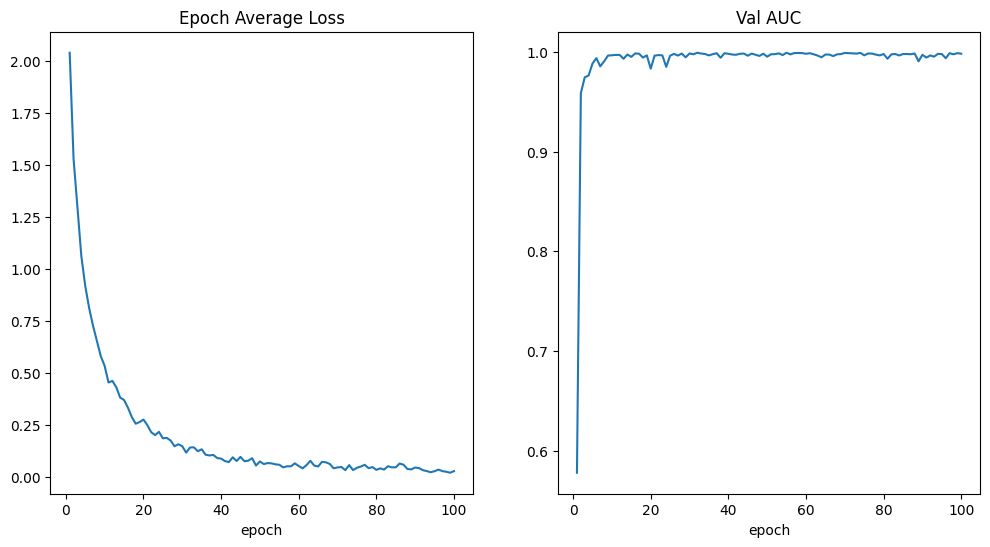

In [19]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluation

In [20]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_axial.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [21]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.8462    0.9565    0.8980        69
           1     0.6667    0.7353    0.6993        68
           2     0.7833    0.6812    0.7287        69
           3     0.7083    0.7846    0.7445        65
           4     0.8039    0.6308    0.7069        65
           5     0.7568    0.8485    0.8000        66
           6     0.6829    1.0000    0.8116        28
           7     1.0000    1.0000    1.0000        21
           8     1.0000    1.0000    1.0000        21
           9     0.7778    0.7101    0.7424        69
          10     0.8704    0.6812    0.7642        69

    accuracy                         0.7820       610
   macro avg     0.8087    0.8207    0.8087       610
weighted avg     0.7883    0.7820    0.7797       610



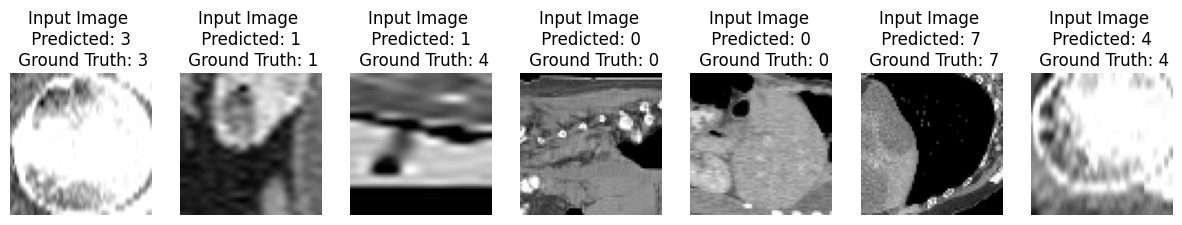

In [22]:
def plot_examples(images, preds, labels, n=5):
    plt.figure(figsize=(15, n))
    for i in range(n):
        j = np.random.randint(0, len(images))
        plt.subplot(1, n, i + 1)
        plt.imshow(images[j].squeeze(), cmap='gray')
        plt.title(f"Input Image \n Predicted: {preds[j]} \n Ground Truth: {labels[j]}")
        plt.axis('off')

    plt.show()

plot_examples(example_axial[1][:, 1], example_preds[1], example_labels[1], n=7)

# Coronal and sagittal parts

## Training cycle for the coronal part

## Pretrained

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True).to(device)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model = model.to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(coronal.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_coronal.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_coronal_pretrained.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

----------
epoch 1/100
epoch 1 average loss: 2.0277
1


Epochs:   1%|          | 1/100 [00:07<13:05,  7.93s/it]

saved new best metric model
current epoch: 1 current AUC: 0.9735 current accuracy: 0.7205 best AUC: 0.9735 at epoch: 1
----------
epoch 2/100
epoch 2 average loss: 1.0881
1


Epochs:   2%|▏         | 2/100 [00:15<12:55,  7.92s/it]

saved new best metric model
current epoch: 2 current AUC: 0.9927 current accuracy: 0.9006 best AUC: 0.9927 at epoch: 2
----------
epoch 3/100
epoch 3 average loss: 0.6894
1


Epochs:   3%|▎         | 3/100 [00:23<12:36,  7.80s/it]

saved new best metric model
current epoch: 3 current AUC: 0.9987 current accuracy: 0.9379 best AUC: 0.9987 at epoch: 3
----------
epoch 4/100
epoch 4 average loss: 0.5199
1


Epochs:   4%|▍         | 4/100 [00:31<12:25,  7.76s/it]

saved new best metric model
current epoch: 4 current AUC: 0.9992 current accuracy: 0.9441 best AUC: 0.9992 at epoch: 4
----------
epoch 5/100
epoch 5 average loss: 0.3830
1


Epochs:   5%|▌         | 5/100 [00:38<12:14,  7.73s/it]

saved new best metric model
current epoch: 5 current AUC: 0.9996 current accuracy: 0.9627 best AUC: 0.9996 at epoch: 5
----------
epoch 6/100
epoch 6 average loss: 0.2838
1


Epochs:   6%|▌         | 6/100 [00:46<12:09,  7.76s/it]

saved new best metric model
current epoch: 6 current AUC: 0.9998 current accuracy: 0.9814 best AUC: 0.9998 at epoch: 6
----------
epoch 7/100
epoch 7 average loss: 0.2651


Epochs:   7%|▋         | 7/100 [00:54<11:48,  7.62s/it]

1
current epoch: 7 current AUC: 0.9997 current accuracy: 0.9689 best AUC: 0.9998 at epoch: 6
----------
epoch 8/100
epoch 8 average loss: 0.2074


Epochs:   8%|▊         | 8/100 [01:01<11:31,  7.51s/it]

1
current epoch: 8 current AUC: 0.9998 current accuracy: 0.9876 best AUC: 0.9998 at epoch: 6
----------
epoch 9/100
epoch 9 average loss: 0.1595


Epochs:   9%|▉         | 9/100 [01:08<11:19,  7.47s/it]

1
current epoch: 9 current AUC: 0.9998 current accuracy: 0.9814 best AUC: 0.9998 at epoch: 6
----------
epoch 10/100
epoch 10 average loss: 0.1597
1


Epochs:  10%|█         | 10/100 [01:16<11:24,  7.61s/it]

saved new best metric model
current epoch: 10 current AUC: 0.9999 current accuracy: 0.9814 best AUC: 0.9999 at epoch: 10
----------
epoch 11/100
epoch 11 average loss: 0.1327
1


Epochs:  11%|█         | 11/100 [01:24<11:19,  7.64s/it]

saved new best metric model
current epoch: 11 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 11
----------
epoch 12/100
epoch 12 average loss: 0.0970


Epochs:  12%|█▏        | 12/100 [01:31<11:02,  7.53s/it]

1
current epoch: 12 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 11
----------
epoch 13/100
epoch 13 average loss: 0.0901


Epochs:  13%|█▎        | 13/100 [01:38<10:48,  7.46s/it]

1
current epoch: 13 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 11
----------
epoch 14/100
epoch 14 average loss: 0.0910


Epochs:  14%|█▍        | 14/100 [01:46<10:37,  7.41s/it]

1
current epoch: 14 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 11
----------
epoch 15/100
epoch 15 average loss: 0.0734


Epochs:  15%|█▌        | 15/100 [01:53<10:26,  7.38s/it]

1
current epoch: 15 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 11
----------
epoch 16/100
epoch 16 average loss: 0.0692


Epochs:  16%|█▌        | 16/100 [02:00<10:19,  7.37s/it]

1
current epoch: 16 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 11
----------
epoch 17/100
epoch 17 average loss: 0.0639


Epochs:  17%|█▋        | 17/100 [02:08<10:08,  7.33s/it]

1
current epoch: 17 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 11
----------
epoch 18/100
epoch 18 average loss: 0.0499


Epochs:  18%|█▊        | 18/100 [02:15<10:03,  7.35s/it]

1
current epoch: 18 current AUC: 1.0000 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 11
----------
epoch 19/100
epoch 19 average loss: 0.0531


Epochs:  19%|█▉        | 19/100 [02:22<09:57,  7.38s/it]

1
current epoch: 19 current AUC: 1.0000 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 11
----------
epoch 20/100
epoch 20 average loss: 0.0582


Epochs:  20%|██        | 20/100 [02:30<09:50,  7.38s/it]

1
current epoch: 20 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 11
----------
epoch 21/100
epoch 21 average loss: 0.0422


Epochs:  21%|██        | 21/100 [02:37<09:43,  7.39s/it]

1
current epoch: 21 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 11
----------
epoch 22/100
epoch 22 average loss: 0.0523


Epochs:  22%|██▏       | 22/100 [02:45<09:35,  7.38s/it]

1
current epoch: 22 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 11
----------
epoch 23/100
epoch 23 average loss: 0.0363


Epochs:  23%|██▎       | 23/100 [02:52<09:27,  7.37s/it]

1
current epoch: 23 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 11
----------
epoch 24/100
epoch 24 average loss: 0.0466


Epochs:  24%|██▍       | 24/100 [02:59<09:19,  7.36s/it]

1
current epoch: 24 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 11
----------
epoch 25/100
epoch 25 average loss: 0.0410


Epochs:  25%|██▌       | 25/100 [03:07<09:14,  7.40s/it]

1
current epoch: 25 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 11
----------
epoch 26/100
epoch 26 average loss: 0.0377


Epochs:  26%|██▌       | 26/100 [03:15<09:29,  7.69s/it]

1
current epoch: 26 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 11
----------
epoch 27/100
epoch 27 average loss: 0.0240


Epochs:  27%|██▋       | 27/100 [03:23<09:20,  7.68s/it]

1
current epoch: 27 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 11
----------
epoch 28/100
epoch 28 average loss: 0.0404


Epochs:  28%|██▊       | 28/100 [03:31<09:21,  7.80s/it]

1
current epoch: 28 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 11
----------
epoch 29/100
epoch 29 average loss: 0.0420


Epochs:  29%|██▉       | 29/100 [03:38<09:06,  7.69s/it]

1
current epoch: 29 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 11
----------
epoch 30/100
epoch 30 average loss: 0.0238


Epochs:  30%|███       | 30/100 [03:46<08:50,  7.58s/it]

1
current epoch: 30 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 11
----------
epoch 31/100
epoch 31 average loss: 0.0240


Epochs:  31%|███       | 31/100 [03:53<08:38,  7.52s/it]

1
current epoch: 31 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 11
----------
epoch 32/100
epoch 32 average loss: 0.0267


Epochs:  32%|███▏      | 32/100 [04:00<08:28,  7.48s/it]

1
current epoch: 32 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 11
----------
epoch 33/100
epoch 33 average loss: 0.0181


Epochs:  33%|███▎      | 33/100 [04:08<08:17,  7.43s/it]

1
current epoch: 33 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 11
----------
epoch 34/100
epoch 34 average loss: 0.0208


Epochs:  34%|███▍      | 34/100 [04:15<08:09,  7.42s/it]

1
current epoch: 34 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 11
----------
epoch 35/100
epoch 35 average loss: 0.0218


Epochs:  35%|███▌      | 35/100 [04:23<08:03,  7.44s/it]

1
current epoch: 35 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 11
----------
epoch 36/100
epoch 36 average loss: 0.0156


Epochs:  36%|███▌      | 36/100 [04:30<07:52,  7.38s/it]

1
current epoch: 36 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 11
----------
epoch 37/100
epoch 37 average loss: 0.0458


Epochs:  37%|███▋      | 37/100 [04:37<07:44,  7.38s/it]

1
current epoch: 37 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 11
----------
epoch 38/100
epoch 38 average loss: 0.0208


Epochs:  38%|███▊      | 38/100 [04:45<07:37,  7.38s/it]

1
current epoch: 38 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 11
----------
epoch 39/100
epoch 39 average loss: 0.0193


Epochs:  39%|███▉      | 39/100 [04:52<07:29,  7.38s/it]

1
current epoch: 39 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 11
----------
epoch 40/100
epoch 40 average loss: 0.0256


Epochs:  40%|████      | 40/100 [04:59<07:20,  7.35s/it]

1
current epoch: 40 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 11
----------
epoch 41/100
epoch 41 average loss: 0.0202


Epochs:  41%|████      | 41/100 [05:07<07:16,  7.40s/it]

1
current epoch: 41 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 11
----------
epoch 42/100
epoch 42 average loss: 0.0211


Epochs:  42%|████▏     | 42/100 [05:14<07:07,  7.38s/it]

1
current epoch: 42 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 11
----------
epoch 43/100
epoch 43 average loss: 0.0101


Epochs:  43%|████▎     | 43/100 [05:21<06:59,  7.36s/it]

1
current epoch: 43 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 11
----------
epoch 44/100
epoch 44 average loss: 0.0220


Epochs:  44%|████▍     | 44/100 [05:29<06:51,  7.35s/it]

1
current epoch: 44 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 11
----------
epoch 45/100
epoch 45 average loss: 0.0144


Epochs:  45%|████▌     | 45/100 [05:36<06:44,  7.36s/it]

1
current epoch: 45 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 11
----------
epoch 46/100
epoch 46 average loss: 0.0139


Epochs:  46%|████▌     | 46/100 [05:44<06:38,  7.38s/it]

1
current epoch: 46 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 11
----------
epoch 47/100
epoch 47 average loss: 0.0190


Epochs:  47%|████▋     | 47/100 [05:51<06:31,  7.39s/it]

1
current epoch: 47 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 11
----------
epoch 48/100
epoch 48 average loss: 0.0102


Epochs:  48%|████▊     | 48/100 [05:58<06:22,  7.36s/it]

1
current epoch: 48 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 11
----------
epoch 49/100
epoch 49 average loss: 0.0300


Epochs:  49%|████▉     | 49/100 [06:06<06:17,  7.39s/it]

1
current epoch: 49 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 11
----------
epoch 50/100
epoch 50 average loss: 0.0140


Epochs:  50%|█████     | 50/100 [06:13<06:10,  7.41s/it]

1
current epoch: 50 current AUC: 1.0000 current accuracy: 1.0000 best AUC: 1.0000 at epoch: 11
----------
epoch 51/100
epoch 51 average loss: 0.0179


Epochs:  51%|█████     | 51/100 [06:21<06:03,  7.42s/it]

1
current epoch: 51 current AUC: 1.0000 current accuracy: 1.0000 best AUC: 1.0000 at epoch: 11
----------
epoch 52/100
epoch 52 average loss: 0.0258


Epochs:  52%|█████▏    | 52/100 [06:29<06:06,  7.64s/it]

1
current epoch: 52 current AUC: 1.0000 current accuracy: 1.0000 best AUC: 1.0000 at epoch: 11
----------
epoch 53/100
epoch 53 average loss: 0.0151


Epochs:  53%|█████▎    | 53/100 [06:36<05:55,  7.57s/it]

1
current epoch: 53 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 11
----------
epoch 54/100
epoch 54 average loss: 0.0125


Epochs:  54%|█████▍    | 54/100 [06:44<05:45,  7.51s/it]

1
current epoch: 54 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 11
----------
epoch 55/100
epoch 55 average loss: 0.0344


Epochs:  55%|█████▌    | 55/100 [06:51<05:36,  7.49s/it]

1
current epoch: 55 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 11
----------
epoch 56/100
epoch 56 average loss: 0.0244


Epochs:  56%|█████▌    | 56/100 [06:58<05:27,  7.45s/it]

1
current epoch: 56 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 11
----------
epoch 57/100
epoch 57 average loss: 0.0205


Epochs:  57%|█████▋    | 57/100 [07:06<05:19,  7.43s/it]

1
current epoch: 57 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 11
----------
epoch 58/100
epoch 58 average loss: 0.0166


Epochs:  58%|█████▊    | 58/100 [07:13<05:11,  7.41s/it]

1
current epoch: 58 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 11
----------
epoch 59/100
epoch 59 average loss: 0.0112


Epochs:  59%|█████▉    | 59/100 [07:20<05:03,  7.40s/it]

1
current epoch: 59 current AUC: 1.0000 current accuracy: 1.0000 best AUC: 1.0000 at epoch: 11
----------
epoch 60/100
epoch 60 average loss: 0.0178


Epochs:  60%|██████    | 60/100 [07:28<04:56,  7.40s/it]

1
current epoch: 60 current AUC: 1.0000 current accuracy: 1.0000 best AUC: 1.0000 at epoch: 11
----------
epoch 61/100
epoch 61 average loss: 0.0145


Epochs:  61%|██████    | 61/100 [07:35<04:48,  7.39s/it]

1
current epoch: 61 current AUC: 1.0000 current accuracy: 1.0000 best AUC: 1.0000 at epoch: 11
----------
epoch 62/100
epoch 62 average loss: 0.0100


Epochs:  62%|██████▏   | 62/100 [07:43<04:40,  7.38s/it]

1
current epoch: 62 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 11
----------
epoch 63/100
epoch 63 average loss: 0.0162


Epochs:  63%|██████▎   | 63/100 [07:50<04:33,  7.38s/it]

1
current epoch: 63 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 11
----------
epoch 64/100
epoch 64 average loss: 0.0071


Epochs:  64%|██████▍   | 64/100 [07:57<04:25,  7.38s/it]

1
current epoch: 64 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 11
----------
epoch 65/100
epoch 65 average loss: 0.0070


Epochs:  65%|██████▌   | 65/100 [08:05<04:17,  7.35s/it]

1
current epoch: 65 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 11
----------
epoch 66/100
epoch 66 average loss: 0.0104


Epochs:  66%|██████▌   | 66/100 [08:12<04:09,  7.34s/it]

1
current epoch: 66 current AUC: 1.0000 current accuracy: 1.0000 best AUC: 1.0000 at epoch: 11
----------
epoch 67/100
epoch 67 average loss: 0.0103


Epochs:  67%|██████▋   | 67/100 [08:19<04:02,  7.36s/it]

1
current epoch: 67 current AUC: 1.0000 current accuracy: 1.0000 best AUC: 1.0000 at epoch: 11
----------
epoch 68/100
epoch 68 average loss: 0.0090


Epochs:  68%|██████▊   | 68/100 [08:27<03:56,  7.40s/it]

1
current epoch: 68 current AUC: 1.0000 current accuracy: 1.0000 best AUC: 1.0000 at epoch: 11
----------
epoch 69/100
epoch 69 average loss: 0.0096


Epochs:  69%|██████▉   | 69/100 [08:34<03:49,  7.39s/it]

1
current epoch: 69 current AUC: 1.0000 current accuracy: 1.0000 best AUC: 1.0000 at epoch: 11
----------
epoch 70/100
epoch 70 average loss: 0.0120


Epochs:  70%|███████   | 70/100 [08:41<03:40,  7.35s/it]

1
current epoch: 70 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 11
----------
epoch 71/100
epoch 71 average loss: 0.0143


Epochs:  71%|███████   | 71/100 [08:49<03:33,  7.37s/it]

1
current epoch: 71 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 11
----------
epoch 72/100
epoch 72 average loss: 0.0092


Epochs:  72%|███████▏  | 72/100 [08:56<03:27,  7.40s/it]

1
current epoch: 72 current AUC: 1.0000 current accuracy: 1.0000 best AUC: 1.0000 at epoch: 11
----------
epoch 73/100
epoch 73 average loss: 0.0158


Epochs:  73%|███████▎  | 73/100 [09:04<03:19,  7.39s/it]

1
current epoch: 73 current AUC: 1.0000 current accuracy: 1.0000 best AUC: 1.0000 at epoch: 11
----------
epoch 74/100
epoch 74 average loss: 0.0059


Epochs:  74%|███████▍  | 74/100 [09:11<03:10,  7.34s/it]

1
current epoch: 74 current AUC: 1.0000 current accuracy: 1.0000 best AUC: 1.0000 at epoch: 11
----------
epoch 75/100
epoch 75 average loss: 0.0130


Epochs:  75%|███████▌  | 75/100 [09:18<03:03,  7.34s/it]

1
current epoch: 75 current AUC: 1.0000 current accuracy: 1.0000 best AUC: 1.0000 at epoch: 11
----------
epoch 76/100
epoch 76 average loss: 0.0108


Epochs:  76%|███████▌  | 76/100 [09:26<02:55,  7.33s/it]

1
current epoch: 76 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 11
----------
epoch 77/100
epoch 77 average loss: 0.0165


Epochs:  77%|███████▋  | 77/100 [09:33<02:49,  7.37s/it]

1
current epoch: 77 current AUC: 1.0000 current accuracy: 1.0000 best AUC: 1.0000 at epoch: 11
----------
epoch 78/100
epoch 78 average loss: 0.0155


Epochs:  78%|███████▊  | 78/100 [09:40<02:42,  7.37s/it]

1
current epoch: 78 current AUC: 1.0000 current accuracy: 1.0000 best AUC: 1.0000 at epoch: 11
----------
epoch 79/100
epoch 79 average loss: 0.0093


Epochs:  79%|███████▉  | 79/100 [09:48<02:34,  7.38s/it]

1
current epoch: 79 current AUC: 1.0000 current accuracy: 1.0000 best AUC: 1.0000 at epoch: 11
----------
epoch 80/100
epoch 80 average loss: 0.0103


Epochs:  80%|████████  | 80/100 [09:55<02:27,  7.36s/it]

1
current epoch: 80 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 11
----------
epoch 81/100
epoch 81 average loss: 0.0055


Epochs:  81%|████████  | 81/100 [10:02<02:19,  7.36s/it]

1
current epoch: 81 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 11
----------
epoch 82/100
epoch 82 average loss: 0.0061


Epochs:  82%|████████▏ | 82/100 [10:10<02:12,  7.35s/it]

1
current epoch: 82 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 11
----------
epoch 83/100
epoch 83 average loss: 0.0224


Epochs:  83%|████████▎ | 83/100 [10:17<02:05,  7.40s/it]

1
current epoch: 83 current AUC: 1.0000 current accuracy: 1.0000 best AUC: 1.0000 at epoch: 11
----------
epoch 84/100
epoch 84 average loss: 0.0188


Epochs:  84%|████████▍ | 84/100 [10:25<01:58,  7.39s/it]

1
current epoch: 84 current AUC: 1.0000 current accuracy: 1.0000 best AUC: 1.0000 at epoch: 11
----------
epoch 85/100
epoch 85 average loss: 0.0188


Epochs:  85%|████████▌ | 85/100 [10:32<01:51,  7.41s/it]

1
current epoch: 85 current AUC: 1.0000 current accuracy: 1.0000 best AUC: 1.0000 at epoch: 11
----------
epoch 86/100
epoch 86 average loss: 0.0048


Epochs:  86%|████████▌ | 86/100 [10:39<01:43,  7.36s/it]

1
current epoch: 86 current AUC: 1.0000 current accuracy: 1.0000 best AUC: 1.0000 at epoch: 11
----------
epoch 87/100
epoch 87 average loss: 0.0094


Epochs:  87%|████████▋ | 87/100 [10:47<01:35,  7.36s/it]

1
current epoch: 87 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 11
----------
epoch 88/100
epoch 88 average loss: 0.0174


Epochs:  88%|████████▊ | 88/100 [10:54<01:28,  7.36s/it]

1
current epoch: 88 current AUC: 1.0000 current accuracy: 1.0000 best AUC: 1.0000 at epoch: 11
----------
epoch 89/100
epoch 89 average loss: 0.0227


Epochs:  89%|████████▉ | 89/100 [11:01<01:20,  7.34s/it]

1
current epoch: 89 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 11
----------
epoch 90/100
epoch 90 average loss: 0.0082


Epochs:  90%|█████████ | 90/100 [11:09<01:13,  7.32s/it]

1
current epoch: 90 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 11
----------
epoch 91/100
epoch 91 average loss: 0.0107


Epochs:  91%|█████████ | 91/100 [11:16<01:06,  7.34s/it]

1
current epoch: 91 current AUC: 1.0000 current accuracy: 1.0000 best AUC: 1.0000 at epoch: 11
----------
epoch 92/100
epoch 92 average loss: 0.0056


Epochs:  92%|█████████▏| 92/100 [11:23<00:58,  7.36s/it]

1
current epoch: 92 current AUC: 1.0000 current accuracy: 1.0000 best AUC: 1.0000 at epoch: 11
----------
epoch 93/100
epoch 93 average loss: 0.0085


Epochs:  93%|█████████▎| 93/100 [11:31<00:51,  7.36s/it]

1
current epoch: 93 current AUC: 1.0000 current accuracy: 1.0000 best AUC: 1.0000 at epoch: 11
----------
epoch 94/100
epoch 94 average loss: 0.0237


Epochs:  94%|█████████▍| 94/100 [11:38<00:44,  7.36s/it]

1
current epoch: 94 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 11
----------
epoch 95/100
epoch 95 average loss: 0.0088


Epochs:  95%|█████████▌| 95/100 [11:46<00:36,  7.39s/it]

1
current epoch: 95 current AUC: 1.0000 current accuracy: 1.0000 best AUC: 1.0000 at epoch: 11
----------
epoch 96/100
epoch 96 average loss: 0.0056


Epochs:  96%|█████████▌| 96/100 [11:53<00:29,  7.38s/it]

1
current epoch: 96 current AUC: 1.0000 current accuracy: 1.0000 best AUC: 1.0000 at epoch: 11
----------
epoch 97/100
epoch 97 average loss: 0.0096


Epochs:  97%|█████████▋| 97/100 [12:00<00:22,  7.37s/it]

1
current epoch: 97 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 11
----------
epoch 98/100
epoch 98 average loss: 0.0087


Epochs:  98%|█████████▊| 98/100 [12:08<00:14,  7.38s/it]

1
current epoch: 98 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 11
----------
epoch 99/100
epoch 99 average loss: 0.0177


Epochs:  99%|█████████▉| 99/100 [12:15<00:07,  7.34s/it]

1
current epoch: 99 current AUC: 1.0000 current accuracy: 1.0000 best AUC: 1.0000 at epoch: 11
----------
epoch 100/100
epoch 100 average loss: 0.0171


Epochs: 100%|██████████| 100/100 [12:22<00:00,  7.43s/it]

1
current epoch: 100 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 11
train completed, best_metric: 1.0000 at epoch: 11


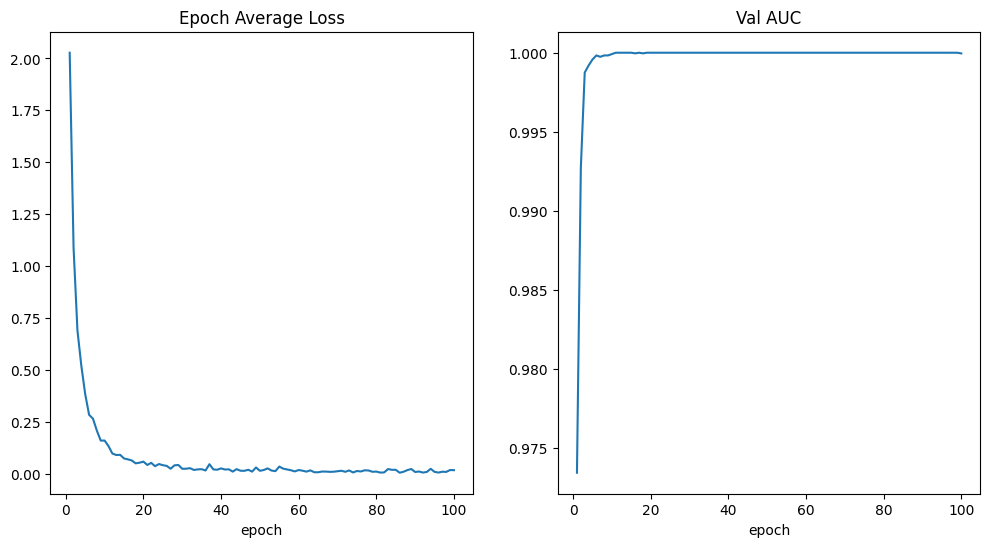

In [25]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluation

In [26]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_coronal_pretrained.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_coronal.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [27]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9718    1.0000    0.9857        69
           1     0.8621    0.7353    0.7937        68
           2     0.8167    0.7101    0.7597        69
           3     0.8116    0.8615    0.8358        65
           4     0.7576    0.7692    0.7634        65
           5     0.8358    0.8485    0.8421        66
           6     1.0000    0.7857    0.8800        28
           7     1.0000    0.9048    0.9500        21
           8     0.8696    0.9524    0.9091        21
           9     0.8354    0.9565    0.8919        69
          10     0.8684    0.9565    0.9103        69

    accuracy                         0.8574       610
   macro avg     0.8754    0.8619    0.8656       610
weighted avg     0.8590    0.8574    0.8557       610



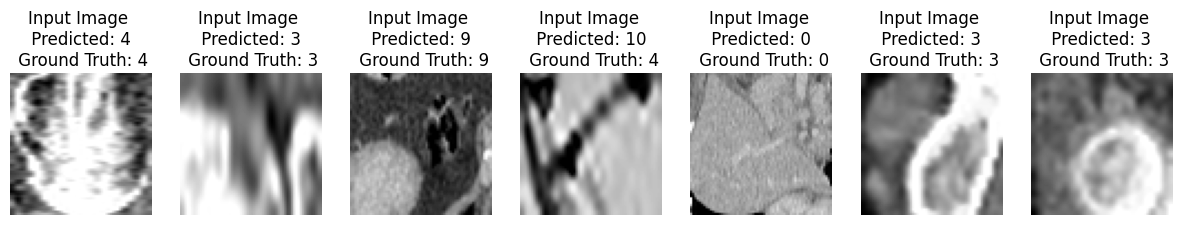

In [28]:
def plot_examples(images, preds, labels, n=5):
    plt.figure(figsize=(15, n))
    for i in range(n):
        j = np.random.randint(0, len(images))
        plt.subplot(1, n, i + 1)
        plt.imshow(images[j].squeeze(), cmap='gray')
        plt.title(f"Input Image \n Predicted: {preds[j]} \n Ground Truth: {labels[j]}")
        plt.axis('off')

    plt.show()

plot_examples(example_coronal[1][:, 1], example_preds[1], example_labels[1], n=7)

## Unpretrained

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=3, num_classes=n_classes).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

In [30]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(coronal.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_coronal.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_coronal.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

----------
epoch 1/100
epoch 1 average loss: 2.0178
1


Epochs:   1%|          | 1/100 [00:08<13:20,  8.09s/it]

saved new best metric model
current epoch: 1 current AUC: 0.5697 current accuracy: 0.0932 best AUC: 0.5697 at epoch: 1
----------
epoch 2/100
epoch 2 average loss: 1.5348
1


Epochs:   2%|▏         | 2/100 [00:16<13:12,  8.09s/it]

saved new best metric model
current epoch: 2 current AUC: 0.9512 current accuracy: 0.6335 best AUC: 0.9512 at epoch: 2
----------
epoch 3/100
epoch 3 average loss: 1.2608
1


Epochs:   3%|▎         | 3/100 [00:24<13:07,  8.11s/it]

saved new best metric model
current epoch: 3 current AUC: 0.9792 current accuracy: 0.8199 best AUC: 0.9792 at epoch: 3
----------
epoch 4/100
epoch 4 average loss: 1.0055
1


Epochs:   4%|▍         | 4/100 [00:32<12:58,  8.11s/it]

saved new best metric model
current epoch: 4 current AUC: 0.9842 current accuracy: 0.8199 best AUC: 0.9842 at epoch: 4
----------
epoch 5/100
epoch 5 average loss: 0.8243
1


Epochs:   5%|▌         | 5/100 [00:40<12:49,  8.10s/it]

saved new best metric model
current epoch: 5 current AUC: 0.9952 current accuracy: 0.9255 best AUC: 0.9952 at epoch: 5
----------
epoch 6/100
epoch 6 average loss: 0.6802
1


Epochs:   6%|▌         | 6/100 [00:48<12:42,  8.11s/it]

saved new best metric model
current epoch: 6 current AUC: 0.9980 current accuracy: 0.9130 best AUC: 0.9980 at epoch: 6
----------
epoch 7/100
epoch 7 average loss: 0.6074
1


Epochs:   7%|▋         | 7/100 [00:56<12:36,  8.13s/it]

saved new best metric model
current epoch: 7 current AUC: 0.9981 current accuracy: 0.8820 best AUC: 0.9981 at epoch: 7
----------
epoch 8/100
epoch 8 average loss: 0.5374
1


Epochs:   8%|▊         | 8/100 [01:05<12:30,  8.15s/it]

saved new best metric model
current epoch: 8 current AUC: 0.9984 current accuracy: 0.9130 best AUC: 0.9984 at epoch: 8
----------
epoch 9/100
epoch 9 average loss: 0.4741
1


Epochs:   9%|▉         | 9/100 [01:13<12:20,  8.14s/it]

saved new best metric model
current epoch: 9 current AUC: 0.9990 current accuracy: 0.9068 best AUC: 0.9990 at epoch: 9
----------
epoch 10/100
epoch 10 average loss: 0.4439


Epochs:  10%|█         | 10/100 [01:21<12:05,  8.06s/it]

1
current epoch: 10 current AUC: 0.9960 current accuracy: 0.8882 best AUC: 0.9990 at epoch: 9
----------
epoch 11/100
epoch 11 average loss: 0.4040
1


Epochs:  11%|█         | 11/100 [01:29<12:01,  8.11s/it]

saved new best metric model
current epoch: 11 current AUC: 0.9999 current accuracy: 0.9503 best AUC: 0.9999 at epoch: 11
----------
epoch 12/100
epoch 12 average loss: 0.3767


Epochs:  12%|█▏        | 12/100 [01:36<11:41,  7.98s/it]

1
current epoch: 12 current AUC: 0.9986 current accuracy: 0.9441 best AUC: 0.9999 at epoch: 11
----------
epoch 13/100
epoch 13 average loss: 0.3145


Epochs:  13%|█▎        | 13/100 [01:44<11:25,  7.88s/it]

1
current epoch: 13 current AUC: 0.9998 current accuracy: 0.9503 best AUC: 0.9999 at epoch: 11
----------
epoch 14/100
epoch 14 average loss: 0.3191


Epochs:  14%|█▍        | 14/100 [01:52<11:08,  7.77s/it]

1
current epoch: 14 current AUC: 0.9998 current accuracy: 0.9814 best AUC: 0.9999 at epoch: 11
----------
epoch 15/100
epoch 15 average loss: 0.2774


Epochs:  15%|█▌        | 15/100 [01:59<11:00,  7.77s/it]

1
current epoch: 15 current AUC: 0.9991 current accuracy: 0.9565 best AUC: 0.9999 at epoch: 11
----------
epoch 16/100
epoch 16 average loss: 0.2841


Epochs:  16%|█▌        | 16/100 [02:07<10:49,  7.73s/it]

1
current epoch: 16 current AUC: 0.9985 current accuracy: 0.9255 best AUC: 0.9999 at epoch: 11
----------
epoch 17/100
epoch 17 average loss: 0.2551
1


Epochs:  17%|█▋        | 17/100 [02:15<10:48,  7.81s/it]

saved new best metric model
current epoch: 17 current AUC: 0.9999 current accuracy: 0.9876 best AUC: 0.9999 at epoch: 17
----------
epoch 18/100
epoch 18 average loss: 0.2460


Epochs:  18%|█▊        | 18/100 [02:22<10:33,  7.73s/it]

1
current epoch: 18 current AUC: 0.9998 current accuracy: 0.9565 best AUC: 0.9999 at epoch: 17
----------
epoch 19/100
epoch 19 average loss: 0.2026


Epochs:  19%|█▉        | 19/100 [02:30<10:21,  7.68s/it]

1
current epoch: 19 current AUC: 0.9998 current accuracy: 0.9565 best AUC: 0.9999 at epoch: 17
----------
epoch 20/100
epoch 20 average loss: 0.2305


Epochs:  20%|██        | 20/100 [02:38<10:12,  7.65s/it]

1
current epoch: 20 current AUC: 0.9995 current accuracy: 0.9565 best AUC: 0.9999 at epoch: 17
----------
epoch 21/100
epoch 21 average loss: 0.1743


Epochs:  21%|██        | 21/100 [02:45<10:02,  7.62s/it]

1
current epoch: 21 current AUC: 0.9999 current accuracy: 0.9565 best AUC: 0.9999 at epoch: 17
----------
epoch 22/100
epoch 22 average loss: 0.1463


Epochs:  22%|██▏       | 22/100 [02:53<09:52,  7.59s/it]

1
current epoch: 22 current AUC: 0.9997 current accuracy: 0.9627 best AUC: 0.9999 at epoch: 17
----------
epoch 23/100
epoch 23 average loss: 0.1468


Epochs:  23%|██▎       | 23/100 [03:00<09:44,  7.59s/it]

1
current epoch: 23 current AUC: 0.9999 current accuracy: 0.9689 best AUC: 0.9999 at epoch: 17
----------
epoch 24/100
epoch 24 average loss: 0.1712


Epochs:  24%|██▍       | 24/100 [03:08<09:35,  7.58s/it]

1
current epoch: 24 current AUC: 0.9997 current accuracy: 0.9752 best AUC: 0.9999 at epoch: 17
----------
epoch 25/100
epoch 25 average loss: 0.1886


Epochs:  25%|██▌       | 25/100 [03:15<09:27,  7.57s/it]

1
current epoch: 25 current AUC: 0.9998 current accuracy: 0.9565 best AUC: 0.9999 at epoch: 17
----------
epoch 26/100
epoch 26 average loss: 0.1456
1


Epochs:  26%|██▌       | 26/100 [03:24<09:31,  7.73s/it]

saved new best metric model
current epoch: 26 current AUC: 1.0000 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 26
----------
epoch 27/100
epoch 27 average loss: 0.1138


Epochs:  27%|██▋       | 27/100 [03:31<09:23,  7.72s/it]

1
current epoch: 27 current AUC: 0.9994 current accuracy: 0.9627 best AUC: 1.0000 at epoch: 26
----------
epoch 28/100
epoch 28 average loss: 0.1259


Epochs:  28%|██▊       | 28/100 [03:39<09:13,  7.69s/it]

1
current epoch: 28 current AUC: 0.9997 current accuracy: 0.9565 best AUC: 1.0000 at epoch: 26
----------
epoch 29/100
epoch 29 average loss: 0.0981


Epochs:  29%|██▉       | 29/100 [03:46<09:02,  7.65s/it]

1
current epoch: 29 current AUC: 0.9995 current accuracy: 0.9255 best AUC: 1.0000 at epoch: 26
----------
epoch 30/100
epoch 30 average loss: 0.1064


Epochs:  30%|███       | 30/100 [03:54<08:54,  7.63s/it]

1
current epoch: 30 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 26
----------
epoch 31/100
epoch 31 average loss: 0.0914


Epochs:  31%|███       | 31/100 [04:02<08:45,  7.62s/it]

1
current epoch: 31 current AUC: 0.9999 current accuracy: 0.9627 best AUC: 1.0000 at epoch: 26
----------
epoch 32/100
epoch 32 average loss: 0.0928


Epochs:  32%|███▏      | 32/100 [04:09<08:35,  7.58s/it]

1
current epoch: 32 current AUC: 0.9997 current accuracy: 0.9689 best AUC: 1.0000 at epoch: 26
----------
epoch 33/100
epoch 33 average loss: 0.0989


Epochs:  33%|███▎      | 33/100 [04:17<08:27,  7.58s/it]

1
current epoch: 33 current AUC: 0.9998 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 26
----------
epoch 34/100
epoch 34 average loss: 0.0891


Epochs:  34%|███▍      | 34/100 [04:24<08:20,  7.59s/it]

1
current epoch: 34 current AUC: 0.9999 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 26
----------
epoch 35/100
epoch 35 average loss: 0.1077


Epochs:  35%|███▌      | 35/100 [04:32<08:13,  7.60s/it]

1
current epoch: 35 current AUC: 0.9999 current accuracy: 0.9689 best AUC: 1.0000 at epoch: 26
----------
epoch 36/100
epoch 36 average loss: 0.0735


Epochs:  36%|███▌      | 36/100 [04:39<08:05,  7.59s/it]

1
current epoch: 36 current AUC: 1.0000 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 26
----------
epoch 37/100
epoch 37 average loss: 0.0918


Epochs:  37%|███▋      | 37/100 [04:47<07:55,  7.55s/it]

1
current epoch: 37 current AUC: 0.9998 current accuracy: 0.9689 best AUC: 1.0000 at epoch: 26
----------
epoch 38/100
epoch 38 average loss: 0.0668


Epochs:  38%|███▊      | 38/100 [04:54<07:48,  7.55s/it]

1
current epoch: 38 current AUC: 0.9998 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 26
----------
epoch 39/100
epoch 39 average loss: 0.0877


Epochs:  39%|███▉      | 39/100 [05:02<07:40,  7.55s/it]

1
current epoch: 39 current AUC: 0.9999 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 26
----------
epoch 40/100
epoch 40 average loss: 0.0902


Epochs:  40%|████      | 40/100 [05:10<07:34,  7.58s/it]

1
current epoch: 40 current AUC: 0.9999 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 26
----------
epoch 41/100
epoch 41 average loss: 0.0729


Epochs:  41%|████      | 41/100 [05:17<07:26,  7.57s/it]

1
current epoch: 41 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 26
----------
epoch 42/100
epoch 42 average loss: 0.0974


Epochs:  42%|████▏     | 42/100 [05:25<07:18,  7.56s/it]

1
current epoch: 42 current AUC: 0.9999 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 26
----------
epoch 43/100
epoch 43 average loss: 0.0976


Epochs:  43%|████▎     | 43/100 [05:32<07:11,  7.58s/it]

1
current epoch: 43 current AUC: 1.0000 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 26
----------
epoch 44/100
epoch 44 average loss: 0.0888


Epochs:  44%|████▍     | 44/100 [05:40<07:04,  7.59s/it]

1
current epoch: 44 current AUC: 0.9999 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 26
----------
epoch 45/100
epoch 45 average loss: 0.0680


Epochs:  45%|████▌     | 45/100 [05:47<06:56,  7.57s/it]

1
current epoch: 45 current AUC: 0.9998 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 26
----------
epoch 46/100
epoch 46 average loss: 0.0698


Epochs:  46%|████▌     | 46/100 [05:55<06:50,  7.60s/it]

1
current epoch: 46 current AUC: 0.9999 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 26
----------
epoch 47/100
epoch 47 average loss: 0.0515


Epochs:  47%|████▋     | 47/100 [06:03<06:44,  7.63s/it]

1
current epoch: 47 current AUC: 1.0000 current accuracy: 0.9627 best AUC: 1.0000 at epoch: 26
----------
epoch 48/100
epoch 48 average loss: 0.0611


Epochs:  48%|████▊     | 48/100 [06:10<06:35,  7.61s/it]

1
current epoch: 48 current AUC: 0.9999 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 26
----------
epoch 49/100
epoch 49 average loss: 0.0547


Epochs:  49%|████▉     | 49/100 [06:18<06:27,  7.60s/it]

1
current epoch: 49 current AUC: 0.9998 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 26
----------
epoch 50/100
epoch 50 average loss: 0.0647


Epochs:  50%|█████     | 50/100 [06:26<06:28,  7.77s/it]

1
current epoch: 50 current AUC: 0.9998 current accuracy: 0.9627 best AUC: 1.0000 at epoch: 26
----------
epoch 51/100
epoch 51 average loss: 0.0872


Epochs:  51%|█████     | 51/100 [06:34<06:27,  7.90s/it]

1
current epoch: 51 current AUC: 0.9984 current accuracy: 0.9130 best AUC: 1.0000 at epoch: 26
----------
epoch 52/100
epoch 52 average loss: 0.0604


Epochs:  52%|█████▏    | 52/100 [06:42<06:15,  7.83s/it]

1
current epoch: 52 current AUC: 1.0000 current accuracy: 0.9627 best AUC: 1.0000 at epoch: 26
----------
epoch 53/100
epoch 53 average loss: 0.0834


Epochs:  53%|█████▎    | 53/100 [06:50<06:10,  7.88s/it]

1
current epoch: 53 current AUC: 0.9999 current accuracy: 0.9627 best AUC: 1.0000 at epoch: 26
----------
epoch 54/100
epoch 54 average loss: 0.0809


Epochs:  54%|█████▍    | 54/100 [06:58<06:00,  7.83s/it]

1
current epoch: 54 current AUC: 1.0000 current accuracy: 0.9689 best AUC: 1.0000 at epoch: 26
----------
epoch 55/100
epoch 55 average loss: 0.0394


Epochs:  55%|█████▌    | 55/100 [07:06<06:04,  8.10s/it]

1
current epoch: 55 current AUC: 1.0000 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 26
----------
epoch 56/100
epoch 56 average loss: 0.0551


Epochs:  56%|█████▌    | 56/100 [07:14<05:50,  7.97s/it]

1
current epoch: 56 current AUC: 1.0000 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 26
----------
epoch 57/100
epoch 57 average loss: 0.0628


Epochs:  57%|█████▋    | 57/100 [07:22<05:38,  7.88s/it]

1
current epoch: 57 current AUC: 1.0000 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 26
----------
epoch 58/100
epoch 58 average loss: 0.0457


Epochs:  58%|█████▊    | 58/100 [07:30<05:34,  7.95s/it]

1
current epoch: 58 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 26
----------
epoch 59/100
epoch 59 average loss: 0.0517


Epochs:  59%|█████▉    | 59/100 [07:40<05:51,  8.58s/it]

1
current epoch: 59 current AUC: 1.0000 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 26
----------
epoch 60/100
epoch 60 average loss: 0.0410


Epochs:  60%|██████    | 60/100 [07:49<05:51,  8.78s/it]

1
current epoch: 60 current AUC: 1.0000 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 26
----------
epoch 61/100
epoch 61 average loss: 0.0410


Epochs:  61%|██████    | 61/100 [07:58<05:44,  8.82s/it]

1
current epoch: 61 current AUC: 1.0000 current accuracy: 0.9689 best AUC: 1.0000 at epoch: 26
----------
epoch 62/100
epoch 62 average loss: 0.0483


Epochs:  62%|██████▏   | 62/100 [08:06<05:24,  8.53s/it]

1
current epoch: 62 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 26
----------
epoch 63/100
epoch 63 average loss: 0.0296


Epochs:  63%|██████▎   | 63/100 [08:14<05:05,  8.27s/it]

1
current epoch: 63 current AUC: 0.9998 current accuracy: 0.9689 best AUC: 1.0000 at epoch: 26
----------
epoch 64/100
epoch 64 average loss: 0.0283


Epochs:  64%|██████▍   | 64/100 [08:21<04:51,  8.10s/it]

1
current epoch: 64 current AUC: 0.9999 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 26
----------
epoch 65/100
epoch 65 average loss: 0.0361


Epochs:  65%|██████▌   | 65/100 [08:29<04:38,  7.96s/it]

1
current epoch: 65 current AUC: 0.9997 current accuracy: 0.9565 best AUC: 1.0000 at epoch: 26
----------
epoch 66/100
epoch 66 average loss: 0.0448


Epochs:  66%|██████▌   | 66/100 [08:37<04:28,  7.89s/it]

1
current epoch: 66 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 26
----------
epoch 67/100
epoch 67 average loss: 0.0468


Epochs:  67%|██████▋   | 67/100 [08:44<04:18,  7.82s/it]

1
current epoch: 67 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 26
----------
epoch 68/100
epoch 68 average loss: 0.0464


Epochs:  68%|██████▊   | 68/100 [08:52<04:09,  7.78s/it]

1
current epoch: 68 current AUC: 0.9999 current accuracy: 0.9689 best AUC: 1.0000 at epoch: 26
----------
epoch 69/100
epoch 69 average loss: 0.0536


Epochs:  69%|██████▉   | 69/100 [09:00<04:00,  7.74s/it]

1
current epoch: 69 current AUC: 1.0000 current accuracy: 0.9689 best AUC: 1.0000 at epoch: 26
----------
epoch 70/100
epoch 70 average loss: 0.0546


Epochs:  70%|███████   | 70/100 [09:07<03:50,  7.67s/it]

1
current epoch: 70 current AUC: 0.9999 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 26
----------
epoch 71/100
epoch 71 average loss: 0.0394


Epochs:  71%|███████   | 71/100 [09:15<03:42,  7.67s/it]

1
current epoch: 71 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 26
----------
epoch 72/100
epoch 72 average loss: 0.0369


Epochs:  72%|███████▏  | 72/100 [09:22<03:34,  7.65s/it]

1
current epoch: 72 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 26
----------
epoch 73/100
epoch 73 average loss: 0.0350


Epochs:  73%|███████▎  | 73/100 [09:30<03:26,  7.63s/it]

1
current epoch: 73 current AUC: 0.9998 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 26
----------
epoch 74/100
epoch 74 average loss: 0.0319


Epochs:  74%|███████▍  | 74/100 [09:38<03:18,  7.63s/it]

1
current epoch: 74 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 26
----------
epoch 75/100
epoch 75 average loss: 0.0283


Epochs:  75%|███████▌  | 75/100 [09:45<03:11,  7.64s/it]

1
current epoch: 75 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 26
----------
epoch 76/100
epoch 76 average loss: 0.0272


Epochs:  76%|███████▌  | 76/100 [09:53<03:03,  7.64s/it]

1
current epoch: 76 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 26
----------
epoch 77/100
epoch 77 average loss: 0.0267


Epochs:  77%|███████▋  | 77/100 [10:01<02:56,  7.65s/it]

1
current epoch: 77 current AUC: 0.9999 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 26
----------
epoch 78/100
epoch 78 average loss: 0.0199


Epochs:  78%|███████▊  | 78/100 [10:08<02:49,  7.68s/it]

1
current epoch: 78 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 26
----------
epoch 79/100
epoch 79 average loss: 0.0246


Epochs:  79%|███████▉  | 79/100 [10:16<02:40,  7.64s/it]

1
current epoch: 79 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 26
----------
epoch 80/100
epoch 80 average loss: 0.0458


Epochs:  80%|████████  | 80/100 [10:24<02:33,  7.68s/it]

1
current epoch: 80 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 26
----------
epoch 81/100
epoch 81 average loss: 0.0405


Epochs:  81%|████████  | 81/100 [10:31<02:25,  7.68s/it]

1
current epoch: 81 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 26
----------
epoch 82/100
epoch 82 average loss: 0.0559


Epochs:  82%|████████▏ | 82/100 [10:40<02:25,  8.07s/it]

1
current epoch: 82 current AUC: 0.9999 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 26
----------
epoch 83/100
epoch 83 average loss: 0.0606


Epochs:  83%|████████▎ | 83/100 [10:49<02:18,  8.12s/it]

1
current epoch: 83 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 26
----------
epoch 84/100
epoch 84 average loss: 0.0567


Epochs:  84%|████████▍ | 84/100 [10:56<02:08,  8.02s/it]

1
current epoch: 84 current AUC: 0.9995 current accuracy: 0.9689 best AUC: 1.0000 at epoch: 26
----------
epoch 85/100
epoch 85 average loss: 0.0279


Epochs:  85%|████████▌ | 85/100 [11:04<01:58,  7.92s/it]

1
current epoch: 85 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 26
----------
epoch 86/100
epoch 86 average loss: 0.0206


Epochs:  86%|████████▌ | 86/100 [11:12<01:49,  7.84s/it]

1
current epoch: 86 current AUC: 0.9999 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 26
----------
epoch 87/100
epoch 87 average loss: 0.0274


Epochs:  87%|████████▋ | 87/100 [11:19<01:40,  7.75s/it]

1
current epoch: 87 current AUC: 0.9999 current accuracy: 0.9689 best AUC: 1.0000 at epoch: 26
----------
epoch 88/100
epoch 88 average loss: 0.0342


Epochs:  88%|████████▊ | 88/100 [11:27<01:32,  7.72s/it]

1
current epoch: 88 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 26
----------
epoch 89/100
epoch 89 average loss: 0.0353


Epochs:  89%|████████▉ | 89/100 [11:35<01:24,  7.69s/it]

1
current epoch: 89 current AUC: 0.9989 current accuracy: 0.9503 best AUC: 1.0000 at epoch: 26
----------
epoch 90/100
epoch 90 average loss: 0.0359


Epochs:  90%|█████████ | 90/100 [11:42<01:17,  7.71s/it]

1
current epoch: 90 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 26
----------
epoch 91/100
epoch 91 average loss: 0.0377


Epochs:  91%|█████████ | 91/100 [11:50<01:08,  7.66s/it]

1
current epoch: 91 current AUC: 0.9996 current accuracy: 0.9565 best AUC: 1.0000 at epoch: 26
----------
epoch 92/100
epoch 92 average loss: 0.0345


Epochs:  92%|█████████▏| 92/100 [11:58<01:01,  7.67s/it]

1
current epoch: 92 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 26
----------
epoch 93/100
epoch 93 average loss: 0.0292


Epochs:  93%|█████████▎| 93/100 [12:05<00:53,  7.68s/it]

1
current epoch: 93 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 26
----------
epoch 94/100
epoch 94 average loss: 0.0379


Epochs:  94%|█████████▍| 94/100 [12:13<00:46,  7.68s/it]

1
current epoch: 94 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 26
----------
epoch 95/100
epoch 95 average loss: 0.0321


Epochs:  95%|█████████▌| 95/100 [12:21<00:38,  7.65s/it]

1
current epoch: 95 current AUC: 1.0000 current accuracy: 0.9752 best AUC: 1.0000 at epoch: 26
----------
epoch 96/100
epoch 96 average loss: 0.0324


Epochs:  96%|█████████▌| 96/100 [12:28<00:30,  7.61s/it]

1
current epoch: 96 current AUC: 0.9996 current accuracy: 0.9565 best AUC: 1.0000 at epoch: 26
----------
epoch 97/100
epoch 97 average loss: 0.0326


Epochs:  97%|█████████▋| 97/100 [12:37<00:23,  7.88s/it]

1
current epoch: 97 current AUC: 0.9998 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 26
----------
epoch 98/100
epoch 98 average loss: 0.0232


Epochs:  98%|█████████▊| 98/100 [12:45<00:16,  8.14s/it]

1
current epoch: 98 current AUC: 1.0000 current accuracy: 0.9938 best AUC: 1.0000 at epoch: 26
----------
epoch 99/100
epoch 99 average loss: 0.0214


Epochs:  99%|█████████▉| 99/100 [12:56<00:08,  8.77s/it]

1
current epoch: 99 current AUC: 1.0000 current accuracy: 0.9876 best AUC: 1.0000 at epoch: 26
----------
epoch 100/100
epoch 100 average loss: 0.0294


Epochs: 100%|██████████| 100/100 [13:03<00:00,  7.84s/it]

1
current epoch: 100 current AUC: 1.0000 current accuracy: 0.9814 best AUC: 1.0000 at epoch: 26
train completed, best_metric: 1.0000 at epoch: 26


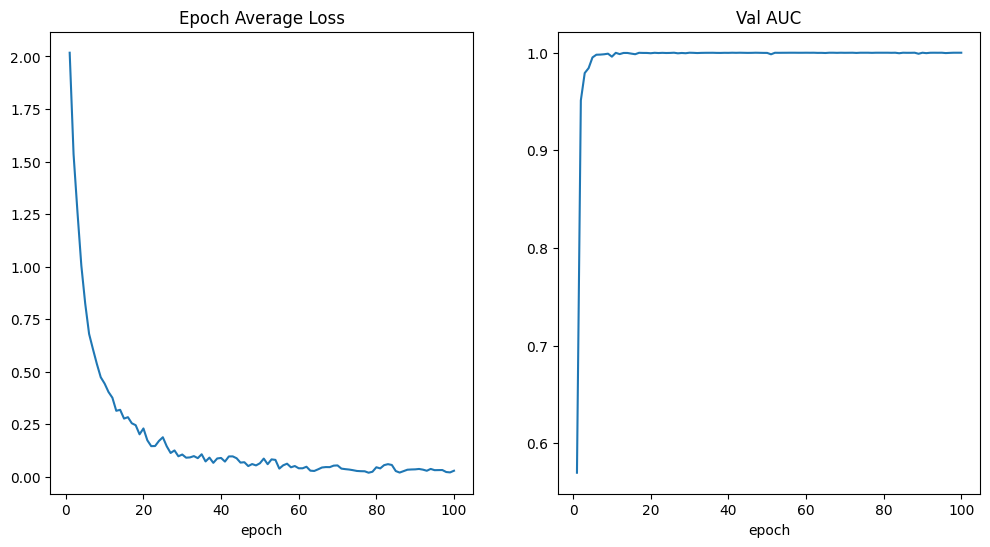

In [31]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluation

In [32]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_coronal.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [33]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.0741    0.0290    0.0417        69
           1     0.1709    0.3971    0.2389        68
           2     0.0936    0.2319    0.1333        69
           3     0.4808    0.3846    0.4274        65
           4     0.2400    0.0923    0.1333        65
           5     0.5600    0.2121    0.3077        66
           6     0.0000    0.0000    0.0000        28
           7     0.0000    0.0000    0.0000        21
           8     0.4565    1.0000    0.6269        21
           9     0.2824    0.3478    0.3117        69
          10     0.2667    0.0580    0.0952        69

    accuracy                         0.2279       610
   macro avg     0.2386    0.2503    0.2106       610
weighted avg     0.2532    0.2279    0.2071       610



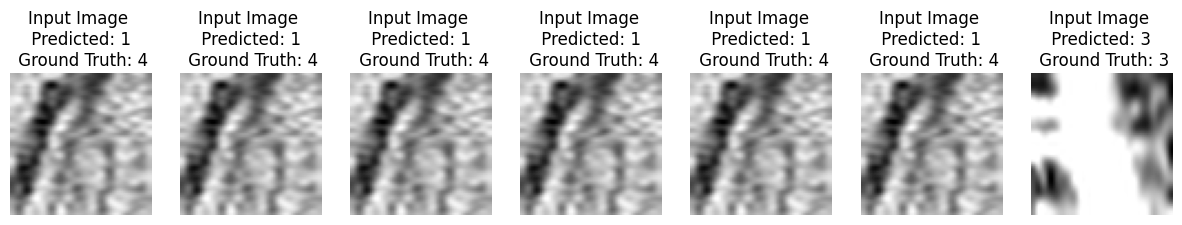

In [34]:
plot_examples(test_coronal[:, 1], pred, test_labels, n=7)

## Training cycle for the sagittal part

## Pretrained

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True).to(device)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model = model.to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(sagittal.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_sagittal.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_sagittal_pretrained.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

----------
epoch 1/100
epoch 1 average loss: 2.0485
1


Epochs:   1%|          | 1/100 [00:09<16:01,  9.71s/it]

saved new best metric model
current epoch: 1 current AUC: 0.9415 current accuracy: 0.6584 best AUC: 0.9415 at epoch: 1
----------
epoch 2/100
epoch 2 average loss: 1.1228
1


Epochs:   2%|▏         | 2/100 [00:18<14:35,  8.93s/it]

saved new best metric model
current epoch: 2 current AUC: 0.9737 current accuracy: 0.7081 best AUC: 0.9737 at epoch: 2
----------
epoch 3/100
epoch 3 average loss: 0.7899
1


Epochs:   3%|▎         | 3/100 [00:26<13:57,  8.63s/it]

saved new best metric model
current epoch: 3 current AUC: 0.9824 current accuracy: 0.7764 best AUC: 0.9824 at epoch: 3
----------
epoch 4/100
epoch 4 average loss: 0.6194
1


Epochs:   4%|▍         | 4/100 [00:34<13:33,  8.48s/it]

saved new best metric model
current epoch: 4 current AUC: 0.9851 current accuracy: 0.7950 best AUC: 0.9851 at epoch: 4
----------
epoch 5/100
epoch 5 average loss: 0.5436


Epochs:   5%|▌         | 5/100 [00:42<13:06,  8.28s/it]

1
current epoch: 5 current AUC: 0.9851 current accuracy: 0.8012 best AUC: 0.9851 at epoch: 4
----------
epoch 6/100
epoch 6 average loss: 0.4487


Epochs:   6%|▌         | 6/100 [00:50<12:49,  8.19s/it]

1
current epoch: 6 current AUC: 0.9836 current accuracy: 0.8261 best AUC: 0.9851 at epoch: 4
----------
epoch 7/100
epoch 7 average loss: 0.4034
1


Epochs:   7%|▋         | 7/100 [00:58<12:42,  8.20s/it]

saved new best metric model
current epoch: 7 current AUC: 0.9860 current accuracy: 0.8075 best AUC: 0.9860 at epoch: 7
----------
epoch 8/100
epoch 8 average loss: 0.3434


Epochs:   8%|▊         | 8/100 [01:08<13:05,  8.53s/it]

1
current epoch: 8 current AUC: 0.9852 current accuracy: 0.7764 best AUC: 0.9860 at epoch: 7
----------
epoch 9/100
epoch 9 average loss: 0.3323


Epochs:   9%|▉         | 9/100 [01:17<13:10,  8.69s/it]

1
current epoch: 9 current AUC: 0.9851 current accuracy: 0.8323 best AUC: 0.9860 at epoch: 7
----------
epoch 10/100
epoch 10 average loss: 0.2713
1


Epochs:  10%|█         | 10/100 [01:26<13:20,  8.89s/it]

saved new best metric model
current epoch: 10 current AUC: 0.9874 current accuracy: 0.8075 best AUC: 0.9874 at epoch: 10
----------
epoch 11/100
epoch 11 average loss: 0.2546


Epochs:  11%|█         | 11/100 [01:34<12:39,  8.54s/it]

1
current epoch: 11 current AUC: 0.9836 current accuracy: 0.8199 best AUC: 0.9874 at epoch: 10
----------
epoch 12/100
epoch 12 average loss: 0.2365


Epochs:  12%|█▏        | 12/100 [01:42<12:14,  8.35s/it]

1
current epoch: 12 current AUC: 0.9854 current accuracy: 0.8696 best AUC: 0.9874 at epoch: 10
----------
epoch 13/100
epoch 13 average loss: 0.1905
1


Epochs:  13%|█▎        | 13/100 [01:50<12:02,  8.31s/it]

saved new best metric model
current epoch: 13 current AUC: 0.9882 current accuracy: 0.8385 best AUC: 0.9882 at epoch: 13
----------
epoch 14/100
epoch 14 average loss: 0.1825


Epochs:  14%|█▍        | 14/100 [01:58<11:41,  8.16s/it]

1
current epoch: 14 current AUC: 0.9873 current accuracy: 0.8385 best AUC: 0.9882 at epoch: 13
----------
epoch 15/100
epoch 15 average loss: 0.1495


Epochs:  15%|█▌        | 15/100 [02:05<11:27,  8.08s/it]

1
current epoch: 15 current AUC: 0.9853 current accuracy: 0.8137 best AUC: 0.9882 at epoch: 13
----------
epoch 16/100
epoch 16 average loss: 0.1385
1


Epochs:  16%|█▌        | 16/100 [02:14<11:24,  8.15s/it]

saved new best metric model
current epoch: 16 current AUC: 0.9888 current accuracy: 0.8261 best AUC: 0.9888 at epoch: 16
----------
epoch 17/100
epoch 17 average loss: 0.1454
1


Epochs:  17%|█▋        | 17/100 [02:22<11:19,  8.19s/it]

saved new best metric model
current epoch: 17 current AUC: 0.9901 current accuracy: 0.8509 best AUC: 0.9901 at epoch: 17
----------
epoch 18/100
epoch 18 average loss: 0.1274


Epochs:  18%|█▊        | 18/100 [02:30<11:04,  8.10s/it]

1
current epoch: 18 current AUC: 0.9867 current accuracy: 0.8634 best AUC: 0.9901 at epoch: 17
----------
epoch 19/100
epoch 19 average loss: 0.1283


Epochs:  19%|█▉        | 19/100 [02:38<10:52,  8.05s/it]

1
current epoch: 19 current AUC: 0.9879 current accuracy: 0.8447 best AUC: 0.9901 at epoch: 17
----------
epoch 20/100
epoch 20 average loss: 0.1001


Epochs:  20%|██        | 20/100 [02:46<10:38,  7.99s/it]

1
current epoch: 20 current AUC: 0.9866 current accuracy: 0.8509 best AUC: 0.9901 at epoch: 17
----------
epoch 21/100
epoch 21 average loss: 0.1208


Epochs:  21%|██        | 21/100 [02:54<10:29,  7.97s/it]

1
current epoch: 21 current AUC: 0.9863 current accuracy: 0.8571 best AUC: 0.9901 at epoch: 17
----------
epoch 22/100
epoch 22 average loss: 0.0926


Epochs:  22%|██▏       | 22/100 [03:02<10:20,  7.96s/it]

1
current epoch: 22 current AUC: 0.9861 current accuracy: 0.8509 best AUC: 0.9901 at epoch: 17
----------
epoch 23/100
epoch 23 average loss: 0.0974
1


Epochs:  23%|██▎       | 23/100 [03:10<10:18,  8.03s/it]

saved new best metric model
current epoch: 23 current AUC: 0.9901 current accuracy: 0.8447 best AUC: 0.9901 at epoch: 23
----------
epoch 24/100
epoch 24 average loss: 0.0854
1


Epochs:  24%|██▍       | 24/100 [03:18<10:17,  8.13s/it]

saved new best metric model
current epoch: 24 current AUC: 0.9902 current accuracy: 0.8820 best AUC: 0.9902 at epoch: 24
----------
epoch 25/100
epoch 25 average loss: 0.0678


Epochs:  25%|██▌       | 25/100 [03:26<10:04,  8.07s/it]

1
current epoch: 25 current AUC: 0.9862 current accuracy: 0.8509 best AUC: 0.9902 at epoch: 24
----------
epoch 26/100
epoch 26 average loss: 0.0608


Epochs:  26%|██▌       | 26/100 [03:34<09:51,  8.00s/it]

1
current epoch: 26 current AUC: 0.9856 current accuracy: 0.8323 best AUC: 0.9902 at epoch: 24
----------
epoch 27/100
epoch 27 average loss: 0.0782


Epochs:  27%|██▋       | 27/100 [03:42<09:42,  7.97s/it]

1
current epoch: 27 current AUC: 0.9836 current accuracy: 0.8137 best AUC: 0.9902 at epoch: 24
----------
epoch 28/100
epoch 28 average loss: 0.0858
1


Epochs:  28%|██▊       | 28/100 [03:50<09:41,  8.08s/it]

saved new best metric model
current epoch: 28 current AUC: 0.9917 current accuracy: 0.8944 best AUC: 0.9917 at epoch: 28
----------
epoch 29/100
epoch 29 average loss: 0.0671


Epochs:  29%|██▉       | 29/100 [03:58<09:31,  8.05s/it]

1
current epoch: 29 current AUC: 0.9856 current accuracy: 0.8447 best AUC: 0.9917 at epoch: 28
----------
epoch 30/100
epoch 30 average loss: 0.0608


Epochs:  30%|███       | 30/100 [04:06<09:19,  8.00s/it]

1
current epoch: 30 current AUC: 0.9909 current accuracy: 0.8758 best AUC: 0.9917 at epoch: 28
----------
epoch 31/100
epoch 31 average loss: 0.0590


Epochs:  31%|███       | 31/100 [04:14<09:08,  7.95s/it]

1
current epoch: 31 current AUC: 0.9873 current accuracy: 0.8261 best AUC: 0.9917 at epoch: 28
----------
epoch 32/100
epoch 32 average loss: 0.0542
1


Epochs:  32%|███▏      | 32/100 [04:22<09:07,  8.06s/it]

saved new best metric model
current epoch: 32 current AUC: 0.9926 current accuracy: 0.8820 best AUC: 0.9926 at epoch: 32
----------
epoch 33/100
epoch 33 average loss: 0.0505


Epochs:  33%|███▎      | 33/100 [04:30<08:58,  8.03s/it]

1
current epoch: 33 current AUC: 0.9861 current accuracy: 0.8199 best AUC: 0.9926 at epoch: 32
----------
epoch 34/100
epoch 34 average loss: 0.0469


Epochs:  34%|███▍      | 34/100 [04:38<08:46,  7.98s/it]

1
current epoch: 34 current AUC: 0.9836 current accuracy: 0.7640 best AUC: 0.9926 at epoch: 32
----------
epoch 35/100
epoch 35 average loss: 0.0468


Epochs:  35%|███▌      | 35/100 [04:46<08:38,  7.98s/it]

1
current epoch: 35 current AUC: 0.9828 current accuracy: 0.8075 best AUC: 0.9926 at epoch: 32
----------
epoch 36/100
epoch 36 average loss: 0.0478


Epochs:  36%|███▌      | 36/100 [04:54<08:29,  7.96s/it]

1
current epoch: 36 current AUC: 0.9797 current accuracy: 0.8385 best AUC: 0.9926 at epoch: 32
----------
epoch 37/100
epoch 37 average loss: 0.0374


Epochs:  37%|███▋      | 37/100 [05:02<08:19,  7.93s/it]

1
current epoch: 37 current AUC: 0.9892 current accuracy: 0.8447 best AUC: 0.9926 at epoch: 32
----------
epoch 38/100
epoch 38 average loss: 0.0504


Epochs:  38%|███▊      | 38/100 [05:10<08:11,  7.93s/it]

1
current epoch: 38 current AUC: 0.9874 current accuracy: 0.8385 best AUC: 0.9926 at epoch: 32
----------
epoch 39/100
epoch 39 average loss: 0.0503


Epochs:  39%|███▉      | 39/100 [05:18<08:04,  7.95s/it]

1
current epoch: 39 current AUC: 0.9883 current accuracy: 0.8447 best AUC: 0.9926 at epoch: 32
----------
epoch 40/100
epoch 40 average loss: 0.0474


Epochs:  40%|████      | 40/100 [05:26<07:55,  7.92s/it]

1
current epoch: 40 current AUC: 0.9832 current accuracy: 0.8137 best AUC: 0.9926 at epoch: 32
----------
epoch 41/100
epoch 41 average loss: 0.0381


Epochs:  41%|████      | 41/100 [05:34<07:48,  7.94s/it]

1
current epoch: 41 current AUC: 0.9852 current accuracy: 0.8634 best AUC: 0.9926 at epoch: 32
----------
epoch 42/100
epoch 42 average loss: 0.0406


Epochs:  42%|████▏     | 42/100 [05:41<07:37,  7.89s/it]

1
current epoch: 42 current AUC: 0.9861 current accuracy: 0.8571 best AUC: 0.9926 at epoch: 32
----------
epoch 43/100
epoch 43 average loss: 0.0330


Epochs:  43%|████▎     | 43/100 [05:49<07:29,  7.89s/it]

1
current epoch: 43 current AUC: 0.9889 current accuracy: 0.8696 best AUC: 0.9926 at epoch: 32
----------
epoch 44/100
epoch 44 average loss: 0.0477


Epochs:  44%|████▍     | 44/100 [05:57<07:22,  7.90s/it]

1
current epoch: 44 current AUC: 0.9871 current accuracy: 0.8634 best AUC: 0.9926 at epoch: 32
----------
epoch 45/100
epoch 45 average loss: 0.0410


Epochs:  45%|████▌     | 45/100 [06:05<07:13,  7.89s/it]

1
current epoch: 45 current AUC: 0.9870 current accuracy: 0.8571 best AUC: 0.9926 at epoch: 32
----------
epoch 46/100
epoch 46 average loss: 0.0354


Epochs:  46%|████▌     | 46/100 [06:13<07:05,  7.88s/it]

1
current epoch: 46 current AUC: 0.9888 current accuracy: 0.8696 best AUC: 0.9926 at epoch: 32
----------
epoch 47/100
epoch 47 average loss: 0.0349


Epochs:  47%|████▋     | 47/100 [06:21<06:56,  7.87s/it]

1
current epoch: 47 current AUC: 0.9894 current accuracy: 0.8696 best AUC: 0.9926 at epoch: 32
----------
epoch 48/100
epoch 48 average loss: 0.0252


Epochs:  48%|████▊     | 48/100 [06:29<06:51,  7.91s/it]

1
current epoch: 48 current AUC: 0.9865 current accuracy: 0.8571 best AUC: 0.9926 at epoch: 32
----------
epoch 49/100
epoch 49 average loss: 0.0453


Epochs:  49%|████▉     | 49/100 [06:36<06:42,  7.89s/it]

1
current epoch: 49 current AUC: 0.9850 current accuracy: 0.8696 best AUC: 0.9926 at epoch: 32
----------
epoch 50/100
epoch 50 average loss: 0.0552


Epochs:  50%|█████     | 50/100 [06:44<06:34,  7.89s/it]

1
current epoch: 50 current AUC: 0.9804 current accuracy: 0.8323 best AUC: 0.9926 at epoch: 32
----------
epoch 51/100
epoch 51 average loss: 0.0398


Epochs:  51%|█████     | 51/100 [06:52<06:26,  7.89s/it]

1
current epoch: 51 current AUC: 0.9823 current accuracy: 0.8509 best AUC: 0.9926 at epoch: 32
----------
epoch 52/100
epoch 52 average loss: 0.0246


Epochs:  52%|█████▏    | 52/100 [07:00<06:19,  7.91s/it]

1
current epoch: 52 current AUC: 0.9836 current accuracy: 0.8385 best AUC: 0.9926 at epoch: 32
----------
epoch 53/100
epoch 53 average loss: 0.0339


Epochs:  53%|█████▎    | 53/100 [07:08<06:10,  7.89s/it]

1
current epoch: 53 current AUC: 0.9847 current accuracy: 0.8758 best AUC: 0.9926 at epoch: 32
----------
epoch 54/100
epoch 54 average loss: 0.0238


Epochs:  54%|█████▍    | 54/100 [07:16<06:04,  7.92s/it]

1
current epoch: 54 current AUC: 0.9894 current accuracy: 0.8758 best AUC: 0.9926 at epoch: 32
----------
epoch 55/100
epoch 55 average loss: 0.0405


Epochs:  55%|█████▌    | 55/100 [07:24<05:55,  7.89s/it]

1
current epoch: 55 current AUC: 0.9843 current accuracy: 0.8696 best AUC: 0.9926 at epoch: 32
----------
epoch 56/100
epoch 56 average loss: 0.0296


Epochs:  56%|█████▌    | 56/100 [07:32<05:48,  7.92s/it]

1
current epoch: 56 current AUC: 0.9875 current accuracy: 0.8758 best AUC: 0.9926 at epoch: 32
----------
epoch 57/100
epoch 57 average loss: 0.0384


Epochs:  57%|█████▋    | 57/100 [07:40<05:41,  7.94s/it]

1
current epoch: 57 current AUC: 0.9901 current accuracy: 0.8944 best AUC: 0.9926 at epoch: 32
----------
epoch 58/100
epoch 58 average loss: 0.0423


Epochs:  58%|█████▊    | 58/100 [07:48<05:33,  7.94s/it]

1
current epoch: 58 current AUC: 0.9809 current accuracy: 0.8634 best AUC: 0.9926 at epoch: 32
----------
epoch 59/100
epoch 59 average loss: 0.0331


Epochs:  59%|█████▉    | 59/100 [07:56<05:23,  7.89s/it]

1
current epoch: 59 current AUC: 0.9825 current accuracy: 0.8634 best AUC: 0.9926 at epoch: 32
----------
epoch 60/100
epoch 60 average loss: 0.0255


Epochs:  60%|██████    | 60/100 [08:04<05:16,  7.92s/it]

1
current epoch: 60 current AUC: 0.9782 current accuracy: 0.8447 best AUC: 0.9926 at epoch: 32
----------
epoch 61/100
epoch 61 average loss: 0.0196


Epochs:  61%|██████    | 61/100 [08:11<05:08,  7.90s/it]

1
current epoch: 61 current AUC: 0.9771 current accuracy: 0.8509 best AUC: 0.9926 at epoch: 32
----------
epoch 62/100
epoch 62 average loss: 0.0270


Epochs:  62%|██████▏   | 62/100 [08:19<04:59,  7.87s/it]

1
current epoch: 62 current AUC: 0.9837 current accuracy: 0.8199 best AUC: 0.9926 at epoch: 32
----------
epoch 63/100
epoch 63 average loss: 0.0281


Epochs:  63%|██████▎   | 63/100 [08:27<04:51,  7.87s/it]

1
current epoch: 63 current AUC: 0.9821 current accuracy: 0.8385 best AUC: 0.9926 at epoch: 32
----------
epoch 64/100
epoch 64 average loss: 0.0261


Epochs:  64%|██████▍   | 64/100 [08:35<04:42,  7.85s/it]

1
current epoch: 64 current AUC: 0.9829 current accuracy: 0.8385 best AUC: 0.9926 at epoch: 32
----------
epoch 65/100
epoch 65 average loss: 0.0353


Epochs:  65%|██████▌   | 65/100 [08:43<04:34,  7.84s/it]

1
current epoch: 65 current AUC: 0.9862 current accuracy: 0.8696 best AUC: 0.9926 at epoch: 32
----------
epoch 66/100
epoch 66 average loss: 0.0530


Epochs:  66%|██████▌   | 66/100 [08:51<04:26,  7.83s/it]

1
current epoch: 66 current AUC: 0.9789 current accuracy: 0.8261 best AUC: 0.9926 at epoch: 32
----------
epoch 67/100
epoch 67 average loss: 0.0313


Epochs:  67%|██████▋   | 67/100 [08:58<04:18,  7.85s/it]

1
current epoch: 67 current AUC: 0.9788 current accuracy: 0.8323 best AUC: 0.9926 at epoch: 32
----------
epoch 68/100
epoch 68 average loss: 0.0224


Epochs:  68%|██████▊   | 68/100 [09:06<04:10,  7.83s/it]

1
current epoch: 68 current AUC: 0.9845 current accuracy: 0.8385 best AUC: 0.9926 at epoch: 32
----------
epoch 69/100
epoch 69 average loss: 0.0359


Epochs:  69%|██████▉   | 69/100 [09:14<04:01,  7.80s/it]

1
current epoch: 69 current AUC: 0.9832 current accuracy: 0.8634 best AUC: 0.9926 at epoch: 32
----------
epoch 70/100
epoch 70 average loss: 0.0215


Epochs:  70%|███████   | 70/100 [09:22<03:53,  7.79s/it]

1
current epoch: 70 current AUC: 0.9815 current accuracy: 0.8571 best AUC: 0.9926 at epoch: 32
----------
epoch 71/100
epoch 71 average loss: 0.0219


Epochs:  71%|███████   | 71/100 [09:29<03:45,  7.79s/it]

1
current epoch: 71 current AUC: 0.9829 current accuracy: 0.8696 best AUC: 0.9926 at epoch: 32
----------
epoch 72/100
epoch 72 average loss: 0.0190


Epochs:  72%|███████▏  | 72/100 [09:37<03:38,  7.82s/it]

1
current epoch: 72 current AUC: 0.9831 current accuracy: 0.8323 best AUC: 0.9926 at epoch: 32
----------
epoch 73/100
epoch 73 average loss: 0.0145


Epochs:  73%|███████▎  | 73/100 [09:45<03:30,  7.80s/it]

1
current epoch: 73 current AUC: 0.9815 current accuracy: 0.8261 best AUC: 0.9926 at epoch: 32
----------
epoch 74/100
epoch 74 average loss: 0.0194


Epochs:  74%|███████▍  | 74/100 [09:53<03:22,  7.81s/it]

1
current epoch: 74 current AUC: 0.9830 current accuracy: 0.8509 best AUC: 0.9926 at epoch: 32
----------
epoch 75/100
epoch 75 average loss: 0.0215


Epochs:  75%|███████▌  | 75/100 [10:01<03:17,  7.89s/it]

1
current epoch: 75 current AUC: 0.9844 current accuracy: 0.8571 best AUC: 0.9926 at epoch: 32
----------
epoch 76/100
epoch 76 average loss: 0.0132


Epochs:  76%|███████▌  | 76/100 [10:11<03:23,  8.46s/it]

1
current epoch: 76 current AUC: 0.9892 current accuracy: 0.8696 best AUC: 0.9926 at epoch: 32
----------
epoch 77/100
epoch 77 average loss: 0.0191


Epochs:  77%|███████▋  | 77/100 [10:19<03:10,  8.29s/it]

1
current epoch: 77 current AUC: 0.9860 current accuracy: 0.8696 best AUC: 0.9926 at epoch: 32
----------
epoch 78/100
epoch 78 average loss: 0.0304


Epochs:  78%|███████▊  | 78/100 [10:28<03:11,  8.72s/it]

1
current epoch: 78 current AUC: 0.9859 current accuracy: 0.8634 best AUC: 0.9926 at epoch: 32
----------
epoch 79/100
epoch 79 average loss: 0.0433


Epochs:  79%|███████▉  | 79/100 [10:38<03:05,  8.85s/it]

1
current epoch: 79 current AUC: 0.9890 current accuracy: 0.8509 best AUC: 0.9926 at epoch: 32
----------
epoch 80/100
epoch 80 average loss: 0.0283


Epochs:  80%|████████  | 80/100 [10:45<02:50,  8.54s/it]

1
current epoch: 80 current AUC: 0.9897 current accuracy: 0.8571 best AUC: 0.9926 at epoch: 32
----------
epoch 81/100
epoch 81 average loss: 0.0203


Epochs:  81%|████████  | 81/100 [10:53<02:36,  8.26s/it]

1
current epoch: 81 current AUC: 0.9783 current accuracy: 0.8447 best AUC: 0.9926 at epoch: 32
----------
epoch 82/100
epoch 82 average loss: 0.0142


Epochs:  82%|████████▏ | 82/100 [11:01<02:25,  8.07s/it]

1
current epoch: 82 current AUC: 0.9868 current accuracy: 0.8571 best AUC: 0.9926 at epoch: 32
----------
epoch 83/100
epoch 83 average loss: 0.0164


Epochs:  83%|████████▎ | 83/100 [11:08<02:15,  7.98s/it]

1
current epoch: 83 current AUC: 0.9885 current accuracy: 0.8571 best AUC: 0.9926 at epoch: 32
----------
epoch 84/100
epoch 84 average loss: 0.0325


Epochs:  84%|████████▍ | 84/100 [11:16<02:07,  7.95s/it]

1
current epoch: 84 current AUC: 0.9890 current accuracy: 0.8634 best AUC: 0.9926 at epoch: 32
----------
epoch 85/100
epoch 85 average loss: 0.0132


Epochs:  85%|████████▌ | 85/100 [11:24<01:58,  7.91s/it]

1
current epoch: 85 current AUC: 0.9889 current accuracy: 0.8758 best AUC: 0.9926 at epoch: 32
----------
epoch 86/100
epoch 86 average loss: 0.0260


Epochs:  86%|████████▌ | 86/100 [11:32<01:50,  7.89s/it]

1
current epoch: 86 current AUC: 0.9855 current accuracy: 0.8571 best AUC: 0.9926 at epoch: 32
----------
epoch 87/100
epoch 87 average loss: 0.0247
1


Epochs:  87%|████████▋ | 87/100 [11:40<01:43,  7.97s/it]

saved new best metric model
current epoch: 87 current AUC: 0.9950 current accuracy: 0.8944 best AUC: 0.9950 at epoch: 87
----------
epoch 88/100
epoch 88 average loss: 0.0284


Epochs:  88%|████████▊ | 88/100 [11:48<01:34,  7.89s/it]

1
current epoch: 88 current AUC: 0.9865 current accuracy: 0.8571 best AUC: 0.9950 at epoch: 87
----------
epoch 89/100
epoch 89 average loss: 0.0229


Epochs:  89%|████████▉ | 89/100 [11:55<01:26,  7.83s/it]

1
current epoch: 89 current AUC: 0.9901 current accuracy: 0.8944 best AUC: 0.9950 at epoch: 87
----------
epoch 90/100
epoch 90 average loss: 0.0289


Epochs:  90%|█████████ | 90/100 [12:03<01:18,  7.85s/it]

1
current epoch: 90 current AUC: 0.9909 current accuracy: 0.8758 best AUC: 0.9950 at epoch: 87
----------
epoch 91/100
epoch 91 average loss: 0.0229


Epochs:  91%|█████████ | 91/100 [12:11<01:10,  7.81s/it]

1
current epoch: 91 current AUC: 0.9909 current accuracy: 0.9006 best AUC: 0.9950 at epoch: 87
----------
epoch 92/100
epoch 92 average loss: 0.0274


Epochs:  92%|█████████▏| 92/100 [12:19<01:02,  7.82s/it]

1
current epoch: 92 current AUC: 0.9860 current accuracy: 0.8509 best AUC: 0.9950 at epoch: 87
----------
epoch 93/100
epoch 93 average loss: 0.0215


Epochs:  93%|█████████▎| 93/100 [12:27<00:54,  7.79s/it]

1
current epoch: 93 current AUC: 0.9881 current accuracy: 0.8509 best AUC: 0.9950 at epoch: 87
----------
epoch 94/100
epoch 94 average loss: 0.0264


Epochs:  94%|█████████▍| 94/100 [12:35<00:46,  7.81s/it]

1
current epoch: 94 current AUC: 0.9899 current accuracy: 0.8696 best AUC: 0.9950 at epoch: 87
----------
epoch 95/100
epoch 95 average loss: 0.0313


Epochs:  95%|█████████▌| 95/100 [12:42<00:38,  7.70s/it]

1
current epoch: 95 current AUC: 0.9864 current accuracy: 0.8634 best AUC: 0.9950 at epoch: 87
----------
epoch 96/100
epoch 96 average loss: 0.0159


Epochs:  96%|█████████▌| 96/100 [12:50<00:30,  7.71s/it]

1
current epoch: 96 current AUC: 0.9846 current accuracy: 0.8634 best AUC: 0.9950 at epoch: 87
----------
epoch 97/100
epoch 97 average loss: 0.0214


Epochs:  97%|█████████▋| 97/100 [12:57<00:23,  7.70s/it]

1
current epoch: 97 current AUC: 0.9860 current accuracy: 0.8571 best AUC: 0.9950 at epoch: 87
----------
epoch 98/100
epoch 98 average loss: 0.0165


Epochs:  98%|█████████▊| 98/100 [13:05<00:15,  7.75s/it]

1
current epoch: 98 current AUC: 0.9914 current accuracy: 0.9006 best AUC: 0.9950 at epoch: 87
----------
epoch 99/100
epoch 99 average loss: 0.0278


Epochs:  99%|█████████▉| 99/100 [13:13<00:07,  7.71s/it]

1
current epoch: 99 current AUC: 0.9911 current accuracy: 0.8882 best AUC: 0.9950 at epoch: 87
----------
epoch 100/100
epoch 100 average loss: 0.0185


Epochs: 100%|██████████| 100/100 [13:21<00:00,  8.01s/it]

1
current epoch: 100 current AUC: 0.9940 current accuracy: 0.8944 best AUC: 0.9950 at epoch: 87
train completed, best_metric: 0.9950 at epoch: 87


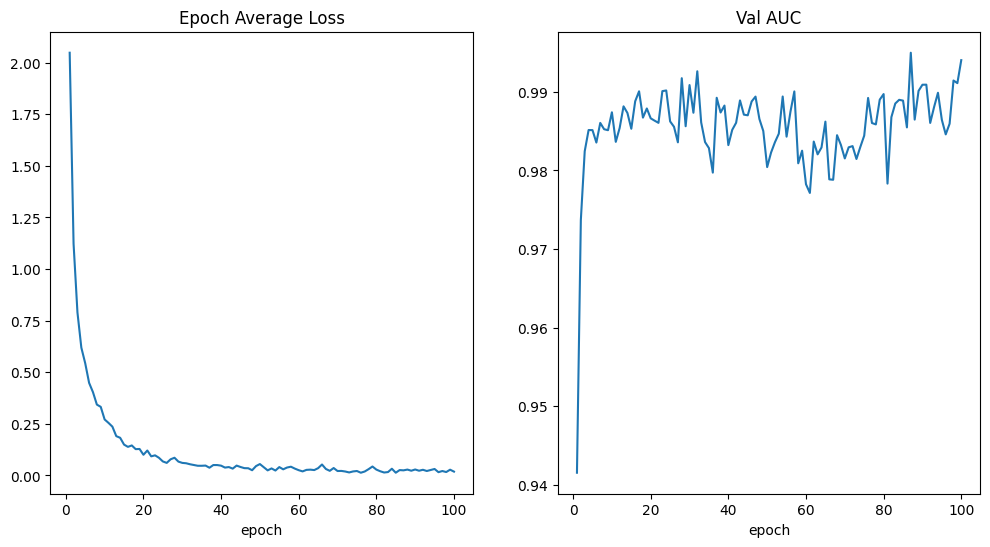

In [10]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluation

In [11]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_sagittal_pretrained.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_sagittal.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [12]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9583    1.0000    0.9787        69
           1     0.6438    0.6912    0.6667        68
           2     0.6170    0.4203    0.5000        69
           3     0.5968    0.5692    0.5827        65
           4     0.5676    0.6462    0.6043        65
           5     0.9538    0.9394    0.9466        66
           6     1.0000    0.9643    0.9818        28
           7     0.8947    0.8095    0.8500        21
           8     0.8261    0.9048    0.8636        21
           9     0.8312    0.9275    0.8767        69
          10     0.9437    0.9710    0.9571        69

    accuracy                         0.7869       610
   macro avg     0.8030    0.8039    0.8008       610
weighted avg     0.7831    0.7869    0.7820       610



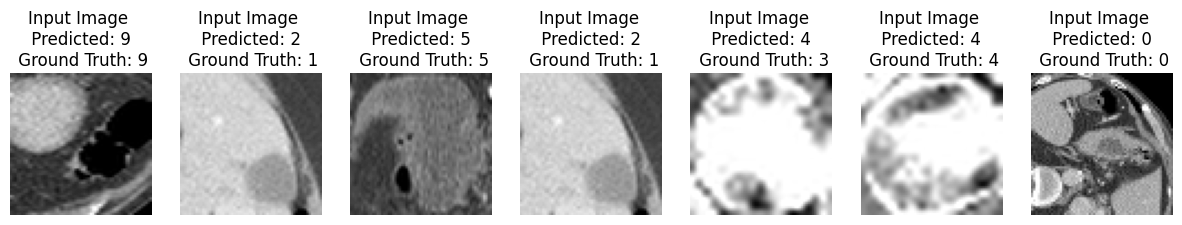

In [13]:
def plot_examples(images, preds, labels, n=5):
    plt.figure(figsize=(15, n))
    for i in range(n):
        j = np.random.randint(0, len(images))
        plt.subplot(1, n, i + 1)
        plt.imshow(images[j].squeeze(), cmap='gray')
        plt.title(f"Input Image \n Predicted: {preds[j]} \n Ground Truth: {labels[j]}")
        plt.axis('off')

    plt.show()

plot_examples(example_sagittal[1][:, 1], example_preds[1], example_labels[1], n=7)

## Unpretrained

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=3, num_classes=n_classes).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

In [15]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(sagittal.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_sagittal.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_sagittal.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

----------
epoch 1/100
epoch 1 average loss: 1.9538
1


Epochs:   1%|          | 1/100 [00:08<14:33,  8.82s/it]

saved new best metric model
current epoch: 1 current AUC: 0.6450 current accuracy: 0.0932 best AUC: 0.6450 at epoch: 1
----------
epoch 2/100
epoch 2 average loss: 1.5666
1


Epochs:   2%|▏         | 2/100 [00:17<13:56,  8.54s/it]

saved new best metric model
current epoch: 2 current AUC: 0.9501 current accuracy: 0.5901 best AUC: 0.9501 at epoch: 2
----------
epoch 3/100
epoch 3 average loss: 1.3105
1


Epochs:   3%|▎         | 3/100 [00:25<13:57,  8.64s/it]

saved new best metric model
current epoch: 3 current AUC: 0.9718 current accuracy: 0.6211 best AUC: 0.9718 at epoch: 3
----------
epoch 4/100
epoch 4 average loss: 1.1025


Epochs:   4%|▍         | 4/100 [00:34<13:29,  8.43s/it]

1
current epoch: 4 current AUC: 0.9668 current accuracy: 0.6273 best AUC: 0.9718 at epoch: 3
----------
epoch 5/100
epoch 5 average loss: 0.9684


Epochs:   5%|▌         | 5/100 [00:42<13:14,  8.37s/it]

1
current epoch: 5 current AUC: 0.9710 current accuracy: 0.6273 best AUC: 0.9718 at epoch: 3
----------
epoch 6/100
epoch 6 average loss: 0.8612
1


Epochs:   6%|▌         | 6/100 [00:50<13:09,  8.40s/it]

saved new best metric model
current epoch: 6 current AUC: 0.9739 current accuracy: 0.6708 best AUC: 0.9739 at epoch: 6
----------
epoch 7/100
epoch 7 average loss: 0.7774
1


Epochs:   7%|▋         | 7/100 [00:59<13:08,  8.48s/it]

saved new best metric model
current epoch: 7 current AUC: 0.9785 current accuracy: 0.6398 best AUC: 0.9785 at epoch: 7
----------
epoch 8/100
epoch 8 average loss: 0.7362


Epochs:   8%|▊         | 8/100 [01:07<12:47,  8.34s/it]

1
current epoch: 8 current AUC: 0.9780 current accuracy: 0.6770 best AUC: 0.9785 at epoch: 7
----------
epoch 9/100
epoch 9 average loss: 0.7210
1


Epochs:   9%|▉         | 9/100 [01:16<12:54,  8.51s/it]

saved new best metric model
current epoch: 9 current AUC: 0.9834 current accuracy: 0.6522 best AUC: 0.9834 at epoch: 9
----------
epoch 10/100
epoch 10 average loss: 0.6674
1


Epochs:  10%|█         | 10/100 [01:24<12:49,  8.55s/it]

saved new best metric model
current epoch: 10 current AUC: 0.9891 current accuracy: 0.7764 best AUC: 0.9891 at epoch: 10
----------
epoch 11/100
epoch 11 average loss: 0.6714


Epochs:  11%|█         | 11/100 [01:33<12:28,  8.41s/it]

1
current epoch: 11 current AUC: 0.9847 current accuracy: 0.7143 best AUC: 0.9891 at epoch: 10
----------
epoch 12/100
epoch 12 average loss: 0.5655


Epochs:  12%|█▏        | 12/100 [01:41<12:31,  8.54s/it]

1
current epoch: 12 current AUC: 0.9862 current accuracy: 0.7205 best AUC: 0.9891 at epoch: 10
----------
epoch 13/100
epoch 13 average loss: 0.5370


Epochs:  13%|█▎        | 13/100 [01:50<12:13,  8.44s/it]

1
current epoch: 13 current AUC: 0.9862 current accuracy: 0.7267 best AUC: 0.9891 at epoch: 10
----------
epoch 14/100
epoch 14 average loss: 0.5339


Epochs:  14%|█▍        | 14/100 [01:59<12:35,  8.79s/it]

1
current epoch: 14 current AUC: 0.9862 current accuracy: 0.7702 best AUC: 0.9891 at epoch: 10
----------
epoch 15/100
epoch 15 average loss: 0.5155


Epochs:  15%|█▌        | 15/100 [02:08<12:22,  8.73s/it]

1
current epoch: 15 current AUC: 0.9865 current accuracy: 0.7764 best AUC: 0.9891 at epoch: 10
----------
epoch 16/100
epoch 16 average loss: 0.4462


Epochs:  16%|█▌        | 16/100 [02:18<12:48,  9.15s/it]

1
current epoch: 16 current AUC: 0.9832 current accuracy: 0.8261 best AUC: 0.9891 at epoch: 10
----------
epoch 17/100
epoch 17 average loss: 0.4092


Epochs:  17%|█▋        | 17/100 [02:27<12:25,  8.99s/it]

1
current epoch: 17 current AUC: 0.9883 current accuracy: 0.8012 best AUC: 0.9891 at epoch: 10
----------
epoch 18/100
epoch 18 average loss: 0.4031
1


Epochs:  18%|█▊        | 18/100 [02:36<12:17,  9.00s/it]

saved new best metric model
current epoch: 18 current AUC: 0.9925 current accuracy: 0.8820 best AUC: 0.9925 at epoch: 18
----------
epoch 19/100
epoch 19 average loss: 0.3377


Epochs:  19%|█▉        | 19/100 [02:45<12:28,  9.24s/it]

1
current epoch: 19 current AUC: 0.9858 current accuracy: 0.8012 best AUC: 0.9925 at epoch: 18
----------
epoch 20/100
epoch 20 average loss: 0.3681


Epochs:  20%|██        | 20/100 [02:54<12:11,  9.14s/it]

1
current epoch: 20 current AUC: 0.9883 current accuracy: 0.8012 best AUC: 0.9925 at epoch: 18
----------
epoch 21/100
epoch 21 average loss: 0.3093


Epochs:  21%|██        | 21/100 [03:02<11:35,  8.81s/it]

1
current epoch: 21 current AUC: 0.9915 current accuracy: 0.7826 best AUC: 0.9925 at epoch: 18
----------
epoch 22/100
epoch 22 average loss: 0.2999


Epochs:  22%|██▏       | 22/100 [03:12<11:37,  8.94s/it]

1
current epoch: 22 current AUC: 0.9836 current accuracy: 0.7764 best AUC: 0.9925 at epoch: 18
----------
epoch 23/100
epoch 23 average loss: 0.3176


Epochs:  23%|██▎       | 23/100 [03:21<11:35,  9.03s/it]

1
current epoch: 23 current AUC: 0.9841 current accuracy: 0.7764 best AUC: 0.9925 at epoch: 18
----------
epoch 24/100
epoch 24 average loss: 0.2858


Epochs:  24%|██▍       | 24/100 [03:29<11:11,  8.83s/it]

1
current epoch: 24 current AUC: 0.9867 current accuracy: 0.8012 best AUC: 0.9925 at epoch: 18
----------
epoch 25/100
epoch 25 average loss: 0.2883


Epochs:  25%|██▌       | 25/100 [03:37<10:40,  8.54s/it]

1
current epoch: 25 current AUC: 0.9860 current accuracy: 0.7702 best AUC: 0.9925 at epoch: 18
----------
epoch 26/100
epoch 26 average loss: 0.2393


Epochs:  26%|██▌       | 26/100 [03:45<10:20,  8.39s/it]

1
current epoch: 26 current AUC: 0.9872 current accuracy: 0.8323 best AUC: 0.9925 at epoch: 18
----------
epoch 27/100
epoch 27 average loss: 0.2282


Epochs:  27%|██▋       | 27/100 [03:53<10:06,  8.31s/it]

1
current epoch: 27 current AUC: 0.9901 current accuracy: 0.8199 best AUC: 0.9925 at epoch: 18
----------
epoch 28/100
epoch 28 average loss: 0.2203


Epochs:  28%|██▊       | 28/100 [04:01<09:50,  8.21s/it]

1
current epoch: 28 current AUC: 0.9891 current accuracy: 0.8199 best AUC: 0.9925 at epoch: 18
----------
epoch 29/100
epoch 29 average loss: 0.2397


Epochs:  29%|██▉       | 29/100 [04:09<09:37,  8.14s/it]

1
current epoch: 29 current AUC: 0.9857 current accuracy: 0.7826 best AUC: 0.9925 at epoch: 18
----------
epoch 30/100
epoch 30 average loss: 0.2208


Epochs:  30%|███       | 30/100 [04:17<09:25,  8.09s/it]

1
current epoch: 30 current AUC: 0.9898 current accuracy: 0.7888 best AUC: 0.9925 at epoch: 18
----------
epoch 31/100
epoch 31 average loss: 0.2001


Epochs:  31%|███       | 31/100 [04:25<09:15,  8.06s/it]

1
current epoch: 31 current AUC: 0.9874 current accuracy: 0.8447 best AUC: 0.9925 at epoch: 18
----------
epoch 32/100
epoch 32 average loss: 0.1934


Epochs:  32%|███▏      | 32/100 [04:33<09:05,  8.02s/it]

1
current epoch: 32 current AUC: 0.9828 current accuracy: 0.8075 best AUC: 0.9925 at epoch: 18
----------
epoch 33/100
epoch 33 average loss: 0.1953


Epochs:  33%|███▎      | 33/100 [04:41<08:55,  7.99s/it]

1
current epoch: 33 current AUC: 0.9899 current accuracy: 0.7516 best AUC: 0.9925 at epoch: 18
----------
epoch 34/100
epoch 34 average loss: 0.1735


Epochs:  34%|███▍      | 34/100 [04:49<08:48,  8.01s/it]

1
current epoch: 34 current AUC: 0.9891 current accuracy: 0.8012 best AUC: 0.9925 at epoch: 18
----------
epoch 35/100
epoch 35 average loss: 0.1839


Epochs:  35%|███▌      | 35/100 [04:57<08:41,  8.02s/it]

1
current epoch: 35 current AUC: 0.9866 current accuracy: 0.8075 best AUC: 0.9925 at epoch: 18
----------
epoch 36/100
epoch 36 average loss: 0.1414


Epochs:  36%|███▌      | 36/100 [05:05<08:32,  8.01s/it]

1
current epoch: 36 current AUC: 0.9925 current accuracy: 0.8696 best AUC: 0.9925 at epoch: 18
----------
epoch 37/100
epoch 37 average loss: 0.1691
1


Epochs:  37%|███▋      | 37/100 [05:13<08:31,  8.12s/it]

saved new best metric model
current epoch: 37 current AUC: 0.9931 current accuracy: 0.8758 best AUC: 0.9931 at epoch: 37
----------
epoch 38/100
epoch 38 average loss: 0.1383


Epochs:  38%|███▊      | 38/100 [05:21<08:21,  8.10s/it]

1
current epoch: 38 current AUC: 0.9888 current accuracy: 0.8323 best AUC: 0.9931 at epoch: 37
----------
epoch 39/100
epoch 39 average loss: 0.1465
1


Epochs:  39%|███▉      | 39/100 [05:30<08:20,  8.20s/it]

saved new best metric model
current epoch: 39 current AUC: 0.9932 current accuracy: 0.8571 best AUC: 0.9932 at epoch: 39
----------
epoch 40/100
epoch 40 average loss: 0.1515


Epochs:  40%|████      | 40/100 [05:38<08:11,  8.20s/it]

1
current epoch: 40 current AUC: 0.9888 current accuracy: 0.8261 best AUC: 0.9932 at epoch: 39
----------
epoch 41/100
epoch 41 average loss: 0.1251


Epochs:  41%|████      | 41/100 [05:46<07:59,  8.12s/it]

1
current epoch: 41 current AUC: 0.9927 current accuracy: 0.8323 best AUC: 0.9932 at epoch: 39
----------
epoch 42/100
epoch 42 average loss: 0.1287


Epochs:  42%|████▏     | 42/100 [05:54<07:47,  8.07s/it]

1
current epoch: 42 current AUC: 0.9906 current accuracy: 0.8634 best AUC: 0.9932 at epoch: 39
----------
epoch 43/100
epoch 43 average loss: 0.1158


Epochs:  43%|████▎     | 43/100 [06:02<07:41,  8.09s/it]

1
current epoch: 43 current AUC: 0.9904 current accuracy: 0.8634 best AUC: 0.9932 at epoch: 39
----------
epoch 44/100
epoch 44 average loss: 0.1219


Epochs:  44%|████▍     | 44/100 [06:10<07:32,  8.09s/it]

1
current epoch: 44 current AUC: 0.9867 current accuracy: 0.8012 best AUC: 0.9932 at epoch: 39
----------
epoch 45/100
epoch 45 average loss: 0.1144


Epochs:  45%|████▌     | 45/100 [06:18<07:26,  8.11s/it]

1
current epoch: 45 current AUC: 0.9847 current accuracy: 0.8696 best AUC: 0.9932 at epoch: 39
----------
epoch 46/100
epoch 46 average loss: 0.1347


Epochs:  46%|████▌     | 46/100 [06:26<07:17,  8.10s/it]

1
current epoch: 46 current AUC: 0.9898 current accuracy: 0.8323 best AUC: 0.9932 at epoch: 39
----------
epoch 47/100
epoch 47 average loss: 0.0950


Epochs:  47%|████▋     | 47/100 [06:34<07:06,  8.05s/it]

1
current epoch: 47 current AUC: 0.9814 current accuracy: 0.7888 best AUC: 0.9932 at epoch: 39
----------
epoch 48/100
epoch 48 average loss: 0.1216


Epochs:  48%|████▊     | 48/100 [06:42<06:55,  8.00s/it]

1
current epoch: 48 current AUC: 0.9865 current accuracy: 0.7950 best AUC: 0.9932 at epoch: 39
----------
epoch 49/100
epoch 49 average loss: 0.1371


Epochs:  49%|████▉     | 49/100 [06:50<06:47,  8.00s/it]

1
current epoch: 49 current AUC: 0.9877 current accuracy: 0.8012 best AUC: 0.9932 at epoch: 39
----------
epoch 50/100
epoch 50 average loss: 0.1225


Epochs:  50%|█████     | 50/100 [06:58<06:40,  8.02s/it]

1
current epoch: 50 current AUC: 0.9897 current accuracy: 0.8199 best AUC: 0.9932 at epoch: 39
----------
epoch 51/100
epoch 51 average loss: 0.1312


Epochs:  51%|█████     | 51/100 [07:06<06:33,  8.03s/it]

1
current epoch: 51 current AUC: 0.9898 current accuracy: 0.8634 best AUC: 0.9932 at epoch: 39
----------
epoch 52/100
epoch 52 average loss: 0.1255


Epochs:  52%|█████▏    | 52/100 [07:14<06:24,  8.02s/it]

1
current epoch: 52 current AUC: 0.9899 current accuracy: 0.8385 best AUC: 0.9932 at epoch: 39
----------
epoch 53/100
epoch 53 average loss: 0.1036


Epochs:  53%|█████▎    | 53/100 [07:22<06:16,  8.02s/it]

1
current epoch: 53 current AUC: 0.9907 current accuracy: 0.8696 best AUC: 0.9932 at epoch: 39
----------
epoch 54/100
epoch 54 average loss: 0.1037


Epochs:  54%|█████▍    | 54/100 [07:30<06:09,  8.03s/it]

1
current epoch: 54 current AUC: 0.9870 current accuracy: 0.8385 best AUC: 0.9932 at epoch: 39
----------
epoch 55/100
epoch 55 average loss: 0.1027


Epochs:  55%|█████▌    | 55/100 [07:38<06:01,  8.04s/it]

1
current epoch: 55 current AUC: 0.9888 current accuracy: 0.8137 best AUC: 0.9932 at epoch: 39
----------
epoch 56/100
epoch 56 average loss: 0.0852


Epochs:  56%|█████▌    | 56/100 [07:47<05:55,  8.08s/it]

1
current epoch: 56 current AUC: 0.9882 current accuracy: 0.7950 best AUC: 0.9932 at epoch: 39
----------
epoch 57/100
epoch 57 average loss: 0.1118


Epochs:  57%|█████▋    | 57/100 [07:55<05:46,  8.05s/it]

1
current epoch: 57 current AUC: 0.9870 current accuracy: 0.8385 best AUC: 0.9932 at epoch: 39
----------
epoch 58/100
epoch 58 average loss: 0.0942


Epochs:  58%|█████▊    | 58/100 [08:03<05:38,  8.05s/it]

1
current epoch: 58 current AUC: 0.9862 current accuracy: 0.8634 best AUC: 0.9932 at epoch: 39
----------
epoch 59/100
epoch 59 average loss: 0.0573


Epochs:  59%|█████▉    | 59/100 [08:11<05:28,  8.01s/it]

1
current epoch: 59 current AUC: 0.9866 current accuracy: 0.8199 best AUC: 0.9932 at epoch: 39
----------
epoch 60/100
epoch 60 average loss: 0.0693


Epochs:  60%|██████    | 60/100 [08:19<05:20,  8.00s/it]

1
current epoch: 60 current AUC: 0.9895 current accuracy: 0.8447 best AUC: 0.9932 at epoch: 39
----------
epoch 61/100
epoch 61 average loss: 0.0666


Epochs:  61%|██████    | 61/100 [08:27<05:15,  8.08s/it]

1
current epoch: 61 current AUC: 0.9912 current accuracy: 0.8447 best AUC: 0.9932 at epoch: 39
----------
epoch 62/100
epoch 62 average loss: 0.0814


Epochs:  62%|██████▏   | 62/100 [08:35<05:07,  8.09s/it]

1
current epoch: 62 current AUC: 0.9909 current accuracy: 0.8261 best AUC: 0.9932 at epoch: 39
----------
epoch 63/100
epoch 63 average loss: 0.1048


Epochs:  63%|██████▎   | 63/100 [08:43<04:59,  8.10s/it]

1
current epoch: 63 current AUC: 0.9908 current accuracy: 0.8199 best AUC: 0.9932 at epoch: 39
----------
epoch 64/100
epoch 64 average loss: 0.0717


Epochs:  64%|██████▍   | 64/100 [08:51<04:50,  8.08s/it]

1
current epoch: 64 current AUC: 0.9872 current accuracy: 0.8385 best AUC: 0.9932 at epoch: 39
----------
epoch 65/100
epoch 65 average loss: 0.0761


Epochs:  65%|██████▌   | 65/100 [08:59<04:41,  8.05s/it]

1
current epoch: 65 current AUC: 0.9919 current accuracy: 0.8634 best AUC: 0.9932 at epoch: 39
----------
epoch 66/100
epoch 66 average loss: 0.0547


Epochs:  66%|██████▌   | 66/100 [09:07<04:34,  8.07s/it]

1
current epoch: 66 current AUC: 0.9903 current accuracy: 0.8509 best AUC: 0.9932 at epoch: 39
----------
epoch 67/100
epoch 67 average loss: 0.0643


Epochs:  67%|██████▋   | 67/100 [09:15<04:25,  8.03s/it]

1
current epoch: 67 current AUC: 0.9896 current accuracy: 0.8385 best AUC: 0.9932 at epoch: 39
----------
epoch 68/100
epoch 68 average loss: 0.0826


Epochs:  68%|██████▊   | 68/100 [09:23<04:17,  8.04s/it]

1
current epoch: 68 current AUC: 0.9907 current accuracy: 0.8261 best AUC: 0.9932 at epoch: 39
----------
epoch 69/100
epoch 69 average loss: 0.0872


Epochs:  69%|██████▉   | 69/100 [09:31<04:08,  8.03s/it]

1
current epoch: 69 current AUC: 0.9862 current accuracy: 0.8137 best AUC: 0.9932 at epoch: 39
----------
epoch 70/100
epoch 70 average loss: 0.0633


Epochs:  70%|███████   | 70/100 [09:40<04:05,  8.20s/it]

1
current epoch: 70 current AUC: 0.9796 current accuracy: 0.8012 best AUC: 0.9932 at epoch: 39
----------
epoch 71/100
epoch 71 average loss: 0.0666


Epochs:  71%|███████   | 71/100 [09:48<03:55,  8.13s/it]

1
current epoch: 71 current AUC: 0.9873 current accuracy: 0.8012 best AUC: 0.9932 at epoch: 39
----------
epoch 72/100
epoch 72 average loss: 0.0669


Epochs:  72%|███████▏  | 72/100 [09:58<04:07,  8.85s/it]

1
current epoch: 72 current AUC: 0.9833 current accuracy: 0.7888 best AUC: 0.9932 at epoch: 39
----------
epoch 73/100
epoch 73 average loss: 0.0712


Epochs:  73%|███████▎  | 73/100 [10:07<03:57,  8.80s/it]

1
current epoch: 73 current AUC: 0.9677 current accuracy: 0.7950 best AUC: 0.9932 at epoch: 39
----------
epoch 74/100
epoch 74 average loss: 0.0893


Epochs:  74%|███████▍  | 74/100 [10:16<03:54,  9.02s/it]

1
current epoch: 74 current AUC: 0.9852 current accuracy: 0.8075 best AUC: 0.9932 at epoch: 39
----------
epoch 75/100
epoch 75 average loss: 0.0751


Epochs:  75%|███████▌  | 75/100 [10:25<03:39,  8.77s/it]

1
current epoch: 75 current AUC: 0.9884 current accuracy: 0.8075 best AUC: 0.9932 at epoch: 39
----------
epoch 76/100
epoch 76 average loss: 0.0765


Epochs:  76%|███████▌  | 76/100 [10:33<03:29,  8.73s/it]

1
current epoch: 76 current AUC: 0.9875 current accuracy: 0.8199 best AUC: 0.9932 at epoch: 39
----------
epoch 77/100
epoch 77 average loss: 0.0608


Epochs:  77%|███████▋  | 77/100 [10:42<03:18,  8.63s/it]

1
current epoch: 77 current AUC: 0.9911 current accuracy: 0.8696 best AUC: 0.9932 at epoch: 39
----------
epoch 78/100
epoch 78 average loss: 0.0602


Epochs:  78%|███████▊  | 78/100 [10:50<03:06,  8.47s/it]

1
current epoch: 78 current AUC: 0.9900 current accuracy: 0.8634 best AUC: 0.9932 at epoch: 39
----------
epoch 79/100
epoch 79 average loss: 0.0771


Epochs:  79%|███████▉  | 79/100 [10:58<02:55,  8.35s/it]

1
current epoch: 79 current AUC: 0.9827 current accuracy: 0.8261 best AUC: 0.9932 at epoch: 39
----------
epoch 80/100
epoch 80 average loss: 0.0866


Epochs:  80%|████████  | 80/100 [11:06<02:44,  8.25s/it]

1
current epoch: 80 current AUC: 0.9795 current accuracy: 0.8199 best AUC: 0.9932 at epoch: 39
----------
epoch 81/100
epoch 81 average loss: 0.0900


Epochs:  81%|████████  | 81/100 [11:15<02:42,  8.53s/it]

1
current epoch: 81 current AUC: 0.9900 current accuracy: 0.8261 best AUC: 0.9932 at epoch: 39
----------
epoch 82/100
epoch 82 average loss: 0.0776


Epochs:  82%|████████▏ | 82/100 [11:23<02:31,  8.42s/it]

1
current epoch: 82 current AUC: 0.9871 current accuracy: 0.8447 best AUC: 0.9932 at epoch: 39
----------
epoch 83/100
epoch 83 average loss: 0.0864


Epochs:  83%|████████▎ | 83/100 [11:31<02:21,  8.35s/it]

1
current epoch: 83 current AUC: 0.9884 current accuracy: 0.8075 best AUC: 0.9932 at epoch: 39
----------
epoch 84/100
epoch 84 average loss: 0.0639


Epochs:  84%|████████▍ | 84/100 [11:39<02:11,  8.22s/it]

1
current epoch: 84 current AUC: 0.9899 current accuracy: 0.8447 best AUC: 0.9932 at epoch: 39
----------
epoch 85/100
epoch 85 average loss: 0.0563


Epochs:  85%|████████▌ | 85/100 [11:47<02:02,  8.19s/it]

1
current epoch: 85 current AUC: 0.9877 current accuracy: 0.8509 best AUC: 0.9932 at epoch: 39
----------
epoch 86/100
epoch 86 average loss: 0.0455


Epochs:  86%|████████▌ | 86/100 [11:57<01:58,  8.46s/it]

1
current epoch: 86 current AUC: 0.9908 current accuracy: 0.8820 best AUC: 0.9932 at epoch: 39
----------
epoch 87/100
epoch 87 average loss: 0.0595


Epochs:  87%|████████▋ | 87/100 [12:05<01:48,  8.33s/it]

1
current epoch: 87 current AUC: 0.9873 current accuracy: 0.8137 best AUC: 0.9932 at epoch: 39
----------
epoch 88/100
epoch 88 average loss: 0.0480


Epochs:  88%|████████▊ | 88/100 [12:13<01:38,  8.23s/it]

1
current epoch: 88 current AUC: 0.9883 current accuracy: 0.8199 best AUC: 0.9932 at epoch: 39
----------
epoch 89/100
epoch 89 average loss: 0.0723


Epochs:  89%|████████▉ | 89/100 [12:21<01:30,  8.21s/it]

1
current epoch: 89 current AUC: 0.9882 current accuracy: 0.8323 best AUC: 0.9932 at epoch: 39
----------
epoch 90/100
epoch 90 average loss: 0.0481


Epochs:  90%|█████████ | 90/100 [12:29<01:21,  8.13s/it]

1
current epoch: 90 current AUC: 0.9906 current accuracy: 0.8634 best AUC: 0.9932 at epoch: 39
----------
epoch 91/100
epoch 91 average loss: 0.0541


Epochs:  91%|█████████ | 91/100 [12:37<01:12,  8.07s/it]

1
current epoch: 91 current AUC: 0.9890 current accuracy: 0.8323 best AUC: 0.9932 at epoch: 39
----------
epoch 92/100
epoch 92 average loss: 0.0610


Epochs:  92%|█████████▏| 92/100 [12:45<01:04,  8.06s/it]

1
current epoch: 92 current AUC: 0.9881 current accuracy: 0.8385 best AUC: 0.9932 at epoch: 39
----------
epoch 93/100
epoch 93 average loss: 0.0804


Epochs:  93%|█████████▎| 93/100 [12:53<00:56,  8.05s/it]

1
current epoch: 93 current AUC: 0.9809 current accuracy: 0.8447 best AUC: 0.9932 at epoch: 39
----------
epoch 94/100
epoch 94 average loss: 0.0475


Epochs:  94%|█████████▍| 94/100 [13:01<00:48,  8.04s/it]

1
current epoch: 94 current AUC: 0.9880 current accuracy: 0.8385 best AUC: 0.9932 at epoch: 39
----------
epoch 95/100
epoch 95 average loss: 0.0530


Epochs:  95%|█████████▌| 95/100 [13:09<00:39,  7.99s/it]

1
current epoch: 95 current AUC: 0.9871 current accuracy: 0.8137 best AUC: 0.9932 at epoch: 39
----------
epoch 96/100
epoch 96 average loss: 0.0460


Epochs:  96%|█████████▌| 96/100 [13:17<00:31,  7.99s/it]

1
current epoch: 96 current AUC: 0.9833 current accuracy: 0.8261 best AUC: 0.9932 at epoch: 39
----------
epoch 97/100
epoch 97 average loss: 0.0512


Epochs:  97%|█████████▋| 97/100 [13:25<00:23,  8.00s/it]

1
current epoch: 97 current AUC: 0.9899 current accuracy: 0.8075 best AUC: 0.9932 at epoch: 39
----------
epoch 98/100
epoch 98 average loss: 0.0437


Epochs:  98%|█████████▊| 98/100 [13:32<00:15,  7.95s/it]

1
current epoch: 98 current AUC: 0.9836 current accuracy: 0.8385 best AUC: 0.9932 at epoch: 39
----------
epoch 99/100
epoch 99 average loss: 0.0564


Epochs:  99%|█████████▉| 99/100 [13:40<00:07,  7.95s/it]

1
current epoch: 99 current AUC: 0.9826 current accuracy: 0.8012 best AUC: 0.9932 at epoch: 39
----------
epoch 100/100
epoch 100 average loss: 0.0559


Epochs: 100%|██████████| 100/100 [13:48<00:00,  8.29s/it]

1
current epoch: 100 current AUC: 0.9840 current accuracy: 0.8199 best AUC: 0.9932 at epoch: 39
train completed, best_metric: 0.9932 at epoch: 39


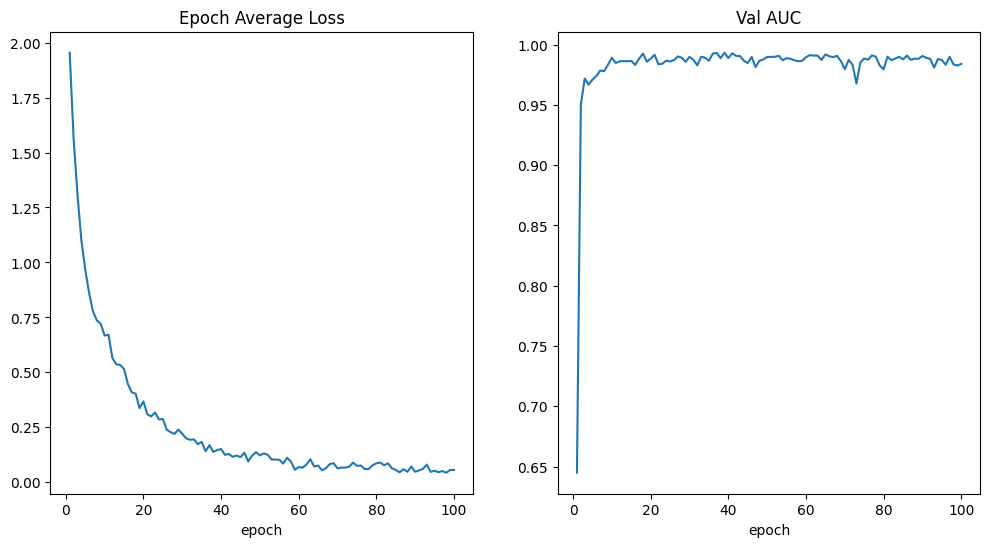

In [16]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluation

In [17]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_sagittal.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [18]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.4091    0.1304    0.1978        69
           1     0.1351    0.1471    0.1408        68
           2     0.0988    0.1159    0.1067        69
           3     0.5882    0.3077    0.4040        65
           4     0.4898    0.3692    0.4211        65
           5     0.5244    0.6515    0.5811        66
           6     0.1111    0.0357    0.0541        28
           7     0.3846    0.2381    0.2941        21
           8     0.1304    0.1429    0.1364        21
           9     0.3178    0.5942    0.4141        69
          10     0.0638    0.0870    0.0736        69

    accuracy                         0.2787       610
   macro avg     0.2957    0.2563    0.2567       610
weighted avg     0.3101    0.2787    0.2734       610



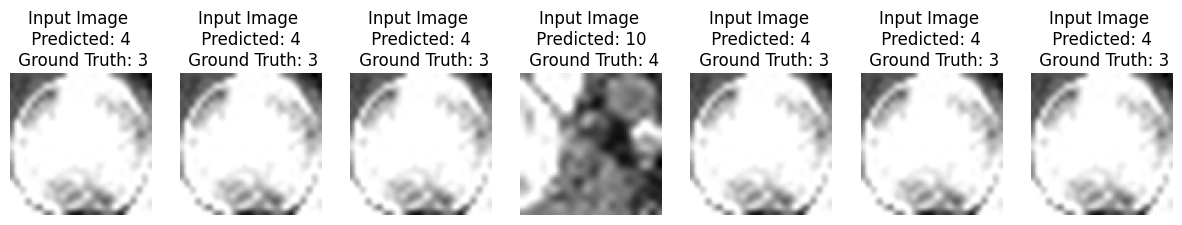

In [19]:
plot_examples(test_sagittal[:, 1], pred, test_labels, n=7)

## 3D slices evaluation

In [22]:
class Sliced_Dataset(Dataset):
    def __init__(self, dataset, slices=9, transform=None):
        self.dataset = dataset
        self.slices = slices
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data, label = self.dataset[idx]
        slices = self.slices

        if self.transform:
            data = self.transform(data)

        axial, coronal, sagittal = self.get_middle_slices(data, slices)

        data = {'axial': axial, 'coronal': coronal, 'sagittal': sagittal}
        
        return {'images': (data['axial'], data['coronal'], data['sagittal']), 'label': label}

    @staticmethod
    def get_middle_slices(data, slices):
        dims = data.shape
        axial, coronal, sagittal = [], [], []
        middle_idx = [dims[i] // 2 for i in range(1, 4)]
        
        for d in range(3):  # 0 - Axial, 1 - Coronal, 2 - Sagittal
            start_idx = middle_idx[d] - slices // 2  # Start 4 slices before the middle
            end_idx = middle_idx[d] + slices // 2 + 1    # End 4 slices after the middle
            
            for i in range(start_idx, end_idx, 3):
                if d == 0:
                    axial.append(data[:, i:i+3, :, :][0])
                elif d == 1:
                    coronal.append(data[:, :, i:i+3, :].permute(0, 2, 3, 1)[0])
                elif d == 2:
                    sagittal.append(data[:, :, :, i:i+3].permute(0, 3, 1, 2)[0])
        
        return axial, coronal, sagittal

## Pretrained

In [25]:
import pandas as pd

model = models.resnet18(pretrained=True).to(device)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model_axial = model.to(device)
model_coronal = model.to(device)
model_sagittal = model.to(device)


model_axial.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_axial_pretrained.pth"), weights_only=True))
model_axial.eval()

model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_coronal_pretrained.pth"), weights_only=True))
model_coronal.eval()

model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_sagittal_pretrained.pth"), weights_only=True))
model_sagittal.eval()

results = []

for num_slices in range(3, 33, 3):  # Adjust the range based on your requirements
    y_true = []
    y_pred = []

    train_dataset_ = Sliced_Dataset(train_dataset, slices=num_slices, transform=train_transforms)
    val_dataset_ = Sliced_Dataset(val_dataset, slices=num_slices, transform=val_transforms)
    test_dataset_ = Sliced_Dataset(test_dataset, slices=num_slices, transform=test_transforms)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset_, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset_, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset_, batch_size=BATCH_SIZE, shuffle=False)
    
    with torch.no_grad():
        for test_data in test_loader:
            test_images, test_labels = (
                test_data['images'],
                test_data['label'][:, 0].type(torch.LongTensor).to(device),
            )
            test_axial, test_coronal, test_sagittal = test_images
            for i in range(num_slices//3):
                pred_axial = model_axial(test_axial[i].to(device)).argmax(dim=1)
                pred_coronal = model_coronal(test_coronal[i].to(device)).argmax(dim=1)
                pred_sagittal = model_sagittal(test_sagittal[i].to(device)).argmax(dim=1)
                if i != 0:
                    pred = torch.cat((pred, torch.stack((pred_axial, pred_coronal, pred_sagittal), axis = 0)))
                else:
                    pred = torch.stack((pred_axial, pred_coronal, pred_sagittal), axis = 0)
            
            for i in range(pred.shape[1]):
                data = pred[:, i]
                counts = torch.bincount(data)
                most_frequent_value = torch.argmax(counts).item()
                
                y_true.append(test_labels[i].item())
                y_pred.append(most_frequent_value)

    # Generate classification report
    report = classification_report(y_true, y_pred, output_dict=True)

    selected_metrics = {
        "num_slices": num_slices,
        "accuracy": report["accuracy"],
    }
    results.append(selected_metrics)

# Combine all results into a single DataFrame
final_results = pd.DataFrame(results, index = None)

# Save to CSV or analyze further
final_results.to_csv("classification_results_pretrained_3_channels.csv", index=False)
print(final_results)

   num_slices  accuracy
0           3  0.509836
1           6  0.563934
2           9  0.613115
3          12  0.619672
4          15  0.640984
5          18  0.631148
6          21  0.665574
7          24  0.663934
8          27  0.672131
9          30  0.675410


## Unpretrained

In [26]:
model_axial = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=3, num_classes=n_classes).to(device)
model_axial.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_axial.pth"), weights_only=True))
model_axial.eval()
model_coronal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=3, num_classes=n_classes).to(device)
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_coronal.pth"), weights_only=True))
model_coronal.eval()
model_sagittal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=3, num_classes=n_classes).to(device)
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_sagittal.pth"), weights_only=True))
model_sagittal.eval()

results = []

for num_slices in range(3, 33, 3):  # Adjust the range based on your requirements
    y_true = []
    y_pred = []

    train_dataset_ = Sliced_Dataset(train_dataset, slices=num_slices, transform=train_transforms)
    val_dataset_ = Sliced_Dataset(val_dataset, slices=num_slices, transform=val_transforms)
    test_dataset_ = Sliced_Dataset(test_dataset, slices=num_slices, transform=test_transforms)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset_, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset_, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset_, batch_size=BATCH_SIZE, shuffle=False)
    
    with torch.no_grad():
        for test_data in test_loader:
            test_images, test_labels = (
                test_data['images'],
                test_data['label'][:, 0].type(torch.LongTensor).to(device),
            )
            test_axial, test_coronal, test_sagittal = test_images
            for i in range(num_slices//3):
                pred_axial = model_axial(test_axial[i].to(device)).argmax(dim=1)
                pred_coronal = model_coronal(test_coronal[i].to(device)).argmax(dim=1)
                pred_sagittal = model_sagittal(test_sagittal[i].to(device)).argmax(dim=1)
                if i != 0:
                    pred = torch.cat((pred, torch.stack((pred_axial, pred_coronal, pred_sagittal), axis = 0)))
                else:
                    pred = torch.stack((pred_axial, pred_coronal, pred_sagittal), axis = 0)
            
            for i in range(pred.shape[1]):
                data = pred[:, i]
                counts = torch.bincount(data)
                most_frequent_value = torch.argmax(counts).item()
                
                y_true.append(test_labels[i].item())
                y_pred.append(most_frequent_value)

    # Generate classification report
    report = classification_report(y_true, y_pred, output_dict=True)

    selected_metrics = {
        "num_slices": num_slices,
        "accuracy": report["accuracy"],
    }
    results.append(selected_metrics)

# Combine all results into a single DataFrame
final_results = pd.DataFrame(results, index = None)

# Save to CSV or analyze further
final_results.to_csv("classification_results_unpretrained_3_channels.csv", index=False)
print(final_results)

   num_slices  accuracy
0           3  0.837705
1           6  0.860656
2           9  0.870492
3          12  0.872131
4          15  0.873770
5          18  0.877049
6          21  0.868852
7          24  0.873770
8          27  0.865574
9          30  0.878689


# Using 2d models as a backbone

In [360]:
# Load the pretrained models for each slice direction
model_axial = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=3, num_classes=n_classes).to(device)
model_coronal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=3, num_classes=n_classes).to(device)
model_sagittal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=3, num_classes=n_classes).to(device)

# Load the trained weights for each model
model_axial.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_axial.pth"), weights_only=True))
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_coronal.pth"), weights_only=True))
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_sagittal.pth"), weights_only=True))

<All keys matched successfully>

In [361]:
class CombinedResNetModel(nn.Module):
    def __init__(self, model_axial, model_coronal, model_sagittal, num_classes=n_classes):
        super(CombinedResNetModel, self).__init__()
        
        # Load pretrained 2D models (without their final classification layers)
        self.model_axial = nn.Sequential(*list(model_axial.children())[:-1])
        self.model_coronal = nn.Sequential(*list(model_coronal.children())[:-1])
        self.model_sagittal = nn.Sequential(*list(model_sagittal.children())[:-1])

        # Assuming each model outputs a 512-dimension feature vector (from ResNet18)
        combined_feature_size = 512 * 3  # Concatenating features from all three directions
        
        # Final fully connected layer to classify the combined features
        self.fc = nn.Linear(combined_feature_size, num_classes)

    def forward(self, x):

        mid_axial = x.shape[2] // 2
        mid_coronal = x.shape[3] // 2
        mid_sagittal = x.shape[4] // 2
        axial_slice = x[:, :, mid_axial-1:mid_axial+2, :, :][:, 0].to(torch.float32)
        coronal_slice = x[:, :, :, mid_coronal-1:mid_coronal+2, :][:, 0].permute(0, 2, 3, 1).to(torch.float32)
        sagittal_slice = x[:, :, :, :, mid_sagittal-1:mid_sagittal+2][:, 0].permute(0, 3, 1, 2).to(torch.float32)

        # Get features from the respective models
        axial_features = self.model_axial(axial_slice).flatten(1)
        coronal_features = self.model_coronal(coronal_slice).flatten(1)
        sagittal_features = self.model_sagittal(sagittal_slice).flatten(1)

        # Concatenate the features from all three slices
        combined_features = torch.cat([axial_features, coronal_features, sagittal_features], dim=1)

        # Final classification
        out = self.fc(combined_features)
        return out

## Evaluation on a 3d dataset

In [362]:
train_loader_3d = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader_3d = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader_3d = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [363]:
combined_model = CombinedResNetModel(model_axial, model_coronal, model_sagittal, num_classes=n_classes).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(combined_model.fc.parameters(), lr=0.00005)

In [364]:
for epoch in range(30):
    combined_model.train()
    running_loss = 0.0
    for data in train_loader_3d:
        images, labels = data
        images, labels = images.to(device), labels.type(torch.LongTensor).to(device)

        optimizer.zero_grad()

        outputs = combined_model(images)
        loss = loss_function(outputs, labels[:, 0])

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_3d)}")

Epoch 1, Loss: 2.098588981936055
Epoch 2, Loss: 1.2405876401932008
Epoch 3, Loss: 0.7547625168677299
Epoch 4, Loss: 0.48175521243003105
Epoch 5, Loss: 0.3406950259400952
Epoch 6, Loss: 0.25013648646493114
Epoch 7, Loss: 0.20118065611008676
Epoch 8, Loss: 0.16598231321380985
Epoch 9, Loss: 0.14106231903837574
Epoch 10, Loss: 0.12003507200748689
Epoch 11, Loss: 0.10570033639669418
Epoch 12, Loss: 0.09403325028477176
Epoch 13, Loss: 0.08386689965282718
Epoch 14, Loss: 0.07787359361687014
Epoch 15, Loss: 0.07365350052714348
Epoch 16, Loss: 0.06765093221779793
Epoch 17, Loss: 0.06038313076621102
Epoch 18, Loss: 0.056365060830308546
Epoch 19, Loss: 0.052446154096434196
Epoch 20, Loss: 0.050524757754418156
Epoch 21, Loss: 0.04348359287025467
Epoch 22, Loss: 0.04513215009243258
Epoch 23, Loss: 0.04464817846253995
Epoch 26, Loss: 0.047755200806404316
Epoch 27, Loss: 0.032876431611516786
Epoch 28, Loss: 0.031179148553600235
Epoch 29, Loss: 0.03080639204070453
Epoch 30, Loss: 0.027066910429106604

In [365]:
combined_model.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader_3d:
        val_images, val_labels = val_data

        output = combined_model(val_images.to(device))
        
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, val_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    acc_value = torch.eq(y_pred.argmax(dim=1), y)
    acc_metric = acc_value.sum().item() / len(acc_value)

    print(f"Validation AUC: {result:.4f}, Accuracy: {acc_metric:.4f}")

Validation AUC: 0.9999, Accuracy: 14.7578


In [366]:
combined_model.eval()
y_true = []
y_pred = []
example_image = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader_3d:
        test_images, test_labels = test_data
        pred = combined_model(test_images.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_image.append(test_images)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [367]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9718    1.0000    0.9857        69
           1     0.8182    0.7941    0.8060        68
           2     0.7966    0.6812    0.7344        69
           3     0.7681    0.8154    0.7910        65
           4     0.8197    0.7692    0.7937        65
           5     0.8955    0.9091    0.9023        66
           6     1.0000    0.9643    0.9818        28
           7     1.0000    1.0000    1.0000        21
           8     0.9545    1.0000    0.9767        21
           9     0.8696    0.8696    0.8696        69
          10     0.8333    0.9420    0.8844        69

    accuracy                         0.8639       610
   macro avg     0.8843    0.8859    0.8841       610
weighted avg     0.8631    0.8639    0.8624       610



## Pretrained

In [368]:
train_loader_3d = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader_3d = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader_3d = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [369]:
model = models.resnet18(pretrained=True).to(device)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model_axial = model.to(device)
model_coronal = model.to(device)
model_sagittal = model.to(device)

model_axial.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_axial_pretrained.pth"), weights_only=True))
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_coronal_pretrained.pth"), weights_only=True))
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_sagittal_pretrained.pth"), weights_only=True))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [370]:
combined_model = CombinedResNetModel(model_axial, model_coronal, model_sagittal, num_classes=n_classes).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(combined_model.fc.parameters(), lr=0.00005)

In [371]:
for epoch in range(30):
    combined_model.train()
    running_loss = 0.0
    for data in train_loader_3d:
        images, labels = data
        images, labels = images.to(device), labels.type(torch.LongTensor).to(device)

        optimizer.zero_grad()

        outputs = combined_model(images)
        loss = loss_function(outputs, labels[:, 0])

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_3d)}")

Epoch 1, Loss: 2.1793270918630783
Epoch 2, Loss: 1.4804056613676009
Epoch 3, Loss: 1.0310944895590506
Epoch 4, Loss: 0.7625172811169778
Epoch 5, Loss: 0.5836869007156741
Epoch 6, Loss: 0.4795089219847033
Epoch 7, Loss: 0.3631144156379084
Epoch 8, Loss: 0.3410014659166336
Epoch 9, Loss: 0.27999977190648356
Epoch 10, Loss: 0.2285288567504575
Epoch 11, Loss: 0.20213042031372747
Epoch 12, Loss: 0.17428075594286765
Epoch 13, Loss: 0.17508420516406337
Epoch 14, Loss: 0.15023698249170858
Epoch 15, Loss: 0.133852087441952
Epoch 16, Loss: 0.12681349222698518
Epoch 17, Loss: 0.11014734545061665
Epoch 18, Loss: 0.11304626445616445
Epoch 19, Loss: 0.09737564599321734
Epoch 20, Loss: 0.10001528575535744
Epoch 21, Loss: 0.08432709858302147
Epoch 22, Loss: 0.08590364119698925
Epoch 23, Loss: 0.0790368576924647
Epoch 24, Loss: 0.08309969414145715
Epoch 25, Loss: 0.07588453993441598
Epoch 26, Loss: 0.07183437740370151
Epoch 27, Loss: 0.052556285935063514
Epoch 28, Loss: 0.06604411416957455
Epoch 29, Lo

In [372]:
combined_model.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader_3d:
        val_images, val_labels = val_data

        output = combined_model(val_images.to(device))
        
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, val_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    acc_value = torch.eq(y_pred.argmax(dim=1), y)
    acc_metric = acc_value.sum().item() / len(acc_value)

    print(f"Validation AUC: {result:.4f}, Accuracy: {acc_metric:.4f}")

Validation AUC: 0.9976, Accuracy: 14.7329


In [373]:
combined_model.eval()
y_true = []
y_pred = []
example_image = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader_3d:
        test_images, test_labels = test_data
        pred = combined_model(test_images.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_image.append(test_images)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [374]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9452    1.0000    0.9718        69
           1     0.6515    0.6324    0.6418        68
           2     0.7045    0.4493    0.5487        69
           3     0.5238    0.5077    0.5156        65
           4     0.4691    0.5846    0.5205        65
           5     0.7722    0.9242    0.8414        66
           6     1.0000    0.9286    0.9630        28
           7     1.0000    0.8571    0.9231        21
           8     0.8750    1.0000    0.9333        21
           9     0.9077    0.8551    0.8806        69
          10     0.9437    0.9710    0.9571        69

    accuracy                         0.7639       610
   macro avg     0.7993    0.7918    0.7906       610
weighted avg     0.7685    0.7639    0.7610       610



## Hyper network

In [375]:
class HyperNetwork(nn.Module):
    def __init__(self, model_axial, model_coronal, model_sagittal, num_classes=11):
        super(HyperNetwork, self).__init__()
        
        # Load pretrained 2D models (without their final classification layers)
        self.model_axial = nn.Sequential(*list(model_axial.children())[:-1])
        self.model_coronal = nn.Sequential(*list(model_coronal.children())[:-1])
        self.model_sagittal = nn.Sequential(*list(model_sagittal.children())[:-1])
        
        # Hypernetwork for weighting the features
        self.hyper_fc = nn.Sequential(
            nn.Linear(512 * 3, 256),  # Adjust based on feature size
            nn.ReLU(),
            nn.Linear(256, 512 * 3),
            nn.Sigmoid()
        )
        
        # Final classification layer
        self.fc = nn.Linear(512 * 3, num_classes)

    def forward(self, x):
        
        mid_axial = x.shape[2] // 2
        mid_coronal = x.shape[3] // 2
        mid_sagittal = x.shape[4] // 2
        axial_slice = x[:, :, mid_axial-1:mid_axial+2, :, :][:, 0].to(torch.float32)
        coronal_slice = x[:, :, :, mid_coronal-1:mid_coronal+2, :][:, 0].permute(0, 2, 3, 1).to(torch.float32)
        sagittal_slice = x[:, :, :, :, mid_sagittal-1:mid_sagittal+2][:, 0].permute(0, 3, 1, 2).to(torch.float32)
        
        features_axial = self.model_axial(axial_slice).flatten(1)
        features_coronal = self.model_coronal(coronal_slice).flatten(1)
        features_sagittal = self.model_sagittal(sagittal_slice).flatten(1)
        
        combined_features = torch.cat([features_axial, features_coronal, features_sagittal], dim=1)
        
        # Apply hypernetwork to decide weights
        weights = self.hyper_fc(combined_features)
        combined_weighted_features = combined_features * weights
        
        # Final classification
        out = self.fc(combined_weighted_features)
        return out

In [376]:
# Load the pretrained models for each slice direction
model_axial = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=3, num_classes=n_classes).to(device)
model_coronal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=3, num_classes=n_classes).to(device)
model_sagittal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=3, num_classes=n_classes).to(device)

# Load the trained weights for each model
model_axial.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_axial.pth"), weights_only=True))
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_coronal.pth"), weights_only=True))
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_sagittal.pth"), weights_only=True))

<All keys matched successfully>

In [ ]:
# Initialize the hypernetwork
hypernetwork = HyperNetwork(model_axial, model_coronal, model_sagittal, num_classes=11).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(hypernetwork.fc.parameters(), lr=0.00005)

In [ ]:
for epoch in range(30):
    hypernetwork.train()
    running_loss = 0.0
    for data in train_loader_3d:
        images, labels = data
        images, labels = images, labels.type(torch.LongTensor)

        optimizer.zero_grad()

        outputs = hypernetwork(images.to(device))
        loss = loss_function(outputs, labels[:, 0].to(device))

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_3d)}")

Epoch 1, Loss: 2.291580584741408
Epoch 2, Loss: 1.7785666527286652
Epoch 3, Loss: 1.3620109981106174
Epoch 4, Loss: 1.0502596593672229
Epoch 5, Loss: 0.8139238030679764
Epoch 6, Loss: 0.6422330698659343
Epoch 7, Loss: 0.519023101175985
Epoch 8, Loss: 0.43483572236953244
Epoch 9, Loss: 0.3625283356635801
Epoch 10, Loss: 0.31158015468428213
Epoch 11, Loss: 0.2707188129425049
Epoch 12, Loss: 0.23965745491366233
Epoch 13, Loss: 0.2095817236169692
Epoch 14, Loss: 0.1900239202284044
Epoch 15, Loss: 0.1671733659121298
Epoch 16, Loss: 0.1594531091470872
Epoch 17, Loss: 0.1455487786762176
Epoch 18, Loss: 0.13766039571454447
Epoch 19, Loss: 0.1237825388389249
Epoch 20, Loss: 0.12118368836179856
Epoch 21, Loss: 0.10727290929325166
Epoch 22, Loss: 0.10656586553781264
Epoch 23, Loss: 0.09622803114114269
Epoch 24, Loss: 0.08632347985140738
Epoch 25, Loss: 0.08526684187592999
Epoch 26, Loss: 0.09273967399231849
Epoch 27, Loss: 0.07886752942877431
Epoch 28, Loss: 0.08274950964316245
Epoch 29, Loss: 0.

In [ ]:
hypernetwork.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader_3d:
        val_images, val_labels = val_data

        output = hypernetwork(val_images.to(device))
        
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, val_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    acc_value = torch.eq(y_pred.argmax(dim=1), y)
    acc_metric = acc_value.sum().item() / len(acc_value)

    print(f"Validation AUC: {result:.4f}, Accuracy: {acc_metric:.4f}")

Validation AUC: 0.9999, Accuracy: 14.7578


In [ ]:
hypernetwork.eval()
y_true = []
y_pred = []
example_image = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader_3d:
        test_images, test_labels = test_data
        pred = hypernetwork(test_images.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_image.append(test_images)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [ ]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9718    1.0000    0.9857        69
           1     0.8333    0.7353    0.7812        68
           2     0.7869    0.6957    0.7385        69
           3     0.7612    0.7846    0.7727        65
           4     0.7903    0.7538    0.7717        65
           5     0.8939    0.8939    0.8939        66
           6     1.0000    0.9286    0.9630        28
           7     0.9545    1.0000    0.9767        21
           8     0.9545    1.0000    0.9767        21
           9     0.8310    0.8551    0.8429        69
          10     0.8171    0.9710    0.8874        69

    accuracy                         0.8525       610
   macro avg     0.8722    0.8744    0.8719       610
weighted avg     0.8519    0.8525    0.8506       610



## Pretrained

In [ ]:
model = models.resnet18(pretrained=True).to(device)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model_axial = model.to(device)
model_coronal = model.to(device)
model_sagittal = model.to(device)

model_axial.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_axial_pretrained.pth"), weights_only=True))
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_coronal_pretrained.pth"), weights_only=True))
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_sagittal_pretrained.pth"), weights_only=True))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:
# Initialize the hypernetwork
hypernetwork = HyperNetwork(model_axial, model_coronal, model_sagittal, num_classes=11).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(hypernetwork.fc.parameters(), lr=0.00005)

In [ ]:
for epoch in range(30):
    hypernetwork.train()
    running_loss = 0.0
    for data in train_loader_3d:
        images, labels = data
        images, labels = images, labels.type(torch.LongTensor)

        optimizer.zero_grad()

        outputs = hypernetwork(images.to(device))
        loss = loss_function(outputs, labels[:, 0].to(device))

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_3d)}")

Epoch 1, Loss: 2.403132538641653
Epoch 2, Loss: 1.975339328089068
Epoch 3, Loss: 1.629089686178392
Epoch 4, Loss: 1.3430910187382852
Epoch 5, Loss: 1.1211052171645626
Epoch 6, Loss: 0.933474644537895
Epoch 7, Loss: 0.7875094702166896
Epoch 8, Loss: 0.6700993757094106
Epoch 9, Loss: 0.5831746209052301
Epoch 10, Loss: 0.5162593107069692
Epoch 11, Loss: 0.4614636426971805
Epoch 12, Loss: 0.39845912398830535
Epoch 13, Loss: 0.36798437180057647
Epoch 14, Loss: 0.3372275915838057
Epoch 15, Loss: 0.2976365896963304
Epoch 16, Loss: 0.2815508145478464
Epoch 17, Loss: 0.25227867403338033
Epoch 18, Loss: 0.23690241046490207
Epoch 19, Loss: 0.20694265394441544
Epoch 20, Loss: 0.21094536348696677
Epoch 21, Loss: 0.19003708324124735
Epoch 22, Loss: 0.17301043723860093
Epoch 23, Loss: 0.17101043919401784
Epoch 24, Loss: 0.15758846147406486
Epoch 25, Loss: 0.1540949803686911
Epoch 26, Loss: 0.14314895964437915
Epoch 27, Loss: 0.1344029492428226
Epoch 28, Loss: 0.13528916023431287
Epoch 29, Loss: 0.125

In [ ]:
hypernetwork.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader_3d:
        val_images, val_labels = val_data

        output = hypernetwork(val_images.to(device))
        
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, val_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    acc_value = torch.eq(y_pred.argmax(dim=1), y)
    acc_metric = acc_value.sum().item() / len(acc_value)

    print(f"Validation AUC: {result:.4f}, Accuracy: {acc_metric:.4f}")

Validation AUC: 0.9981, Accuracy: 14.7143


In [ ]:
hypernetwork.eval()
y_true = []
y_pred = []
example_image = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader_3d:
        test_images, test_labels = test_data
        pred = hypernetwork(test_images.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_image.append(test_images)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [ ]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9079    1.0000    0.9517        69
           1     0.6949    0.6029    0.6457        68
           2     0.7097    0.6377    0.6718        69
           3     0.5439    0.4769    0.5082        65
           4     0.5195    0.6154    0.5634        65
           5     0.8889    0.9697    0.9275        66
           6     1.0000    0.8929    0.9434        28
           7     0.9091    0.9524    0.9302        21
           8     0.9500    0.9048    0.9268        21
           9     0.9194    0.8261    0.8702        69
          10     0.8718    0.9855    0.9252        69

    accuracy                         0.7836       610
   macro avg     0.8105    0.8058    0.8058       610
weighted avg     0.7824    0.7836    0.7805       610

